# Previsão do faturamento da empresa de acordo com produtos

Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)

[Projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

## Case

Imagine que você trabalha numa empresa de benefícios que vende diversos produtos para os RHs clientes, com o intuito de melhorar a qualidade de vida de seus colaboradores por meio de alimentação saudável, transporte, saúde, entre outros.

Para ajudar no direcionamento e estratégia corporativa, bem como definir a meta do time comercial, você ficou encarregado de prever qual seria o faturamento mensal esperado para 2022.

## Etapas de análise

### Etapa I - **EDA - Análise exploratória de dados**

1. Análise das medidas de medidas de posição, dispersão, correlação (análises univaridas e bivariadas) - histograma, boxplot, mapa de calor, etc...
2. Identificação e tratamento de *outliers* e *missings*, caso necessário (sempre explicando a opção)

### Etapa II - **Análise de séries temporais**

1. Ajuste um modelo para o faturamento total (sem quebrar por produto) e realize a projeção para os meses faltantes até o final de 2022.
2. Faça ajustes indivíduais para cada produto e consolide os resultados para obter o faturamento total para os meses faltantes até o final de 2022.
3. Qual dos dois cenários obteve a melhor projeção? Qual cenário você usaria dentro da sua empresa pensando nos desdobramentos estratégicos citados acima? Justifique a sua resposta com base em métricas bem definidas e no entendimento do problema.

In [241]:
# importação de bibliotecas
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from tqdm import tqdm

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from pmdarima.arima.utils import ndiffs, nsdiffs

import scipy.stats as spst

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# pacote com funções para análise desse projeto
import py_scripts.plots, py_scripts.transform, py_scripts.metrics, py_scripts.models

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Informações sobre o dataset

* **[sim_ts.txt](data/sim_ts.txt)** - Série temporal sintética com os meses (a data está completa com ano, mês e dia, mas o dia é irrelevante), os valores recebidos e o produto correspondente.

### Campos

* **vlr**: Vlr. faturado no mês
* **date**: Mês de referência do faturamento
* **produto**: Produto ao qual o faturamento diz respeito

## Importação dos dados e análise inicial

Inicialmente, vamos importar e ver a aparência geral dos dados:

* número e nome de colunas
* qual o tipo de dados de cada coluna
* Algumas linhas do dataset

In [2]:
# importar base e iniciar a análise inicial
ts_raw = pd.read_csv(r'data/sim_ts.txt', sep = '\t')
ts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vlr      511 non-null    float64
 1   date     511 non-null    object 
 2   produto  511 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.1+ KB


In [3]:
ts_raw.describe()

vlr
count  5.110000e+02
mean   4.187929e+08
std    6.272376e+08
min    0.000000e+00
25%    6.472878e+05
50%    2.261791e+07
75%    1.028848e+09
max    1.990000e+09

In [4]:
ts_raw.sample(5).sort_index()

vlr        date      produto
30   1.066084e+09  2012-06-01  alimenticio
85   1.475569e+09  2017-01-01  alimenticio
165  1.565260e+08  2016-11-01   transporte
386  1.075023e+05  2014-11-01  bonificacao
479  2.352998e+07  2019-03-01        saude

### Limpeza dos dados

Vamos definir algumas funções de limpeza dos dados.

Ao final desse processo, teremos três estruturas de dados:

- um *dataframe* `ts` associando os meses aos faturamentos e aos produtos;
- um dicionário `tsd` cujas chaves serão os produtos e os valores serão *Series* associando meses e faturamentos (contanto desde o lançamento do produto); e
- um *dataframe* `tswide` onde cada coluna corresponde à série histórica de um produto.

Ao dicionário `tsd` será adicionada uma chave, `total`, contendo a soma dos faturamentos de todos os produtos mês a mês.

In [5]:
# limpeza 1: conversão de tipos

def conversao_tipos(df):
    df = df.copy()

    df['date'] = df['date'].astype('datetime64[ns]')
    df['produto'] = df['produto'].astype('category')
    return df

# limpeza 2: setar a coluna de data como indice
def setar_indice_data(df):
    df = df.copy()

    s = df.set_index('date')['vlr']

    return s

# limpeza 3: gerar dados de meses faltantes

def gerar_dados_faltantes(s):
    s = s.copy()

    s = s.asfreq('MS')

    return s

# limpeza 4: preencher missings
def preencher_missings(s):
    s = s.copy()

    # s = s.interpolate()

    return s

# executar limpeza para o DF ts
# não é possível setar a data como índice porque há multiplas entradas com mesmo mês.
# isso geraria problemas para funções de agregação (groupby's etc) e JOIN's.
# logo, para o 
ts = (ts_raw
    .pipe(conversao_tipos)
)


In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   vlr      511 non-null    float64       
 1   date     511 non-null    datetime64[ns]
 2   produto  511 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 8.8 KB


In [7]:
ts.sample(10).sort_index()

vlr       date               produto
33   1.112209e+09 2012-09-01           alimenticio
44   1.140466e+09 2013-08-01           alimenticio
114  1.655401e+09 2019-06-01           alimenticio
157  1.633660e+08 2016-03-01            transporte
236  8.159466e+05 2010-11-01  auxilio_final_de_ano
295  1.502673e+06 2015-10-01  auxilio_final_de_ano
365  1.287936e+05 2012-03-01           bonificacao
400  1.250599e+05 2016-05-01           bonificacao
419  1.462332e+05 2018-03-01           bonificacao
486  2.338761e+07 2019-10-01                 saude

Vamos agora construir o dicionário `tsd` e o dataframe `tswide`:

In [8]:
produtos = ts['produto'].cat.categories

tsd = {}
for produto in produtos:
    ts_produto = ts[ts['produto'] == produto]

    # finalizar limpeza para Series dentro do dicionário
    s_prod = (ts_produto
        .pipe(setar_indice_data)
        .pipe(gerar_dados_faltantes)
        .pipe(preencher_missings)
    )
    s_prod.name = f'faturamento_{produto}'
    tsd[produto] = s_prod

tswide = pd.DataFrame(tsd)

sprodtotal = tswide.sum(axis = 1)
sprodtotal.name = 'faturamento_total'
tsd['total'] = sprodtotal

for produto, s in tsd.items():
    print(f"Quantidade de dados faltantes para o produto '{produto}': {s.isna().sum()}")
    print(f"Lançamento do produto '{produto}': {s.index[0].strftime('%Y-%m-%d')}")
    print('')

# confirmação do dataframe limpo
# ts.info()

Quantidade de dados faltantes para o produto 'alimenticio': 0
Lançamento do produto 'alimenticio': 2009-12-01

Quantidade de dados faltantes para o produto 'auxilio_final_de_ano': 0
Lançamento do produto 'auxilio_final_de_ano': 2009-12-01

Quantidade de dados faltantes para o produto 'bonificacao': 30
Lançamento do produto 'bonificacao': 2012-01-01

Quantidade de dados faltantes para o produto 'saude': 0
Lançamento do produto 'saude': 2016-11-01

Quantidade de dados faltantes para o produto 'transporte': 0
Lançamento do produto 'transporte': 2015-01-01

Quantidade de dados faltantes para o produto 'total': 0
Lançamento do produto 'total': 2009-12-01



#### Tratamento de valores faltantes

Há alguns padrões interessantes de valores faltantes para alguns produtos:

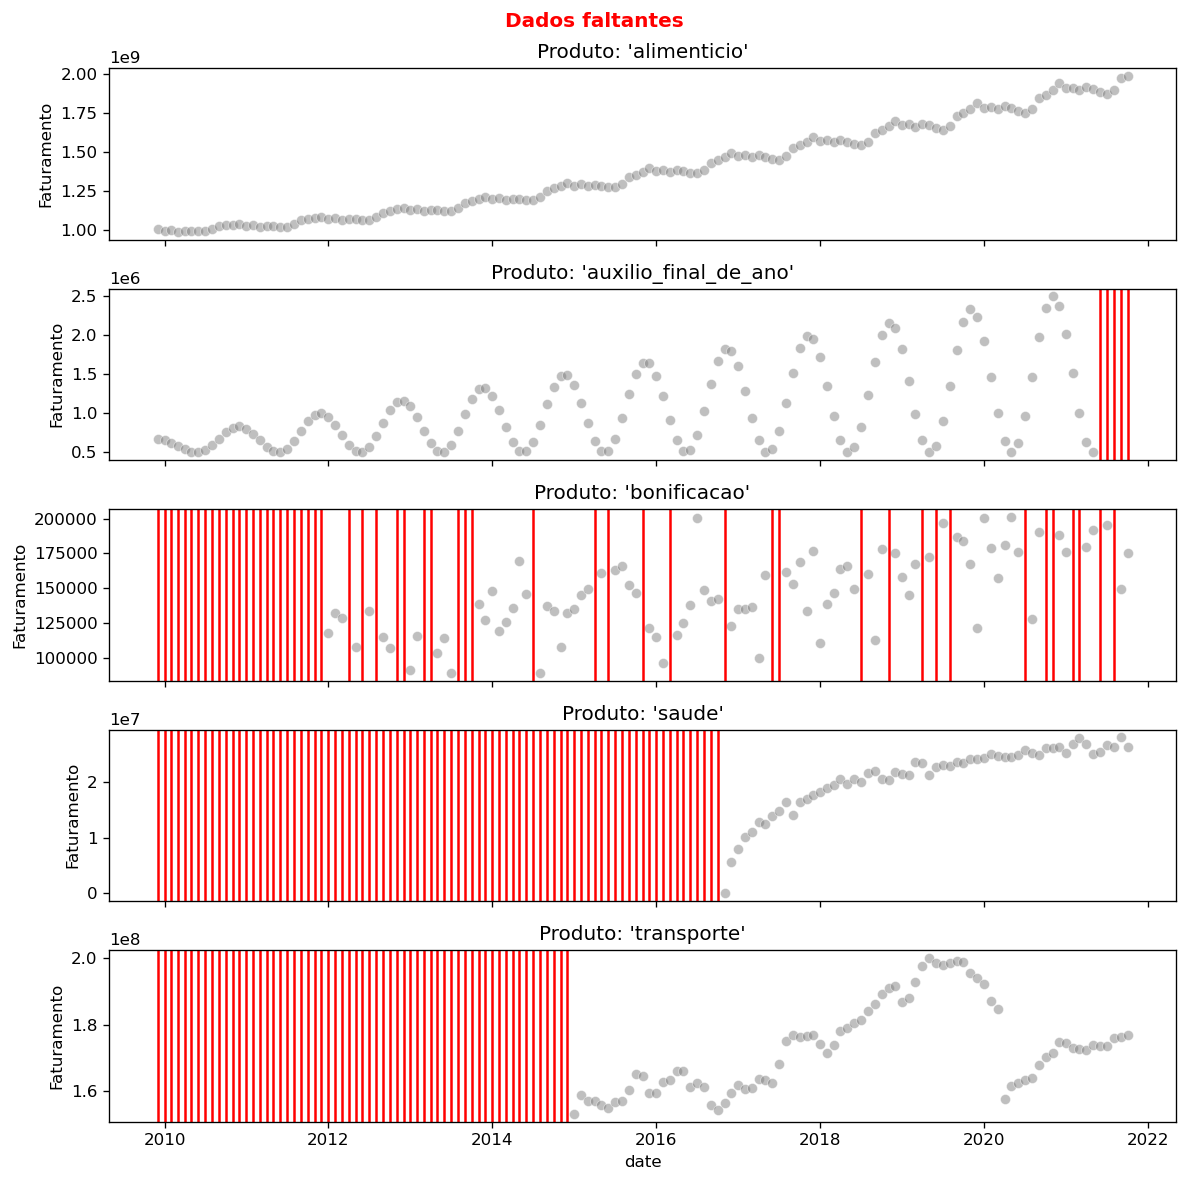

In [9]:
py_scripts.plots.dados_faltantes(tswide)

In [10]:
tswide.index[tswide['auxilio_final_de_ano'].isna()]

DatetimeIndex(['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

Claramente, vê-se que:

- **Não há nenhum dado faltante para o produto `alimenticio`**;
- Os produtos `saude` e `transporte` foram introduzidos após o início da série histórica. **Não há nenhum dado faltante após o lançamento desses produtos**.
- O produto `auxilio_final_de_ano` tem dados faltantes seguidos após maio de 2021. É razoável assumir que há uma falha na coleta de dados nos últimos 5 meses. **Deixaremos estes valores indefinidos por enquanto, de forma a facilitar a análise de séries temporais que seguirá**. 
- O produto `bonificacao` também foi introduzido após o início da série histórica; no entanto, contém dados faltantes aparentemente de forma aleatória.

Logo, devemos avaliar o que faremos a respeito dos dados faltantes do produto `bonificacao`.

Nota-se no gráfico acima que o produto `bonificacao` responde por um faturamento 4 ordens de magnitude menor que o produto `alimenticio`. Independente do tratamento a ser dado, o efeito sobre o faturamento total será mínimo.

Há duas abordagens possíveis:

* **Valores indefinidos são falhas de registro**: Uma das funcionalidades dos modelos de séries temporais que usaremos é a **imputação de valores faltantes**. Por conta disso, os valores indefinidos da série `bonificacao` podem ser deixados com valores indefinidos, de forma que possam ser imputados com seus valores mais prováveis em um momento posterior; ou
* **Valores indefinidos são meses em que o faturamento é zero**: neste caso, os valores indefinidos devem ser preenchidos com zero. No entanto, o modelo a ser considerado deve ser um pouco mais complexo para considerar como a frequência de faturamentos zero varia ao longo do tempo.

Como há duas alternativas igualmente razoáveis, deixaremos por ora os valores dos faturamentos indefinidos do produto `bonificacao` como estão, de forma que sejam tratados em notebook próprio.

In [11]:
# OBS: antes do lançamento, o faturamento deve ser nan. 
# Isso auxiliará na dropagem de valores antes do lançamento depois
# Caso queiramos a série completa (incluindo os nan), basta acessarmos
# o DF `tswide`

# construindo um dicionario com a data de lancamento de cada produto
# primeira data com dados não nulos
lancamentos = { }

for produto in produtos:
    s = tsd[produto]
    lancamento = s.index[0]
    lancamentos[produto] = lancamento

# bonificacao: valores faltantes após lançamento permanecerão NaN e serão tratados em notebook próprio
#tswide['bonificacao'] = tswide['bonificacao'].fillna(0)
tswide.loc[:lancamentos['bonificacao'], 'bonificacao'] = np.nan

# auxilio_fim_de_ano: valores faltantes em 2021 assumidos como falha de registro. Permanecem NaN
#tswide['auxilio_final_de_ano'] = tswide['auxilio_final_de_ano'].fillna(0)
tswide.loc[:lancamentos['auxilio_final_de_ano'], 'auxilio_final_de_ano'] = np.nan

In [12]:
py_scripts.plots.dados_faltantes(tswide)

Vamos agora reconstruir o dicionário `tsd` após completar os valores faltantes.

In [13]:
tsd = {}
for produto in produtos:
    sprod = tswide[produto].dropna()
    sprod.name = f'faturamento_{produto}'
    tsd[produto] = sprod

sprodtotal = tswide.sum(axis = 'columns')
tsd['total'] = sprodtotal

Por fim, vamos salvar os dados limpos e pré-processados.

In [14]:
sim_ts = py_scripts.transform.wide2long(tswide)

# salvar
sim_ts.to_csv(r'data/sim_ts_limpo.csv', index = False)

## Próximos passos

Em seguida, vamos realizar a análise esxploratória dos dados do faturamento total e segregado por cada produto.

# 2 - Análise de Séries Temporais - Faturamento Total

## Importação dos dados

In [19]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)
fat_total = tswide.sum(axis = 'columns').dropna()

In [16]:
fat_total

date
2009-12-01    1.006195e+09
2010-01-01    9.993524e+08
2010-02-01    1.000041e+09
2010-03-01    9.905806e+08
2010-04-01    9.947466e+08
                  ...     
2021-06-01    2.086224e+09
2021-07-01    2.073233e+09
2021-08-01    2.101590e+09
2021-09-01    2.179518e+09
2021-10-01    2.193340e+09
Freq: MS, Length: 143, dtype: float64

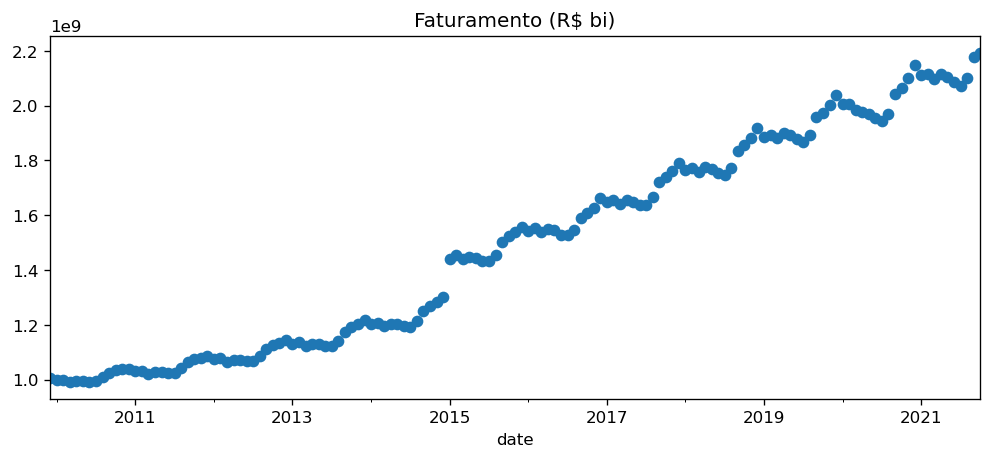

In [17]:
fat_total.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

## Análise Exploratória

Vamos primeiramente analisar o faturamento total contido na série histórica:

In [18]:
fat_total = tsd['total']
fat_total.describe()

count    1.430000e+02
mean     1.496520e+09
std      3.836341e+08
min      9.905806e+08
25%      1.122928e+09
50%      1.527953e+09
75%      1.861295e+09
max      2.193340e+09
Name: faturamento_total, dtype: float64

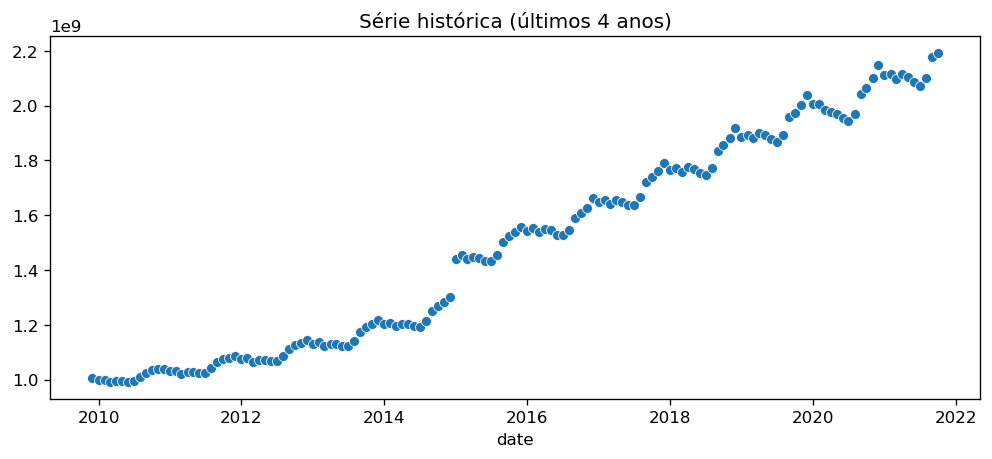

In [20]:
sns.scatterplot(data = fat_total)
plt.title('Série histórica (últimos 4 anos)')
plt.show()

Parece haver um salto entre 2014 e 2015 no faturamento total. 

Esse salto é devido ao lançamento de um outro produto, `transporte`. O faturamento deste novo produto é uma ordem de magnitude menor que o faturamento do produto `alimenticio` (como vimos brevemente no gráfico de dados faltantes e veremos com detalhes mais a frente), mas é o suficiente para que seja notado no faturamento total.

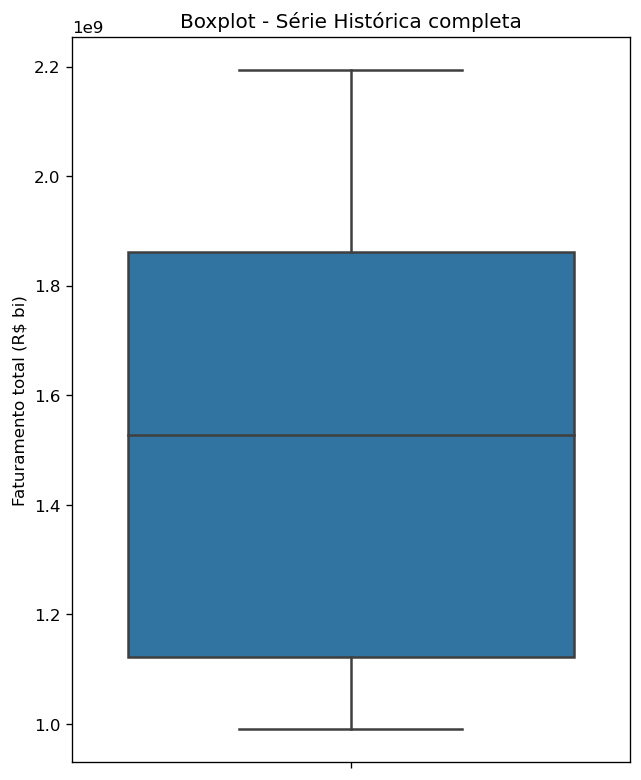

In [21]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat_total)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

In [22]:
sns.histplot(fat_total)
plt.xlabel('Faturamento total (R$ bi)')
plt.title('Histograma - Série Histórica completa')
plt.show()

No entanto, medidas descritivas de séries temporais devem ser tomadas em relação ao tempo. Vamos separar essas medidas ano a ano:

In [23]:
n_anos = 4
anos_recentes = fat_total[fat_total.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.961071e+09
std      1.257704e+08
min      1.748082e+09
25%      1.881462e+09
50%      1.969575e+09
75%      2.073233e+09
max      2.193340e+09
dtype: float64

In [24]:
sns.scatterplot(data = anos_recentes)
plt.title(f'Série histórica (últimos {n_anos} anos)')
plt.show()

In [25]:
sns.boxplot(y = fat_total, x = fat_total.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Boxplot - Série Histórica completa')
plt.show()

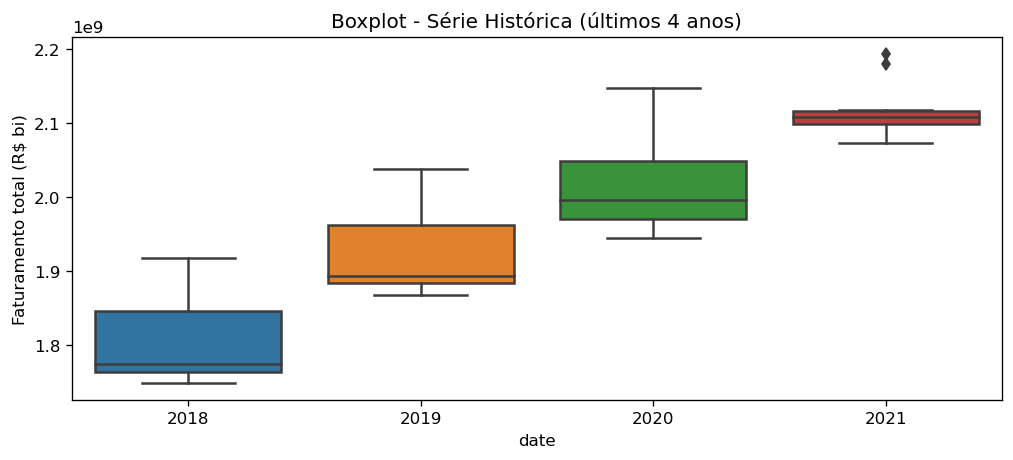

In [26]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (últimos {n_anos} anos)')
plt.show()

Parece haver alguns *outliers* em 2021.

No entanto, a série de 2021 está incompleta (vai somente até outubro). Historicamente, há um salto no faturamento em agosto, o que pode estar causando essa deturpação das medidas descritivas.

Excluindo o ano de 2021...

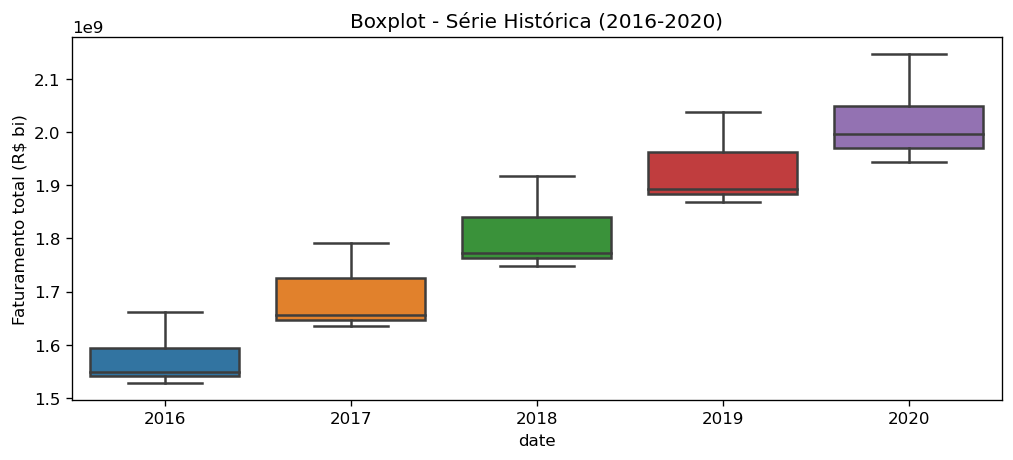

In [27]:
anos_recentes_exc2021 = fat_total[(fat_total.index >= '2016') & (fat_total.index < '2021')]
sns.boxplot(y = anos_recentes_exc2021, x = anos_recentes_exc2021.index.year)
plt.ylabel('Faturamento total (R$ bi)')
plt.title(f'Boxplot - Série Histórica (2016-2020)')
plt.show()

A pandemia se faz notar nos dados apenas com o aumento ligeiro da mediana em relação à distância entre o Q1 e o Q3.

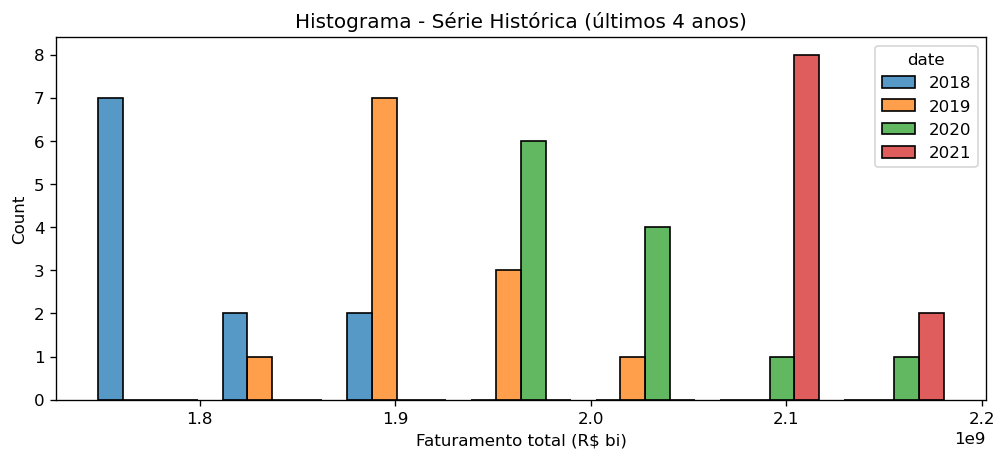

In [28]:
sns.histplot(x = anos_recentes, hue = anos_recentes.index.year, multiple = 'dodge', shrink = .8, common_norm = False, palette = sns.color_palette()[:4])
plt.xlabel('Faturamento total (R$ bi)')
plt.title(f'Histograma - Série Histórica (últimos {n_anos} anos)')
plt.show()

Os histogramas ano a ano estão melhor comportados que o histograma da série histórica completa.

Fazendo uma análise mês a mês para cada ano...

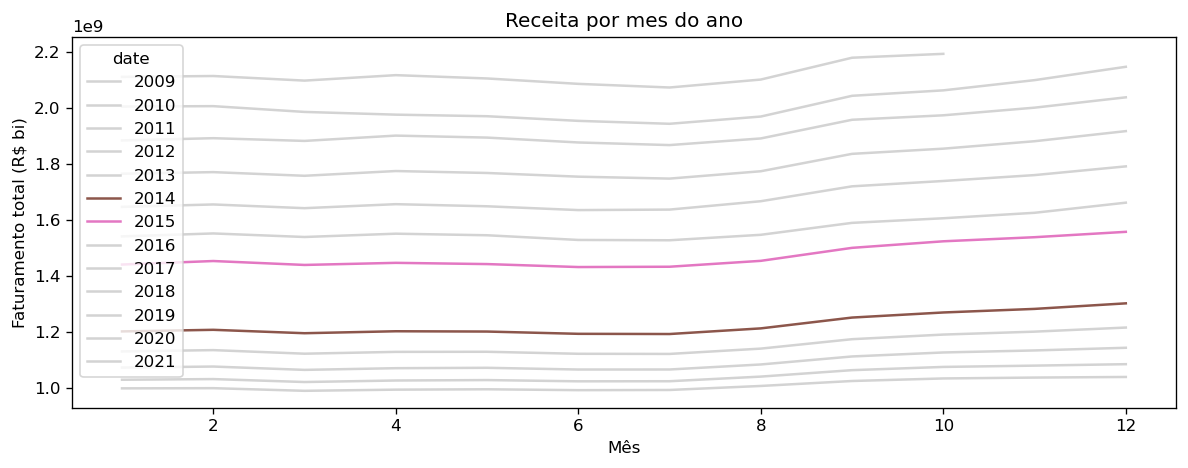

In [29]:
hue = fat_total.index.year

palette = []
for i, year in enumerate(hue.unique()):
    if year not in [2014, 2015]:
        palette += ['lightgray']
    else:
        palette += [sns.color_palette()[i]]

ax = sns.lineplot(
    y = fat_total, x = fat_total.index.month, 
    hue = fat_total.index.year,
    palette = palette
)
ax.set_xlabel('Mês')
ax.set_ylabel('Faturamento total (R$ bi)')
ax.set_title(f"Receita por mes do ano")
plt.tight_layout()
plt.show()

... nota-se claramente o salto dado de 2014 para 2015 com a entrada do novo produto.

## Estacionariedade

Para que a série de faturamentos mensais totais possa ser decomposta, é necessário que ela seja estacionária. 

Não parece ser, mas vamos testar através do teste estatístico de Dickey-Fuller.

A hipótese nula do teste de Dickey-Fuller é que a série é um passeio aleatório (random walk):

In [30]:
testedf = adfuller(fat_total)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.')

Valor-p: 98.342% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula.


Isso é evidenciado pela decomposição da série temporal.

## Decomposição em séries de Fourier

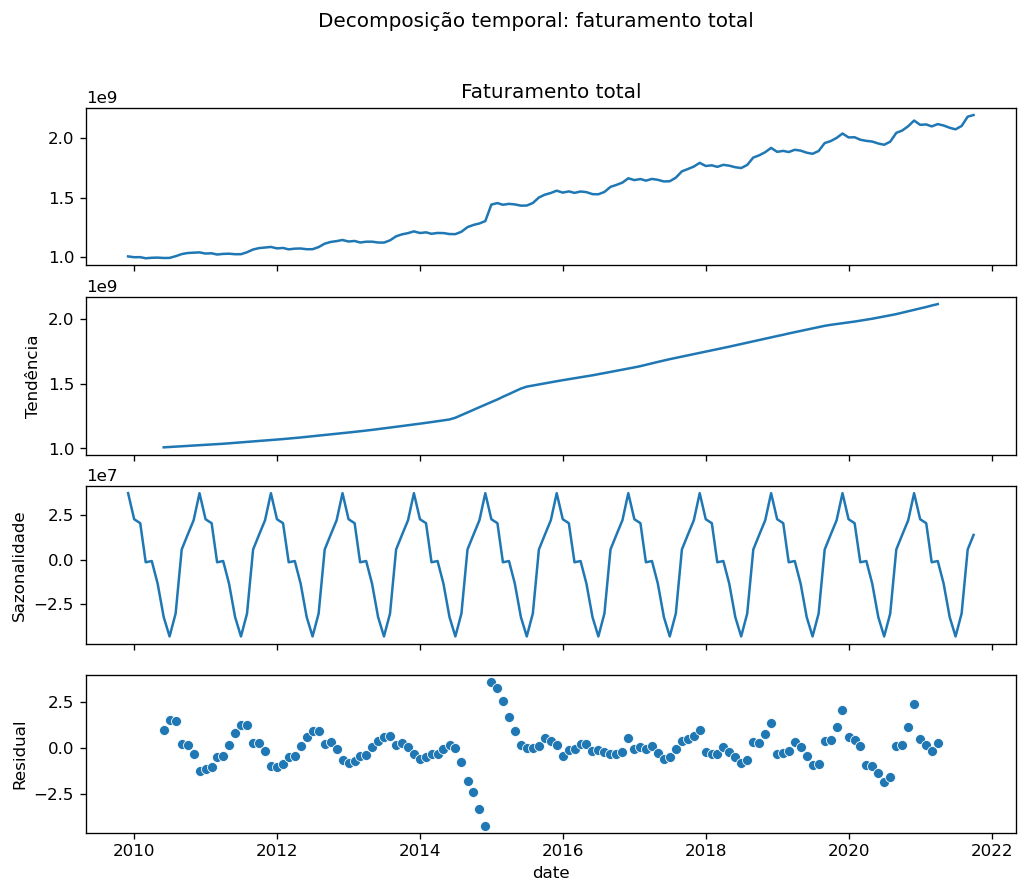

In [31]:
decomp_total = seasonal_decompose(fat_total)

# plot      
fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

sns.lineplot(data = fat_total, ax = axs[0])
axs[0].set_title('Faturamento total')

sns.lineplot(data = decomp_total.trend, ax = axs[1])
axs[1].set_ylabel('Tendência')

sns.lineplot(data = decomp_total.seasonal, ax = axs[2])
axs[2].set_ylabel('Sazonalidade')

resid = (decomp_total.resid - decomp_total.resid.mean())/decomp_total.resid.std()
sns.scatterplot(data = resid, ax = axs[3])
axs[3].set_ylabel('Residual')

fig.suptitle(f"Decomposição temporal: faturamento total")
plt.show()

Como mostrado anteriormente, esta série temporal não é estacionária, o que podemos ver através dos resíduos padronizados do último quadro (onde há um padrão claro oscilatório).

## Modelo autorregressivo - Faturamento total

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

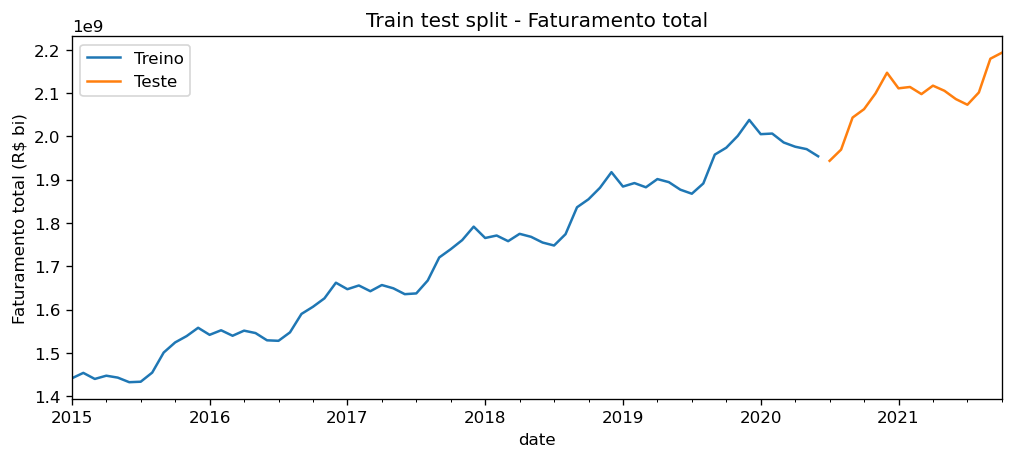

In [32]:
# excluindo o período pré-2015

test_begin = '2020-01-01'
fat_modelo = fat_total['2015-01-01':]

total_train = fat_modelo[:test_begin].iloc[:-1]
total_test = fat_modelo[test_begin:]


train_test_split_idx = int(fat_modelo.shape[0] * 0.8 + 1)
total_train = fat_modelo[:train_test_split_idx]
total_test = fat_modelo[train_test_split_idx:]

total_train.plot(label = 'Treino')
total_test.plot(label = 'Teste')
plt.title('Train test split - Faturamento total')
plt.ylabel('Faturamento total (R$ bi)')
plt.legend()
plt.show()

O modelo SARIMA contém alguns parâmetros, `S(P, D, Q, S)`, `AR(p)`, `I(d)` e `MA(q)`.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

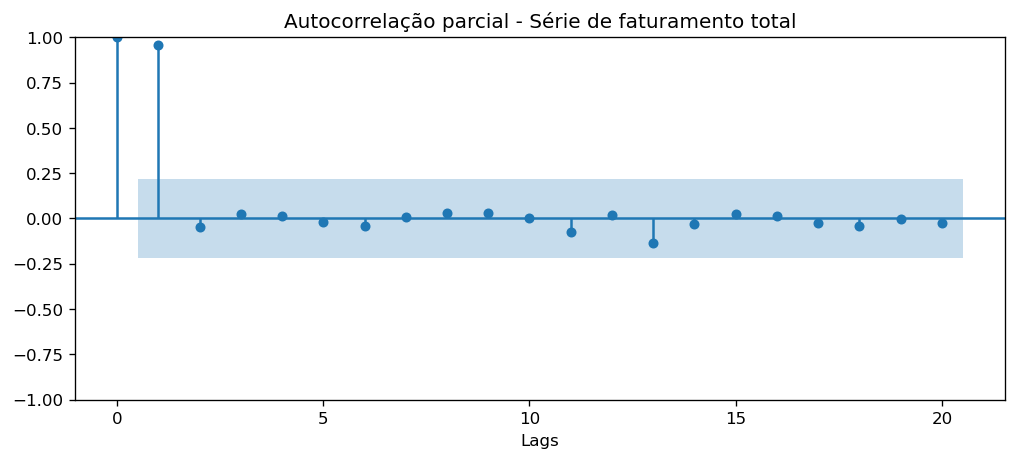

In [33]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title('Autocorrelação parcial - Série de faturamento total')
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

In [34]:
arimas = {}
arimas['total'] = auto_arima(
    y = total_train,
    start_p = 1, max_p = 3,
    d = 2, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=1799.693, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=1800.522, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=1800.650, Time=0.11 sec
 ARIMA(0,2,0)(1,1,0)[12]             : AIC=1798.664, Time=0.05 sec
 ARIMA(0,2,0)(2,1,0)[12]             : AIC=1799.958, Time=0.29 sec
 ARIMA(0,2,0)(1,1,1)[12]             : AIC=1797.055, Time=0.31 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=1801.181, Time=0.05 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=inf, Time=1.26 sec
 ARIMA(0,2,0)(1,1,2)[12]             : AIC=1798.612, Time=1.48 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=1798.699, Time=0.17 sec
 ARIMA(0,2,0)(2,1,2)[12]             : AIC=1801.126, Time=1.21 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=1798.847, Time=0.37 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=1798.794, Time=0.40 sec
 ARIMA(0,2,0)(1,1,1)[12] inte

In [35]:
modelo_corrente = ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = False).fit(y = total_train)

modelo_funcional = [
    ARIMA(order = (0, 1, 0), seasonal_order = (0, 1, 0, 12), with_intercept = False).fit(y = total_train),
    ARIMA(order = (0, 2, 3), seasonal_order = (2, 1, 1, 12), with_intercept = False).fit(y = total_train),
    ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = False).fit(y = total_train),
    ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = True).fit(y = total_train),
]

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Progr

In [40]:
arimas['total'] = ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = True).fit(y = total_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [41]:
arimas['total'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   66
Model:             SARIMAX(0, 2, 0)x(1, 1, [1], 12)   Log Likelihood                -895.646
Date:                              Tue, 23 Nov 2021   AIC                           1799.292
Time:                                      11:35:04   BIC                           1807.097
Sample:                                           0   HQIC                          1802.285
                                               - 66                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.528e+04   1.38e-07   4.01e+11      0.000    5.53e+04    5.53e+04
ar.S.L12       0.7644      0.318      2.407      0.016       0.142       1.387
ma.S.L12      -0.7437      0.299     -2.487      0.013      -1.330      -0.158
sigma2      5.863e+13   4.34e-15   1.35e+28      0.000    5.86e+13    5.86e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.85   Jarque-Bera (JB):                52.52
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             1.11
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.29e+43. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

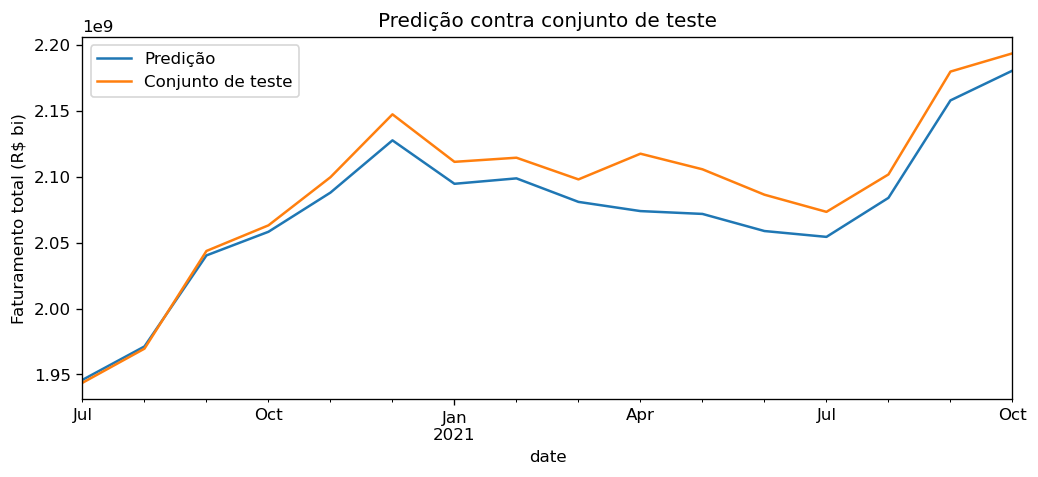

In [42]:
n_test_periods = total_test.shape[0]
arr_preds = arimas['total'].predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = total_test.index[0], periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
total_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [44]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds,
    n = total_train.shape[0],
    dof = arimas['total'].df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 0.797%
       RMSE: 2.015e+07
        MAE: 1.683e+07


## Modelo final

Vamos agora resumir o modelo final do faturamento total

## Modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`)

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

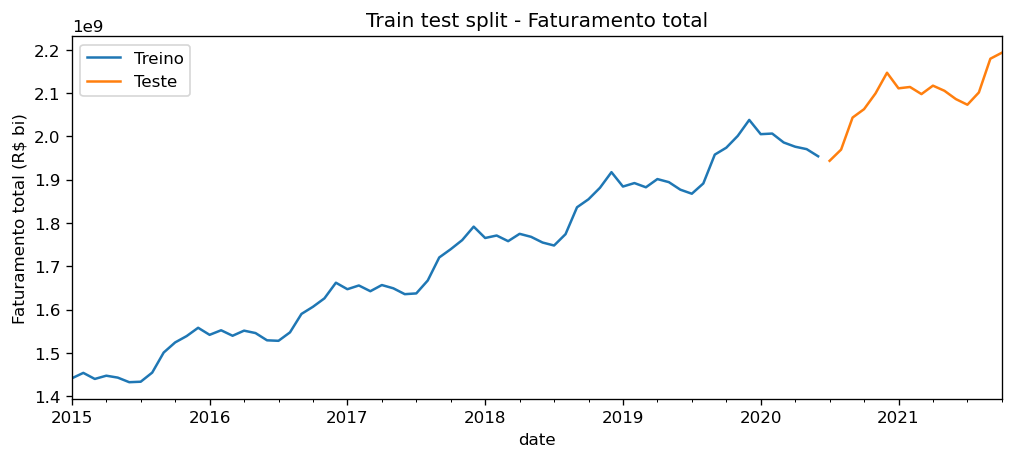

In [45]:
# excluindo o período pré-2015

train_test_split_idx = int(fat_modelo.shape[0] * 0.8 + 1)
total_train = fat_modelo[:train_test_split_idx]
total_test = fat_modelo[train_test_split_idx:]

total_train.plot(label = 'Treino')
total_test.plot(label = 'Teste')
plt.title('Train test split - Faturamento total')
plt.ylabel('Faturamento total (R$ bi)')
plt.legend()
plt.show()

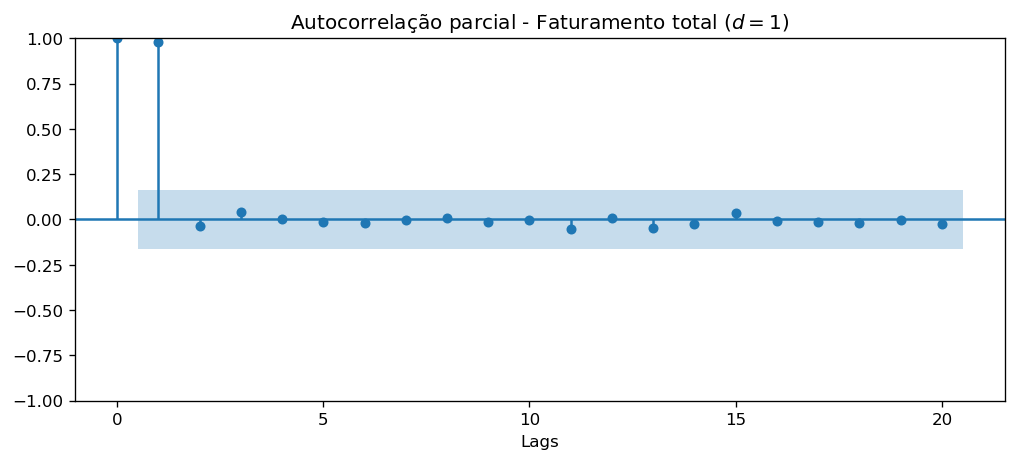

In [46]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_total, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento total ($d = 1$)")
plt.show()

In [7]:
# arimas = {}
# arimas['total'] = auto_arima(
#     y = total_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True
#     #alpha = 0.05
# )

In [47]:
modelo = ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = True).fit(y = total_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [48]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   66
Model:             SARIMAX(0, 2, 0)x(1, 1, [1], 12)   Log Likelihood                -895.646
Date:                              Tue, 23 Nov 2021   AIC                           1799.292
Time:                                      11:36:30   BIC                           1807.097
Sample:                                           0   HQIC                          1802.285
                                               - 66                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.528e+04   1.38e-07   4.01e+11      0.000    5.53e+04    5.53e+04
ar.S.L12       0.7644      0.318      2.407      0.016       0.142       1.387
ma.S.L12      -0.7437      0.299     -2.487      0.013      -1.330      -0.158
sigma2      5.863e+13   4.34e-15   1.35e+28      0.000    5.86e+13    5.86e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.85   Jarque-Bera (JB):                52.52
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             1.11
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.29e+43. Standard errors may be unstable.
"""

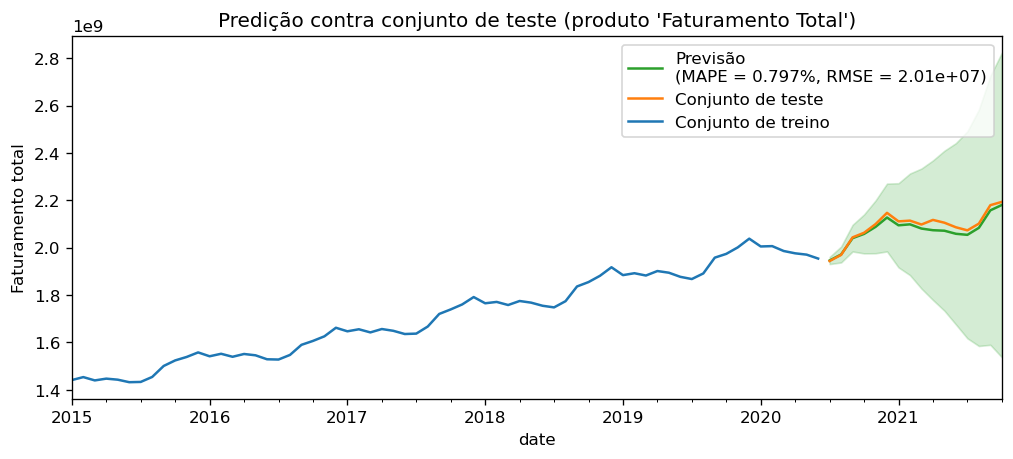

In [49]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = 'Faturamento Total',
    serie_treino = total_train,
    serie_teste = total_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar algumas métricas ao modelo:

In [50]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds
)

metricas = dict(
    total = dict(
        mape = smape(**kwargs_total),
        rmse = np.sqrt(smse(**kwargs_total)),
        mae = smae(**kwargs_total)
    )
)

mape = metricas['total']['mape']
rmse = metricas['total']['rmse']
mae = metricas['total']['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 0.797%
RMSE: 2.015e+07
 MAE: 1.683e+07


Vamos salvar o modelo atual para o faturamento total.

In [51]:
modelo_dict = dict(
    modelo = modelo.fit(total_train),
    serie_treino = total_train
)

with open(r'total.model', 'wb') as modelo_total:
    pickler = pickle.Pickler(file = modelo_total)
    pickler.dump(modelo_dict)


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# 3 - Análise de Séries Temporais - Faturamento do produto `alimenticio`

## Importação dos dados

In [53]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'alimenticio'
fat = tswide[analise_produto].dropna()

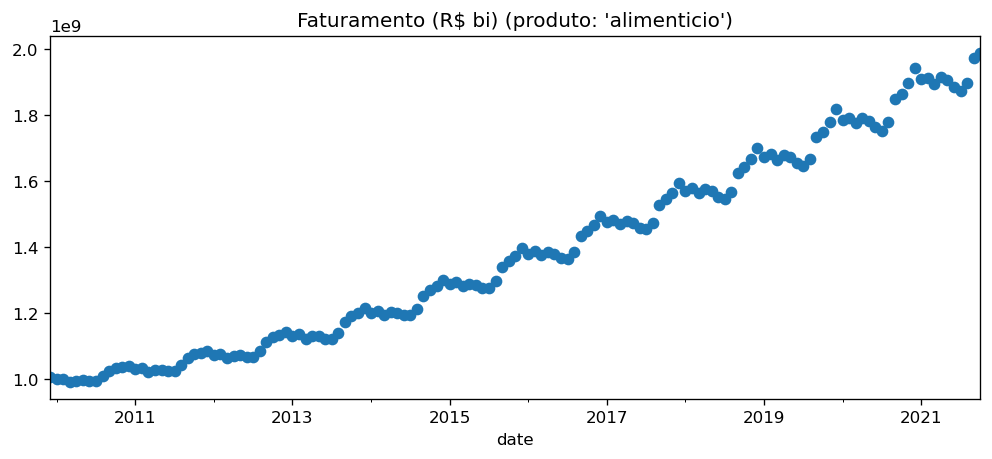

In [54]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ bi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória - produto `alimenticio`

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [55]:
fat.describe()

count    1.430000e+02
mean     1.387476e+09
std      2.965446e+08
min      9.900000e+08
25%      1.122228e+09
50%      1.364441e+09
75%      1.644394e+09
max      1.990000e+09
Name: alimenticio, dtype: float64

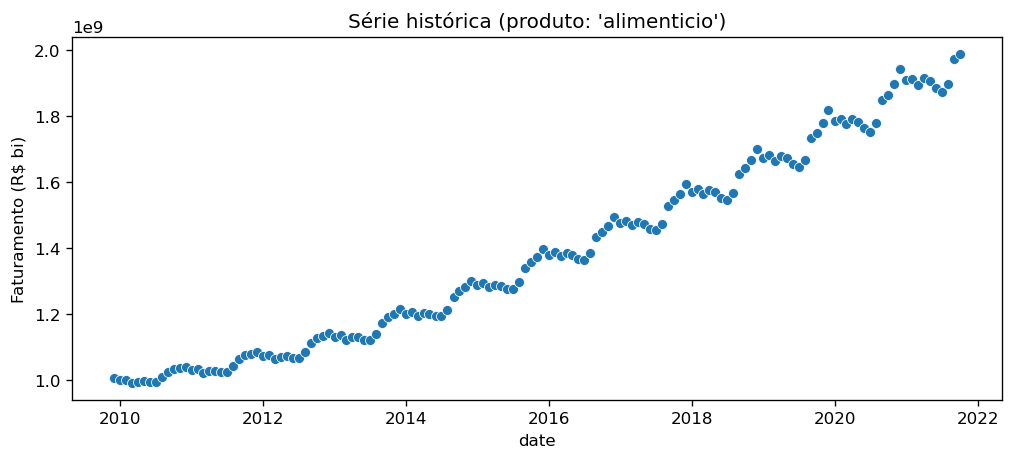

In [56]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ bi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

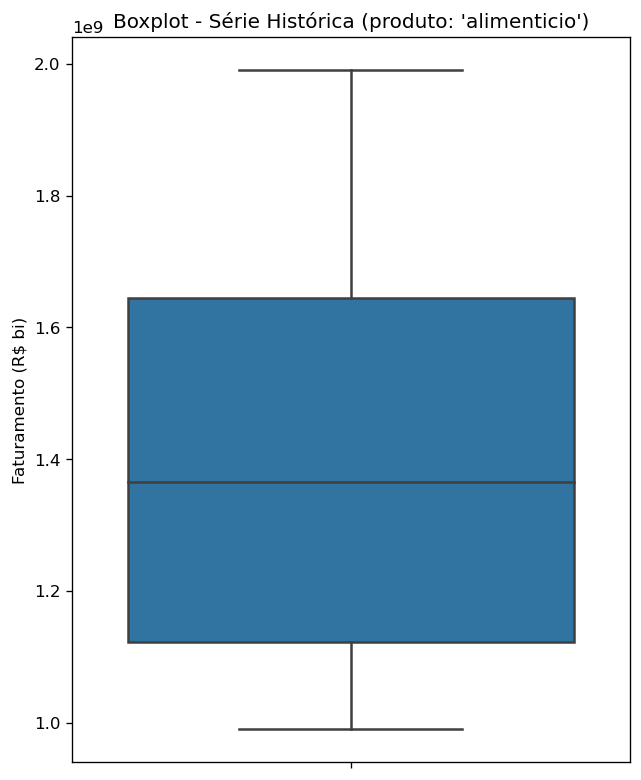

In [57]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

In [58]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ bi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [59]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.754887e+09
std      1.276560e+08
min      1.545698e+09
25%      1.665024e+09
50%      1.765983e+09
75%      1.872678e+09
max      1.990000e+09
Name: alimenticio, dtype: float64

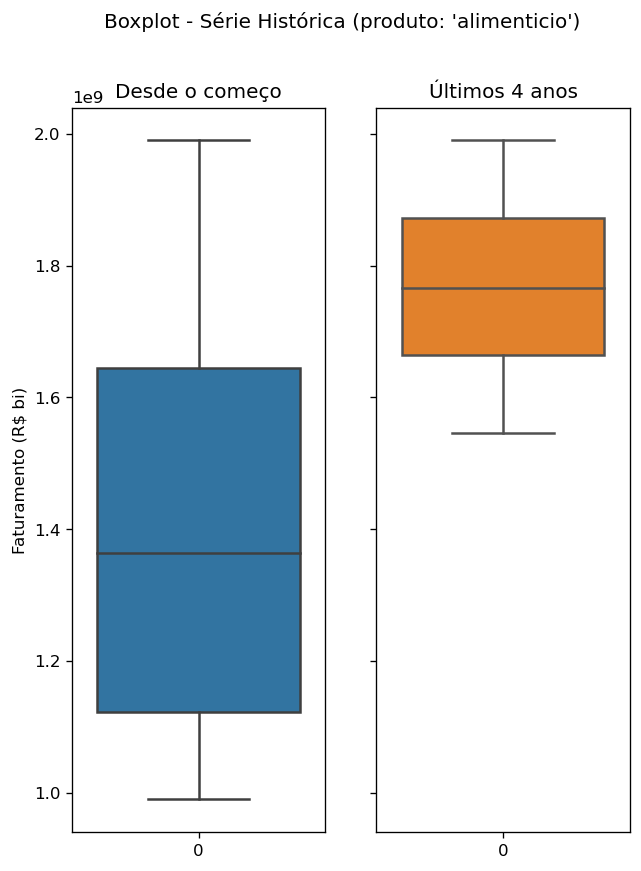

In [60]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

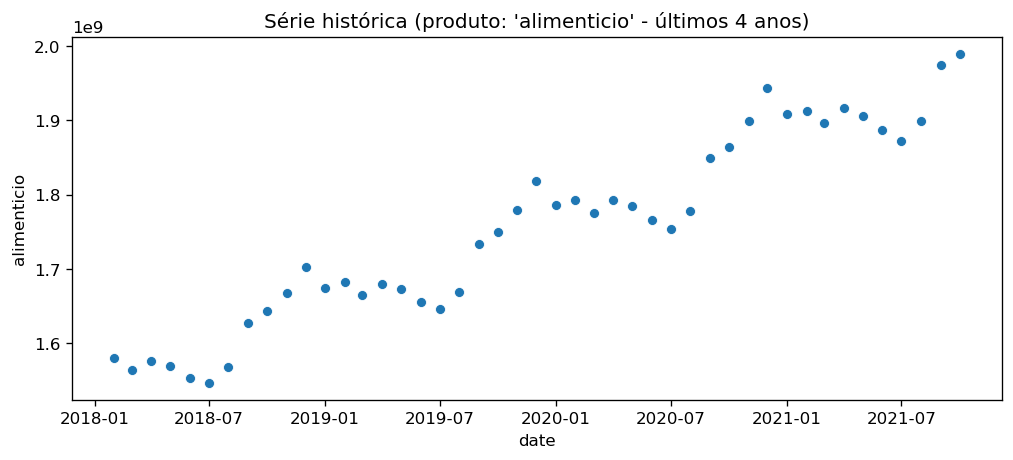

In [61]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

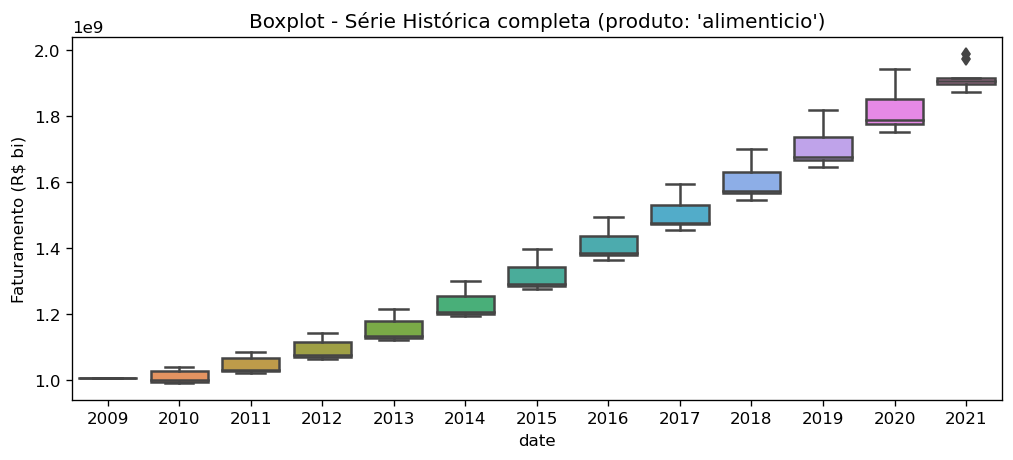

In [62]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

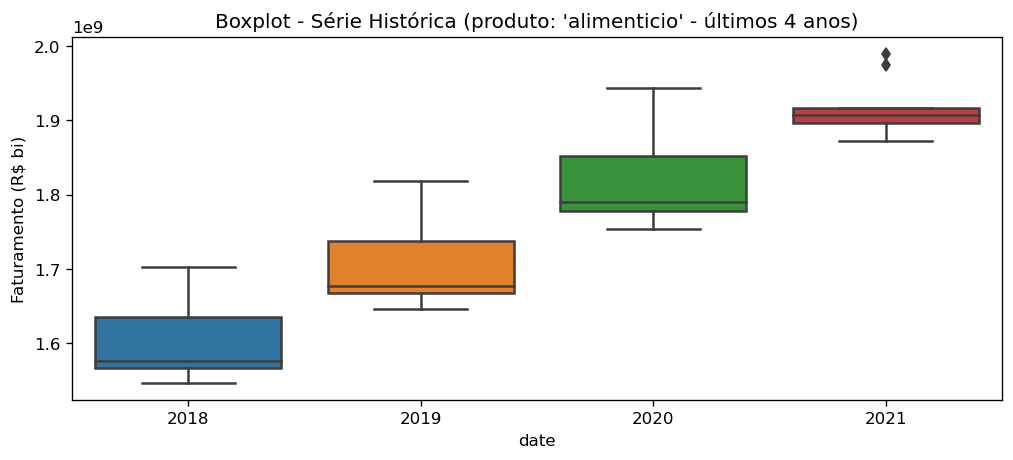

In [63]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

Observamos o mesmo efeito que no faturamento total - há aparentes *outliers* em 2021 por conta de a série neste ano não estar completa.

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [64]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

In [65]:
testedf = adfuller(fat)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 99.613% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

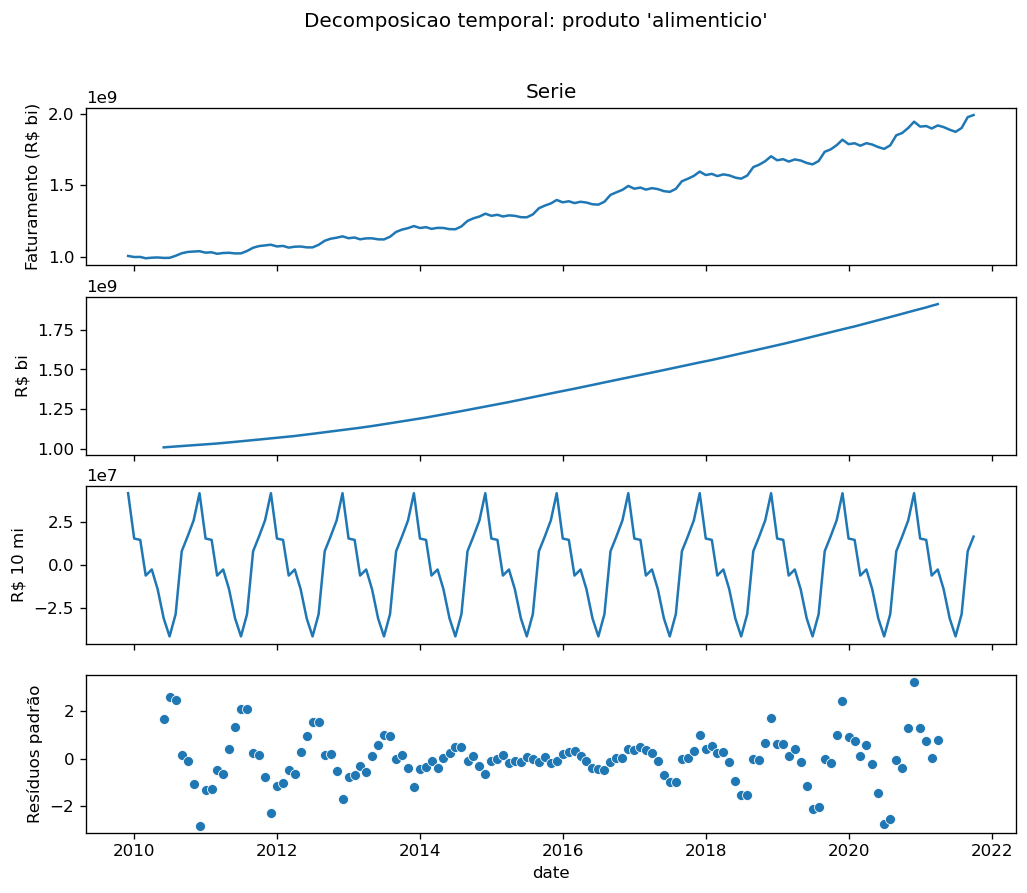

In [66]:
decomps[analise_produto] = seasonal_decompose(fat)
decomp = decomps[analise_produto]

fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

ts_filtro = tsd[analise_produto]
i = i_palette[analise_produto]
c = seaborn_palette[i]

sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
axs[0].set_title('Serie')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.lineplot(data = decomp.trend, ax = axs[1], color = c)
axs[1].set_ylabel('R$ bi')

sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)
axs[2].set_ylabel('R$ 10 mi')

resid_standard = (decomp.resid - decomp.resid.mean()) / decomp.resid.std()
sns.scatterplot(data = resid_standard, ax = axs[3], color = c)
axs[3].set_ylabel('Resíduos padrão')

fig.suptitle(f"Decomposicao temporal: produto '{analise_produto}'")
plt.show()

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos não estão distribuídos aleatoriamente (apresentam um padrão oscilatório).

É necessário um modelo mais complexo.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

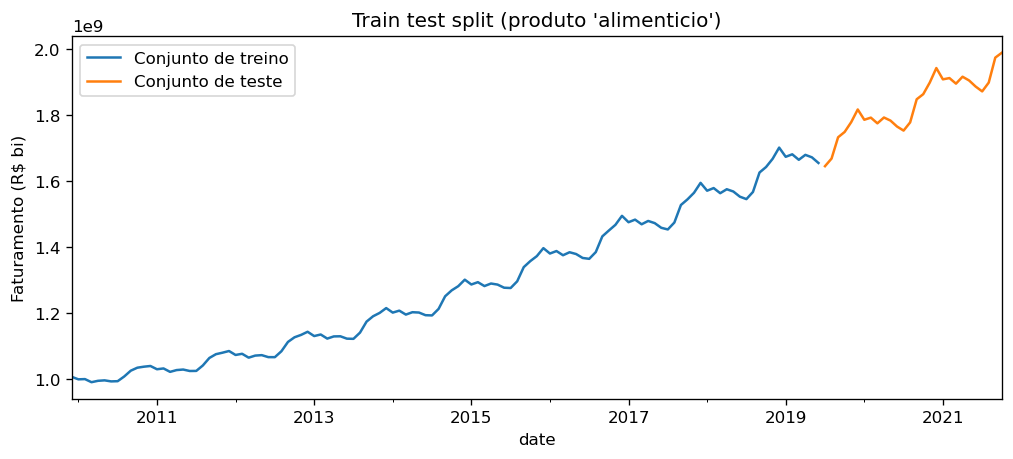

In [67]:
train_test_split_idx = int(fat.shape[0] * 0.8 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) devem ser ao menos 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

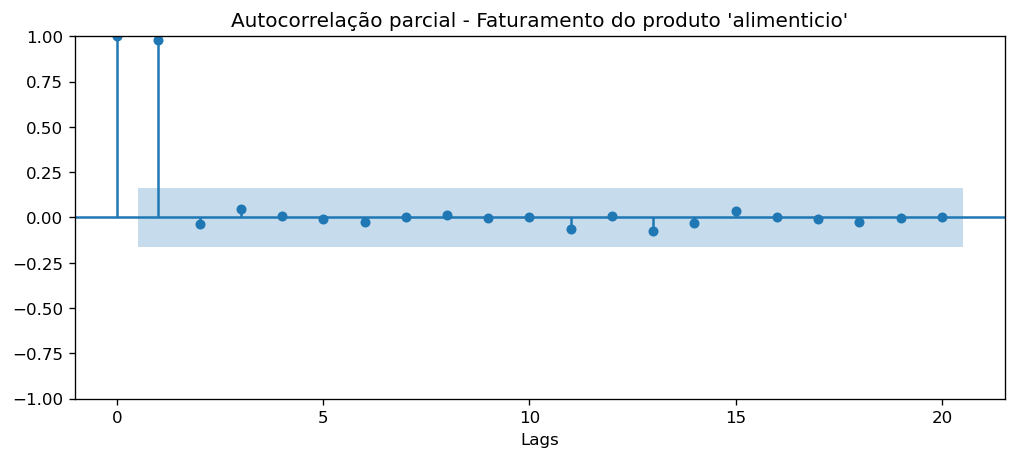

In [68]:
fig = plt.figure()
ax = fig.gca()

plot_acf(fat, lags = 20, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação - Faturamento do produto '{analise_produto}'")
plt.show()

fig = plt.figure()
ax = fig.gca()

plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()



Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d = 1$.

In [69]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 2, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,2,1)[12]             : AIC=2670.983, Time=1.55 sec
 ARIMA(0,2,0)(0,2,0)[12]             : AIC=2665.566, Time=0.15 sec
 ARIMA(1,2,0)(1,2,0)[12]             : AIC=2664.994, Time=0.56 sec
 ARIMA(0,2,1)(0,2,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(1,2,0)(0,2,0)[12]             : AIC=2663.310, Time=0.07 sec
 ARIMA(1,2,0)(0,2,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,2,0)(1,2,1)[12]             : AIC=2666.945, Time=0.82 sec
 ARIMA(2,2,0)(0,2,0)[12]             : AIC=2667.290, Time=0.35 sec
 ARIMA(1,2,1)(0,2,0)[12]             : AIC=2667.379, Time=0.16 sec
 ARIMA(0,2,1)(0,2,0)[12]             : AIC=2663.779, Time=0.20 sec
 ARIMA(2,2,1)(0,2,0)[12]             : AIC=2669.057, Time=0.39 sec
 ARIMA(1,2,0)(0,2,0)[12] intercept   : AIC=2665.300, Time=0.11 sec

Best model:  ARIMA(1,2,0)(0,2,0)[12]          
Total fit time: 6.351 seconds


In [70]:
modelos_aceitaveis = [
    ARIMA(order = (1, 2, 0), seasonal_order=(0, 2, 0, 12), with_intercept = False).fit(y = fat_train)
]

In [71]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 2, 0)x(0, 2, 0, 12)   Log Likelihood               -1329.655
Date:                            Tue, 23 Nov 2021   AIC                           2663.310
Time:                                    11:39:59   BIC                           2668.287
Sample:                                         0   HQIC                          2665.316
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009      0.045      0.020      0.984      -0.087       0.089
sigma2      5.075e+11   5.86e-15   8.66e+25      0.000    5.08e+11    5.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.96   Skew:                             0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+42. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

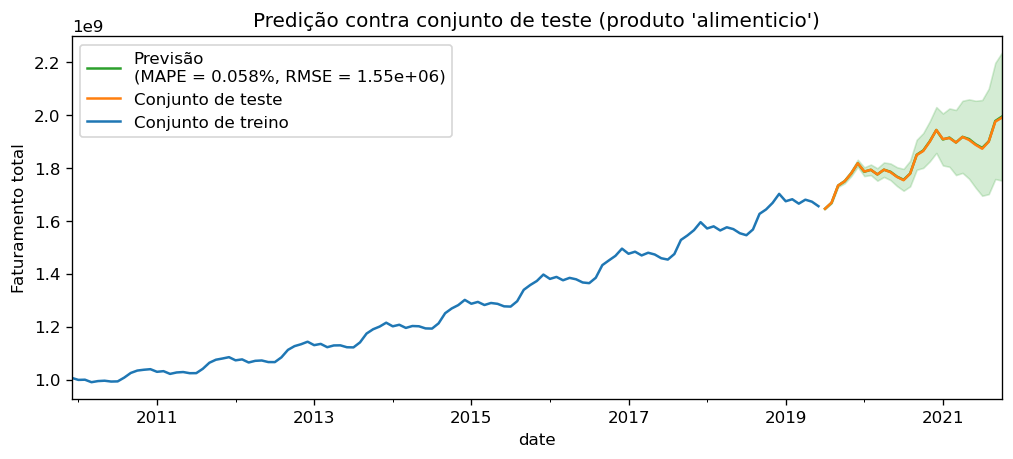

In [72]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar algumas métricas quantitativas ao modelo:

In [73]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 0.058%
       RMSE: 1.553e+06
        MAE: 1.087e+06


## Modelo final

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`)

In [74]:
analise_produto = 'alimenticio'
fat = tswide['alimenticio'].dropna()

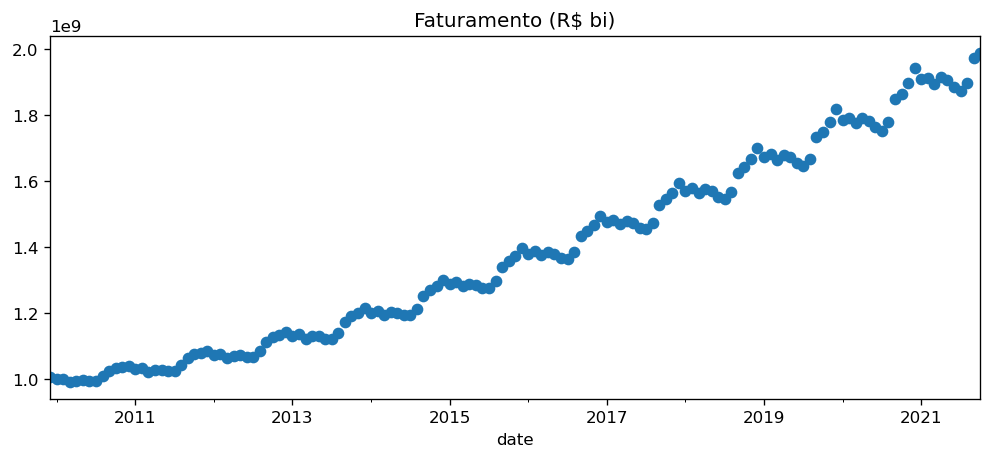

In [75]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

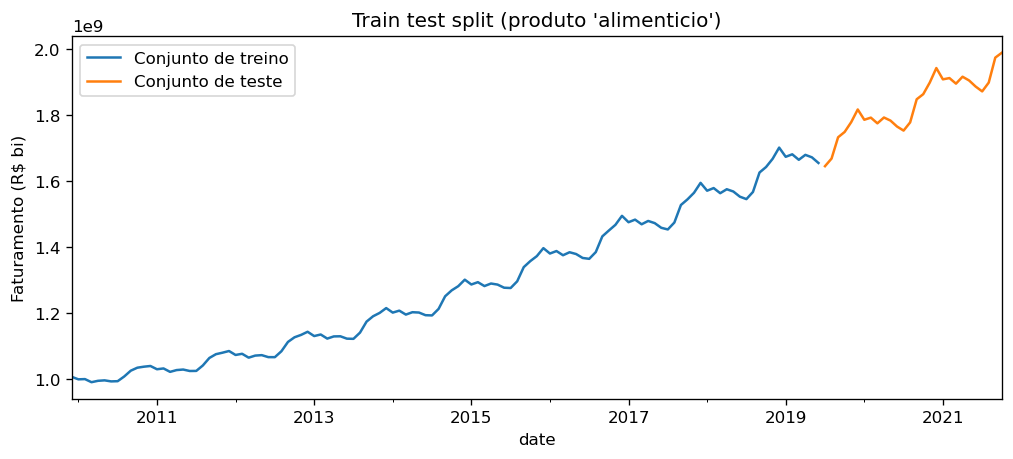

In [76]:
train_test_split_idx = int(fat.shape[0] * 0.8 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

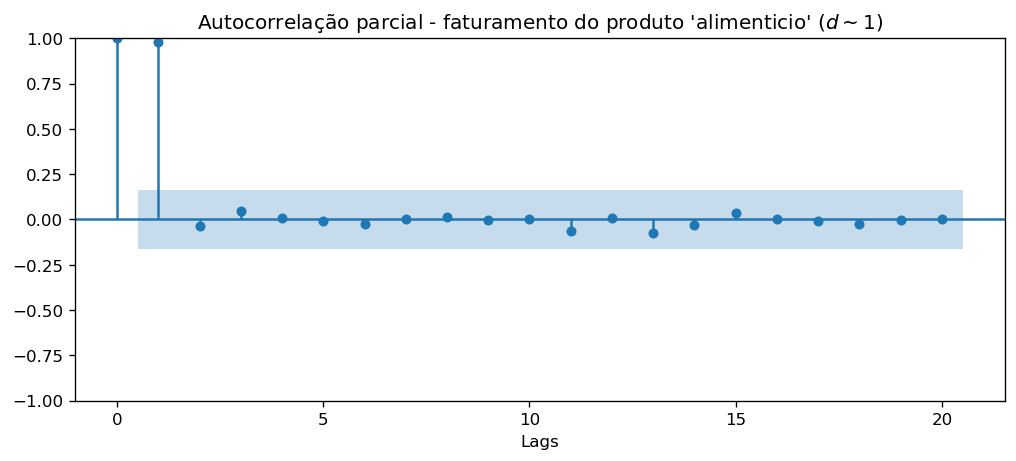

In [77]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

In [78]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [79]:
modelo = ARIMA(order = (1, 2, 0), seasonal_order = (0, 2, 0, 12), with_intercept = False).fit(y = fat_train)

In [80]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 2, 0)x(0, 2, 0, 12)   Log Likelihood               -1329.655
Date:                            Tue, 23 Nov 2021   AIC                           2663.310
Time:                                    11:41:45   BIC                           2668.287
Sample:                                         0   HQIC                          2665.316
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0009      0.045      0.020      0.984      -0.087       0.089
sigma2      5.075e+11   5.86e-15   8.66e+25      0.000    5.08e+11    5.08e+11
===================================================================================
Ljung-Box (L1) (Q):                   8.38   Jarque-Bera (JB):                 2.10
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               1.96   Skew:                             0.28
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+42. Standard errors may be unstable.
"""

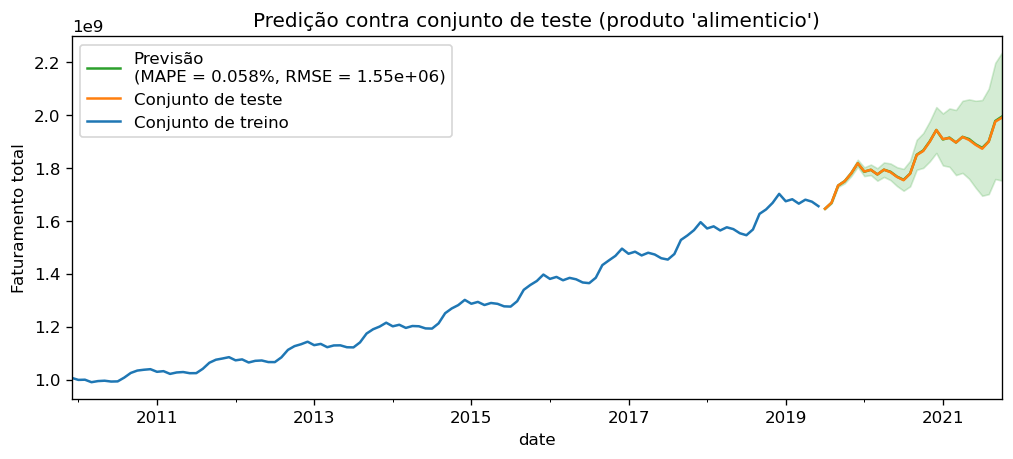

In [81]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

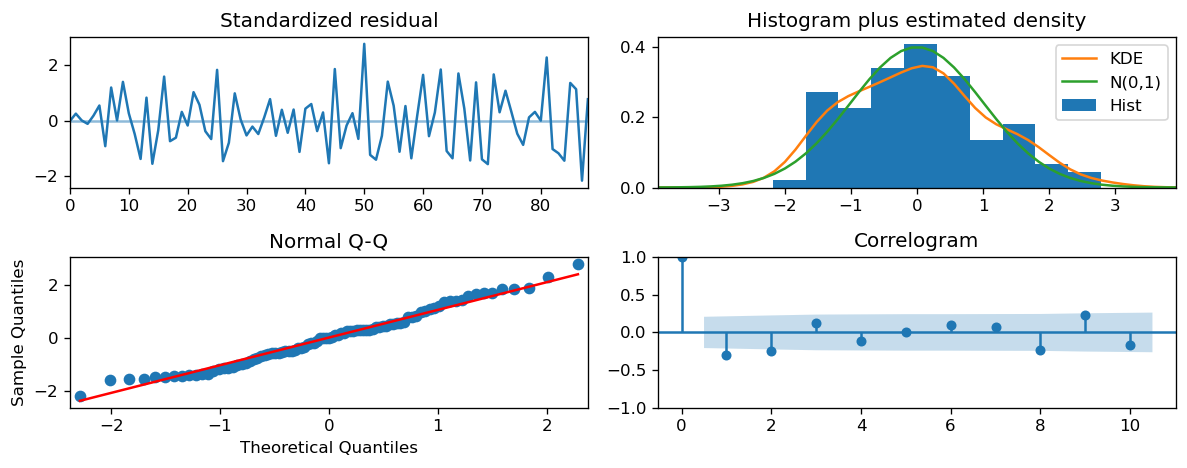

In [82]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [83]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.058%
       RMSE: 1.553e+06
        MAE: 1.087e+06


Vamos salvar o modelo atual para o faturamento do produto `alimenticio`.

In [84]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)


with open(r'produto_alimenticio.model', 'wb') as arq_modelo_alimenticio:
    pickler = pickle.Pickler(file = arq_modelo_alimenticio)
    pickler.dump(modelo_dict)


# 4 - Análise de Séries Temporais - Faturamento do produto `transporte`

## Importação dos dados

In [86]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'transporte'
fat = tswide[analise_produto].dropna()

In [87]:
fat

date
2015-01-01    1.532707e+08
2015-02-01    1.590025e+08
2015-03-01    1.570495e+08
2015-04-01    1.572236e+08
2015-05-01    1.559886e+08
                  ...     
2021-06-01    1.735395e+08
2021-07-01    1.737046e+08
2021-08-01    1.759447e+08
2021-09-01    1.761901e+08
2021-10-01    1.768986e+08
Freq: MS, Name: transporte, Length: 82, dtype: float64

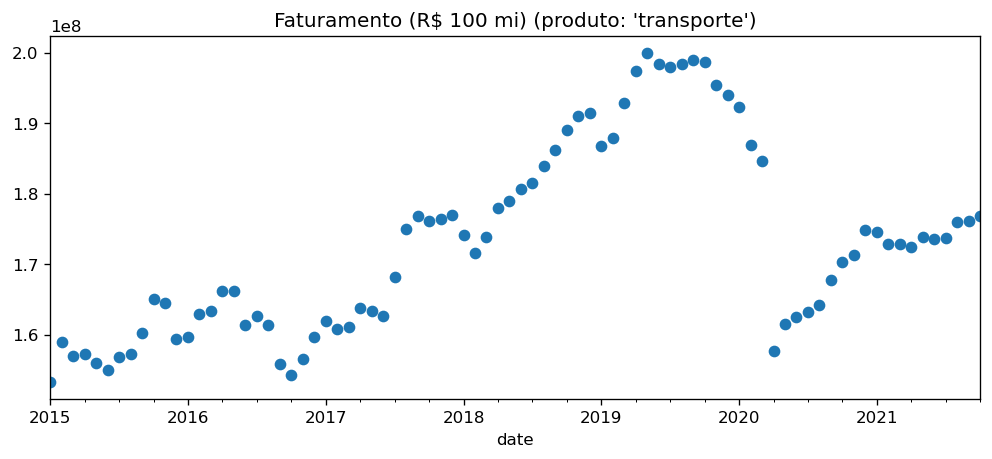

In [88]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ 100 mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [89]:
fat.describe()

count    8.200000e+01
mean     1.729469e+08
std      1.340913e+07
min      1.532707e+08
25%      1.616310e+08
50%      1.726690e+08
75%      1.812734e+08
max      2.000000e+08
Name: transporte, dtype: float64

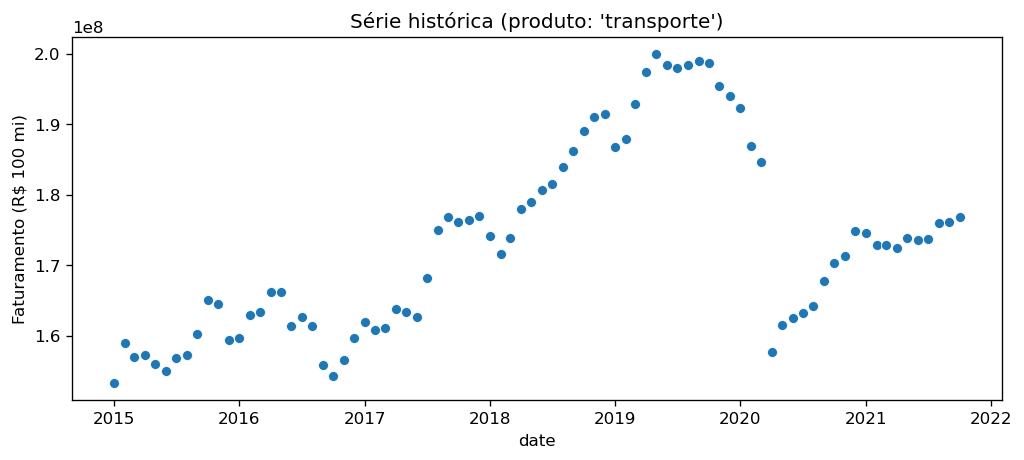

In [90]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

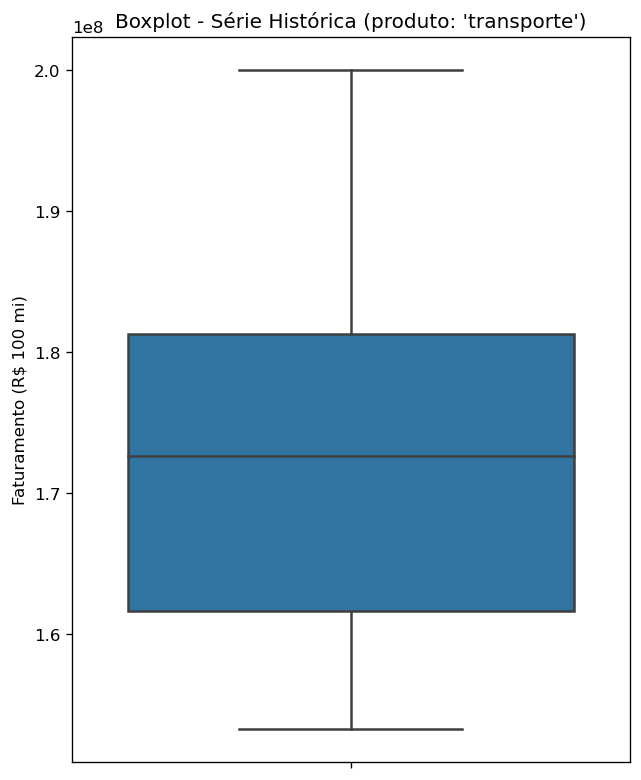

In [91]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

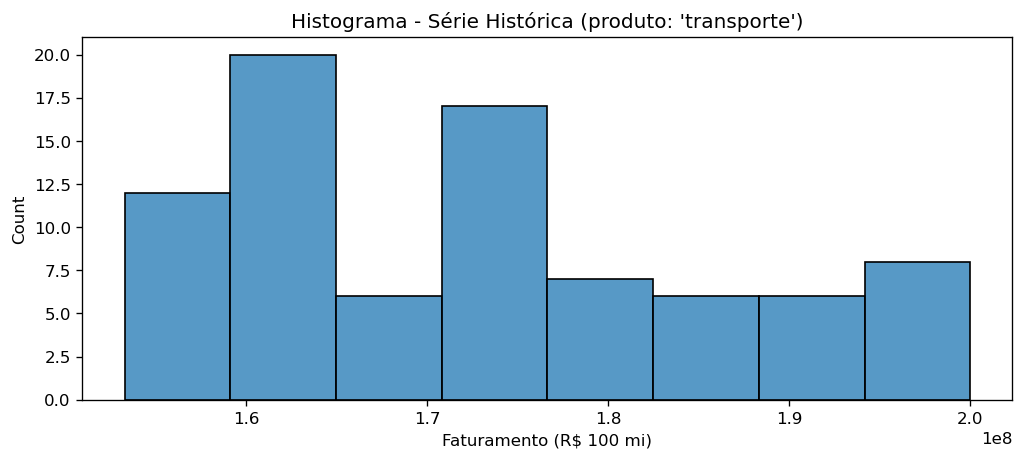

In [92]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ 100 mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa é irregular, sem padrões distintos. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [93]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.811789e+08
std      1.182049e+07
min      1.576376e+08
25%      1.729163e+08
50%      1.789437e+08
75%      1.914235e+08
max      2.000000e+08
Name: transporte, dtype: float64

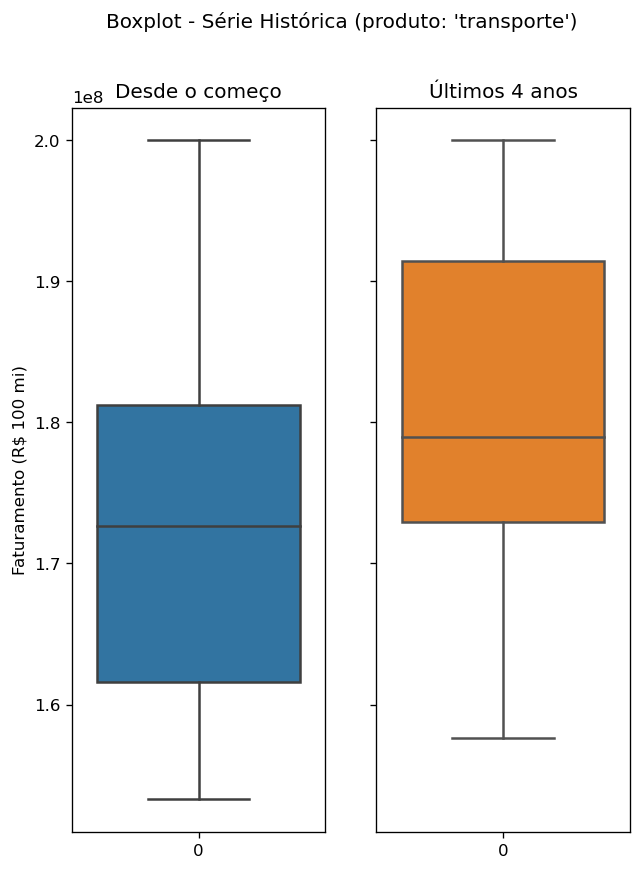

In [94]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ 100 mi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

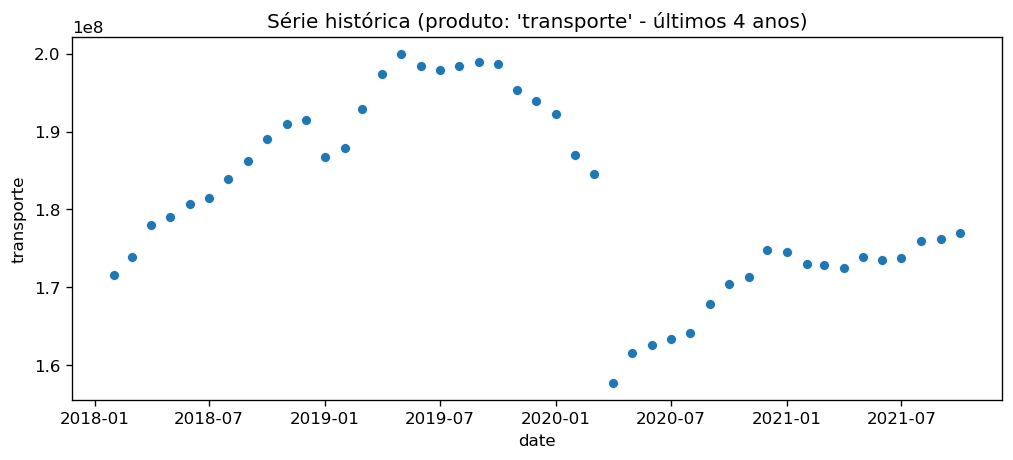

In [95]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

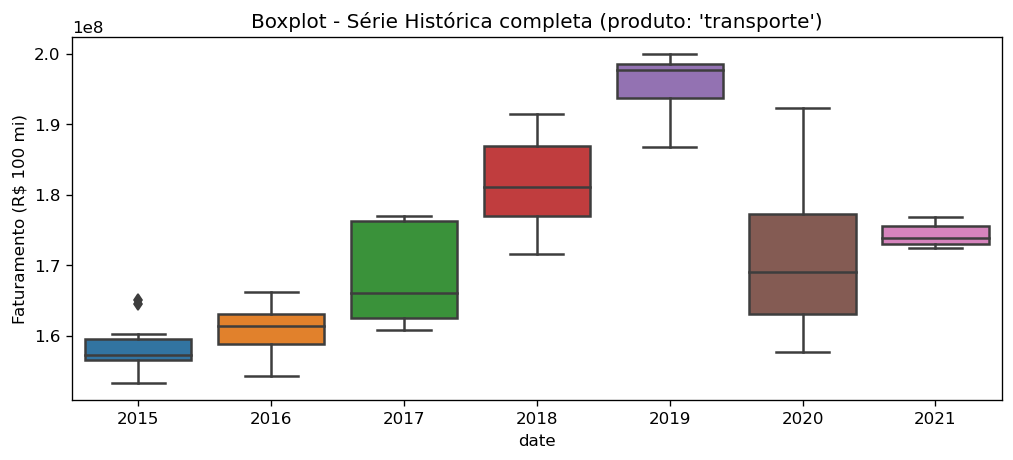

In [96]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

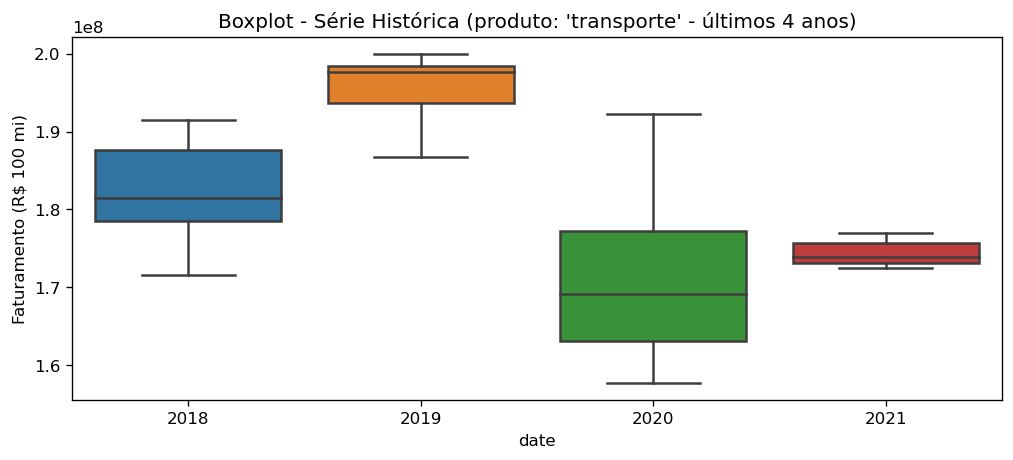

In [97]:
sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

O faturamento do produto `transporte` sofreu bastante com a pandemia. Por conta disso, os possíveis *outliers* de 2015 são efetivamente irrelevantes. Teremos que ser criativos para modelar a série aceitavelmente.

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [98]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

In [99]:
testedf = adfuller(fat)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 41.492% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Essa conclusão se mantém mesmo se separarmos a série entre pré- e pós-pandemia:

In [101]:
# pré-pandemia
testedf = adfuller(fat[:'2020-01'])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 87.788% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


In [100]:
# pós-pandemia
testedf = adfuller(fat['2020-06':])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 94.070% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

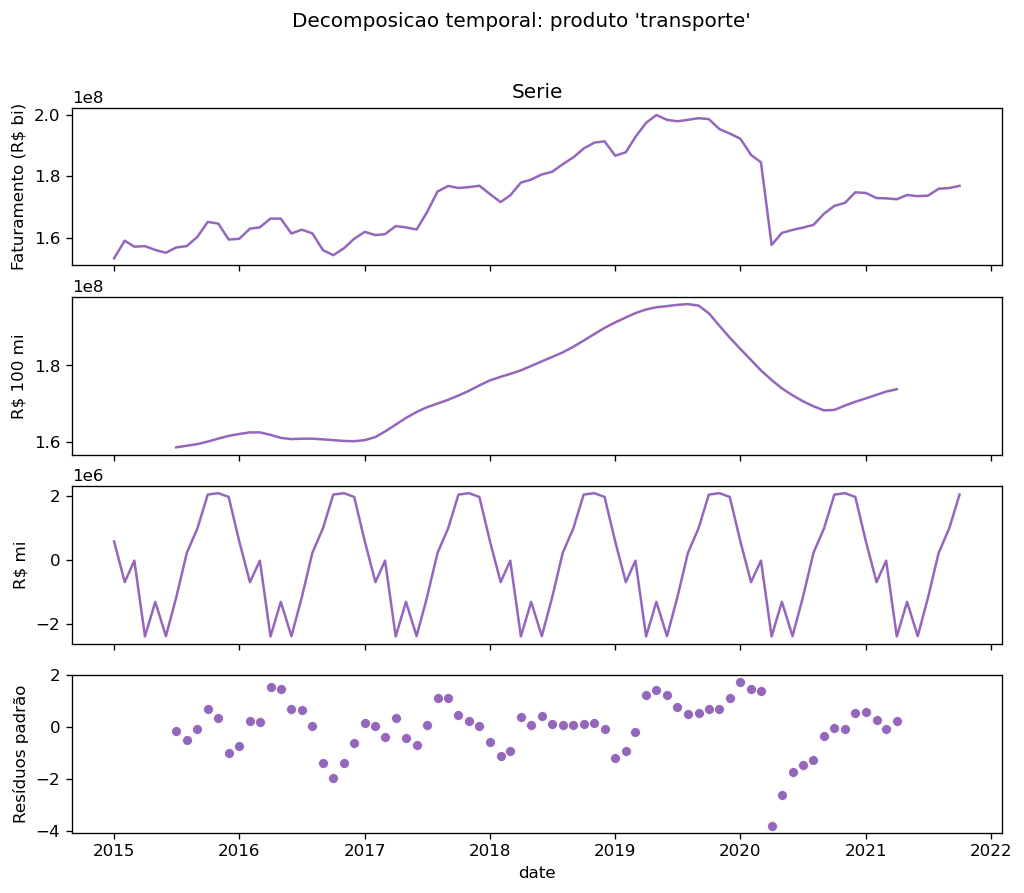

In [102]:
decomp = seasonal_decompose(fat)

fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

ts_filtro = tsd[analise_produto]
i = i_palette[analise_produto]
c = seaborn_palette[i]

sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
axs[0].set_title('Serie')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.lineplot(data = decomp.trend, ax = axs[1], color = c)
axs[1].set_ylabel('R$ 100 mi')

sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)
axs[2].set_ylabel('R$ mi')

resid_standard = (decomp.resid - decomp.resid.mean()) / decomp.resid.std()
sns.scatterplot(data = resid_standard, ax = axs[3], color = c)
axs[3].set_ylabel('Resíduos padrão')

fig.suptitle(f"Decomposicao temporal: produto '{analise_produto}'")
plt.show()

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos não estão distribuídos aleatoriamente (apresentam um padrão oscilatório).

Vejamos o que acontece se separarmos as séries entre pré- e pós-pandemia:

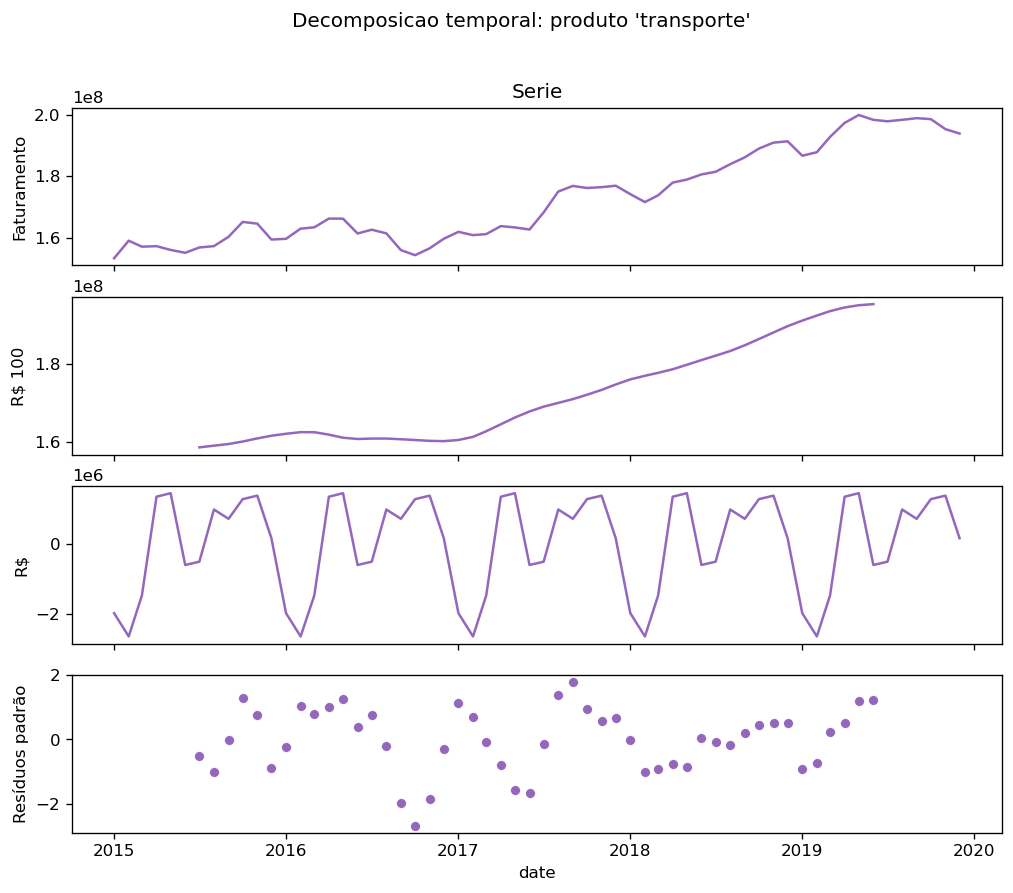

In [103]:
# pré-pandemia
decomp_pre = py_scripts.plots.decomp_fourier(serie_fat = fat[:'2020-01'].iloc[:-1], produto = analise_produto, c = c)

In [104]:
# pós-pandemia
decomp_pos = py_scripts.plots.decomp_fourier(serie_fat = fat['2020-04':], produto = analise_produto, c = c)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 19 observation(s)

Nos dois últimos gráficos, há um padrão cíclico visível na série de resíduos. A decomposição em séries de Fourier não é o modelo mais adequado.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

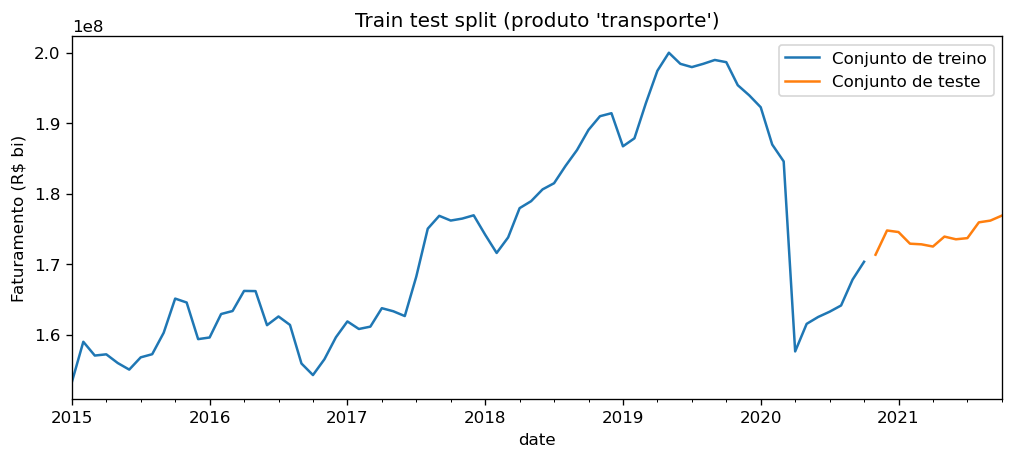

In [105]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

train_test_split_idx = int(fat.shape[0] * 0.85 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

De cara **já vemos que a série azul e a série em laranja não cabem em um mesmo modelo**. Houve uma quebra estrutural na série; a partir de março de 2020, os eventos geradores da série são fundamentalmente diferentes dos de antes dessa data.

Mesmo assim vamos prosseguir com a análise para verificar isso quantitativamente.

Já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) devem ser ao menos 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

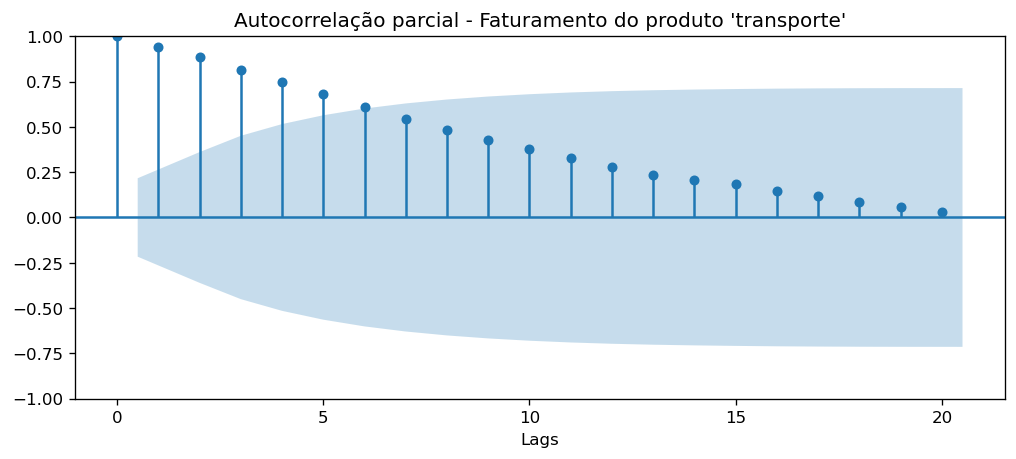

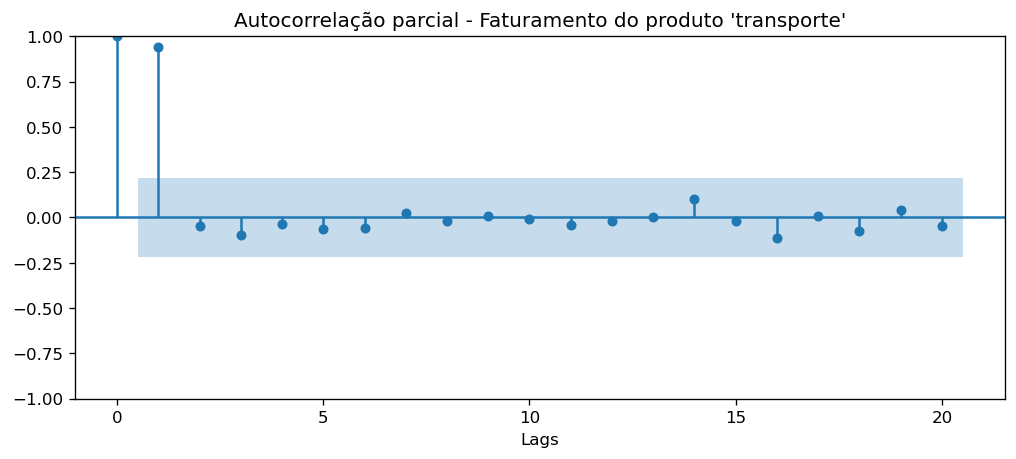

In [106]:
fig = plt.figure()
ax = fig.gca()
plot_acf(fat, lags = 20, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

In [107]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 3,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2311.409, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2305.842, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2307.610, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2307.629, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2304.083, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2307.824, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2307.824, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2309.783, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2305.625, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2305.646, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2307.474, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.372 seconds


In [108]:
modelo = ARIMA(order = (0, 1, 0), seasonar_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [109]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1150.921
Date:                Tue, 23 Nov 2021   AIC                           2305.842
Time:                        11:47:10   BIC                           2310.310
Sample:                             0   HQIC                          2307.615
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.475e+05   7.98e+05      0.310      0.756   -1.32e+06    1.81e+06
sigma2      1.801e+13   1.38e+12     13.010      0.000    1.53e+13    2.07e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1541.76
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                            -3.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

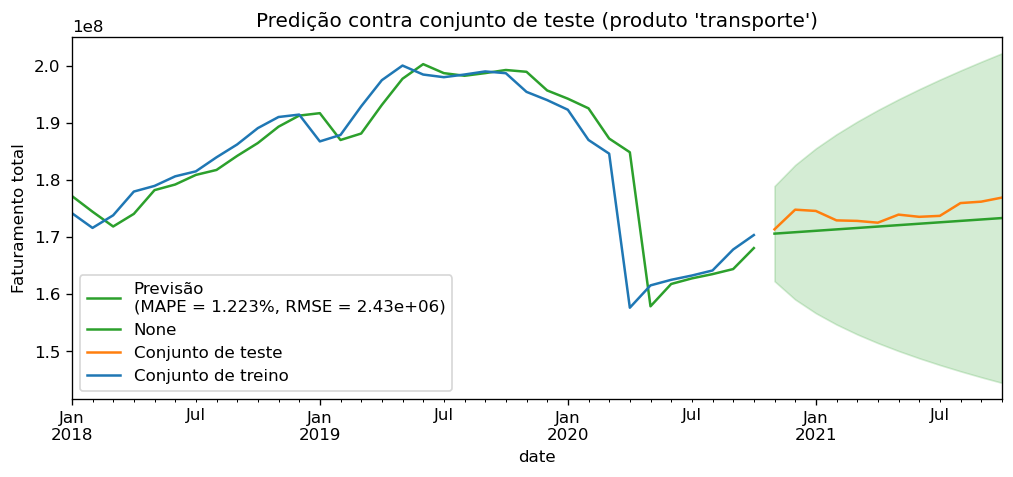

In [110]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train['2018':],
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

As métricas não estão tão ruins como esperado. No entanto, como falado acima, o conjunto de treino e o conjunto de teste claramente não exatamente cabem em um modelo único.

Em seguida modelaremos apenas a série pós pandemia.

## Modelo autorregressivo - Pós-pandemia

In [111]:
fat_pp = fat['2020-04':]

train_test_split_idx = int(fat_pp.shape[0] * 0.6 + 1)
fat_train = fat_pp[:train_test_split_idx]
fat_test = fat_pp[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

Agora as séries parecem parte de um mesmo modelo. No entanto, **parece haver bem poucos dados**.

Vamos determinar a estacionariedade da série:

In [112]:
testedf = adfuller(fat_pp)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 2.974% < 5%
    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.


A série é estacionária, logo em princípio é válido fazer uma decomposição em série de Fourier. No entanto, há poucos dados para tal.

In [113]:
py_scripts.plots.decomp_fourier(serie_fat = fat_pp, produto = analise_produto, c = c)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 19 observation(s)

Já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) podem ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

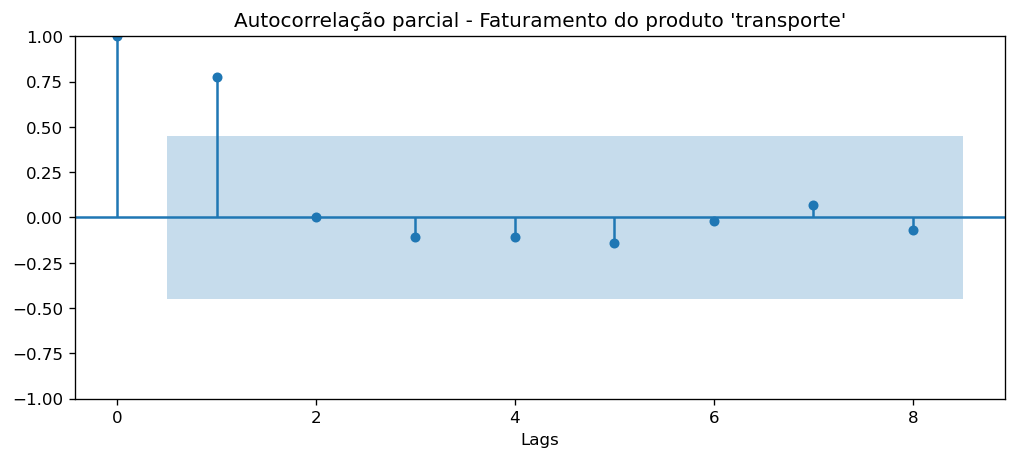

In [114]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_pp, lags = 8, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

Há indícios conflitantes, mas podemos testar todos os `d`s e ver qual mais se ajusta.

In [115]:
modelo_pp = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 0, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500
)


ValueError: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.

Vamos ver se o modelo anterior é válido para o pós-pandemia:

In [116]:
modelo_pp = ARIMA(order = (0, 1, 0), with_intercept = True).fit(y = fat_train)

In [117]:
modelo_pp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -173.463
Date:                Tue, 23 Nov 2021   AIC                            350.925
Time:                        11:47:58   BIC                            351.721
Sample:                             0   HQIC                           350.423
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.381e+06   5.15e+05      2.679      0.007    3.71e+05    2.39e+06
sigma2      2.915e+12   1.79e+12      1.630      0.103   -5.89e+11    6.42e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.49   Prob(JB):                         0.78
Heteroskedasticity (H):               2.53   Skew:                             0.05
Prob(H) (two-sided):                  0.39   Kurtosis:                         1.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

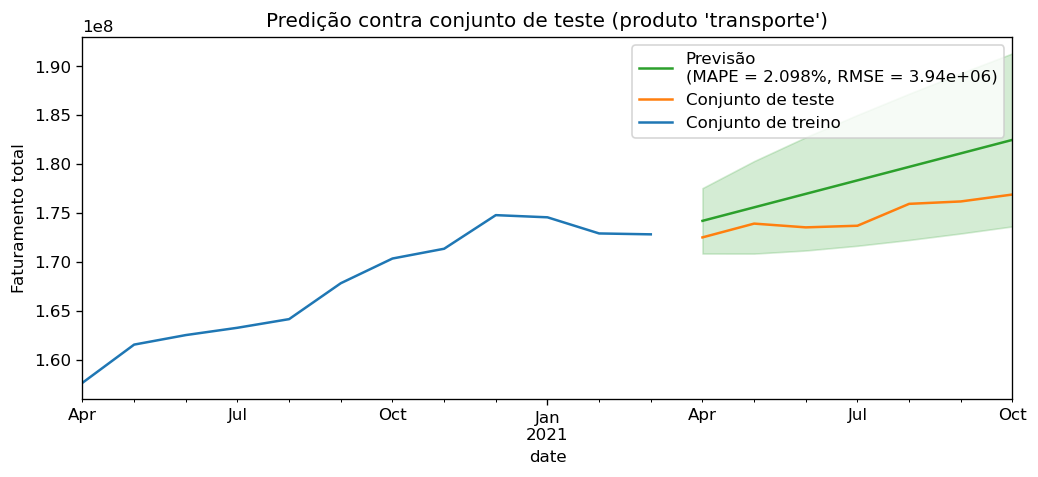

In [118]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_pp, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

In [119]:

modelo.plot_diagnostics(figsize = (10, 8))
plt.tight_layout()
plt.show()

In [120]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 2.098%
       RMSE: 3.941e+06
        MAE: 3.674e+06


Como dissemos acima, os dados que temos não são suficientes para ajustarmos um modelo autorregressivo.

Vamos tentar algo diferente.

## Modelo autorregressivo - Pós-pandemia com dados simulados

Olhando novamente para a série histórica a partir de 2017...

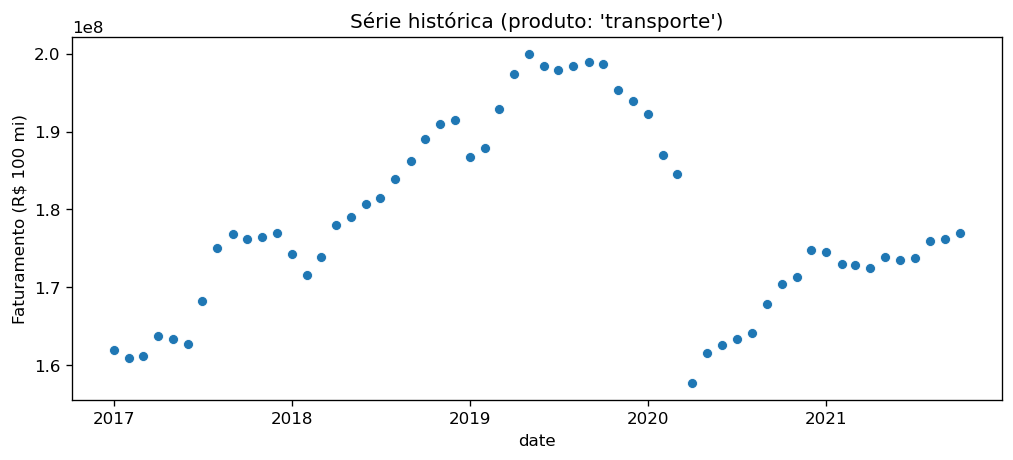

In [121]:
inicio = '2017-01'
fat_replicar = fat[inicio:]
sns.scatterplot(data = fat_replicar)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

... vemos um padrão interessante:

In [122]:
inicio_pos_pandemia = '2020-05'
serie2 = fat_replicar[inicio_pos_pandemia:].reset_index(drop=True)
serie1 = fat_replicar[:'2019-06'].reset_index(drop = True)

comparacao_dict = {
    f'{inicio}': serie1,
    f'{inicio_pos_pandemia}': serie2,
}
comparacao_wide = (pd.DataFrame(comparacao_dict)
    .reset_index()
    .rename(columns = {'index': 'n_mes'})
)

comparacao = pd.melt(comparacao_wide, var_name = 'periodo', value_name = 'faturamento', id_vars = 'n_mes')

sns.scatterplot(data = comparacao, y = 'faturamento', x = 'n_mes', hue = 'periodo')

plt.xlabel('Meses desde...')
plt.ylabel('')
plt.title(f"Faturamento (R$ 100 mi) - produto: '{analise_produto}'")
plt.show()

A série histórica que iniciou em 2017 parece se repetir no pós pandemia:

In [125]:
t_stat, p_valor = spst.ttest_ind(serie2, serie1[:serie2.shape[0]])
print(f'(valor-p = {p_valor:.2%}) ', end = '')
if p_valor < 0.05:
    print('Séries são estatisticamente diferentes. Rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.')
else:
    print('Séries não são estatisticamente diferentes. Não rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.')

(valor-p = 96.37%) Séries não são estatisticamente diferentes. Não rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.


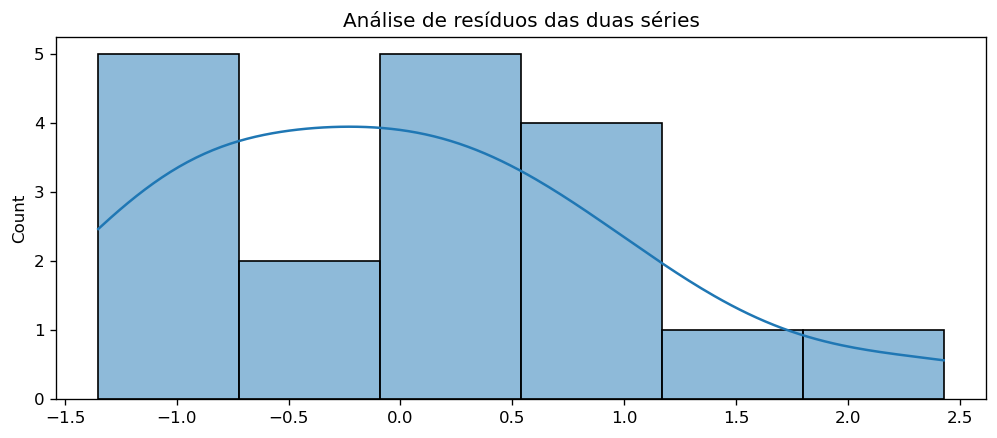

In [126]:
teste = comparacao_wide.dropna()
dif = teste[inicio_pos_pandemia] - teste[inicio]
resids = (dif - dif.mean())/dif.std()
sns.histplot(data = resids, kde = True)
plt.title('Análise de resíduos das duas séries')
plt.show()

Os resíduos são aproximadamente normais, de forma que o teste T de amostras independentes é válido. Ele diz que as séries não são significativamente diferentes.

Então, vamos fazer uma projeção baseada na série iniciada em 2017, e então ajustamos a essa série "simulada" um modelo autorregressivo.

In [127]:
col_pre_pandemia, col_pos_pandemia = comparacao_wide.columns[1:3]
comparacao_wide['faturamento_simulado'] = comparacao_wide[col_pos_pandemia].where(cond = comparacao_wide[col_pos_pandemia].notna(), other = comparacao_wide[col_pre_pandemia]) 
comparacao_wide['date'] = pd.date_range(start = col_pos_pandemia, periods = comparacao_wide.shape[0], freq = 'MS')

fat_sim = comparacao_wide.set_index('date')['faturamento_simulado']

In [128]:
train_test_split_idx = int(fat_sim.shape[0] * 0.7 + 1)
fat_train = fat_sim[:train_test_split_idx]
fat_test = fat_sim[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
fat_pp.plot(label = 'Série pós-pandemia original', marker = 'o', linestyle = '')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia (SÉRIE PROJETADA)")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

Agora as séries parecem parte de um mesmo modelo. No entanto, **parece haver bem poucos dados**.

Vamos determinar a estacionariedade da série:

In [129]:
testedf = adfuller(fat_sim)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 92.689% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) é no míninmo 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

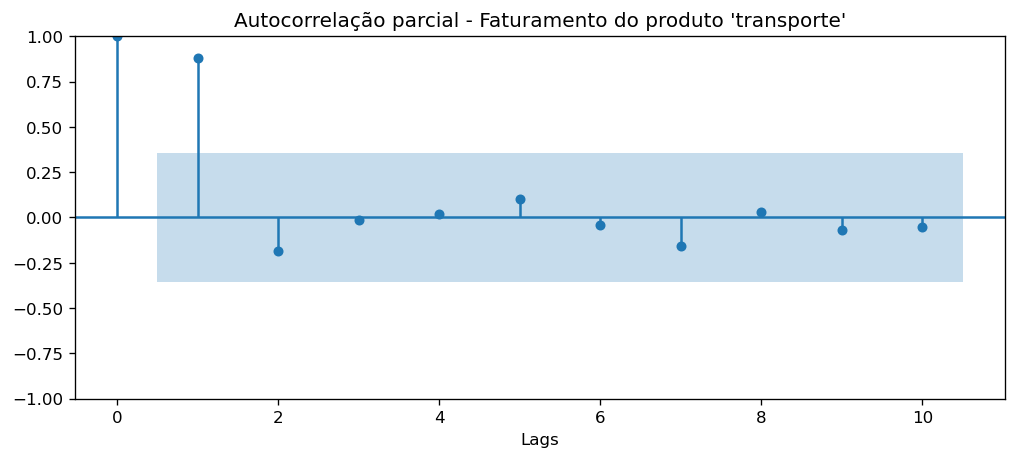

In [130]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_sim, lags = 10, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

Há indícios conflitantes, mas podemos testar todos os `d`s e ver qual mais se ajusta.

In [131]:
modelo_ppsim = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 1, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = False,
    trace = True,
    n_fits = 500,
    suppress_warnings=True,
)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=662.033, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=664.031, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=666.031, Time=0.04 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=668.031, Time=0.11 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=664.031, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=666.031, Time=0.09 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=668.031, Time=0.13 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=670.031, Time=0.26 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=666.031, Time=0.13 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=668.031, Time=0.24 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=670.031, Time=0.19 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=672.031, Time=0.34 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=668.031, Time=0.17 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=670.031, Time=1.19 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=672.031, Time=1.32 sec
 ARIMA(0,1

In [132]:
modelos_aceitaveis = [
    ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)
]

In [133]:
modelo_ppsim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -329.016
Date:                Tue, 23 Nov 2021   AIC                            662.033
Time:                        11:51:15   BIC                            664.122
Sample:                             0   HQIC                           662.486
                                 - 22                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.31e+06   3.47e+05      3.776      0.000     6.3e+05    1.99e+06
sigma2      2.377e+12   9.08e+11      2.619      0.009    5.99e+11    4.16e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.18   Prob(JB):                         0.74
Heteroskedasticity (H):               1.44   Skew:                             0.29
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

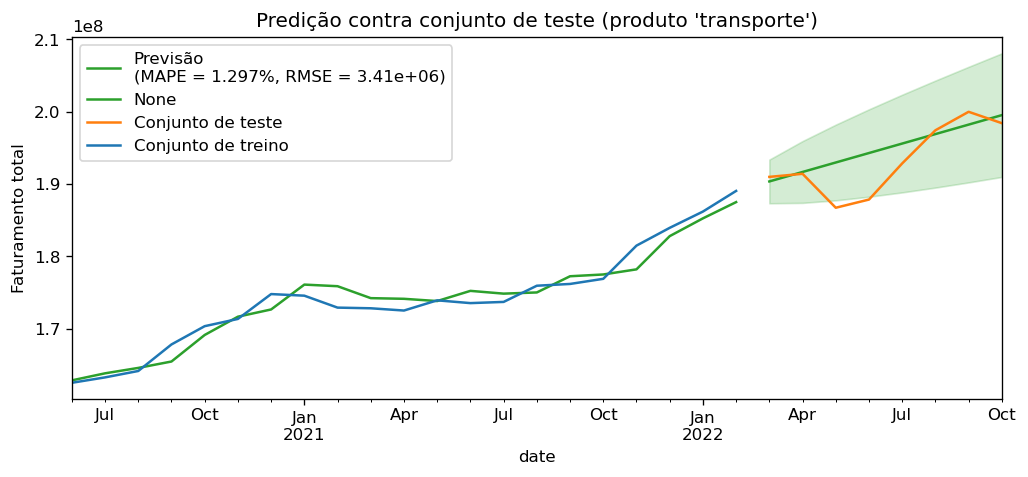

In [138]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_ppsim, 
    produto = analise_produto,
    serie_treino = fat_train['2020-06':],
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = True,
    preds_metrics = True
)

O modelo ARIMA ajustados somente aos dados pós pandemia tem os mesmos parâmetros (`ARIMA(0, 1, 0)` com intercepto, sem componente sazonal) que os ajustados aos dados completos. Embora o AIC seja bem menor no modelo com dados pós-pandemia (AIC = 662) do que no modelo com dados completos (AIC = 2304, perfazendo **uma redução de -71% em favor do modelo com dados simulados**), a métrica de acurácia percentual, MAPE, não acompanha essa magnitude de diferença (respectivamente, MAPEs de 1,3% e 2,14%, perfazendo **uma redução de -0,84 p.p. ou -39,2% em favor do modelo com dados simulados**).

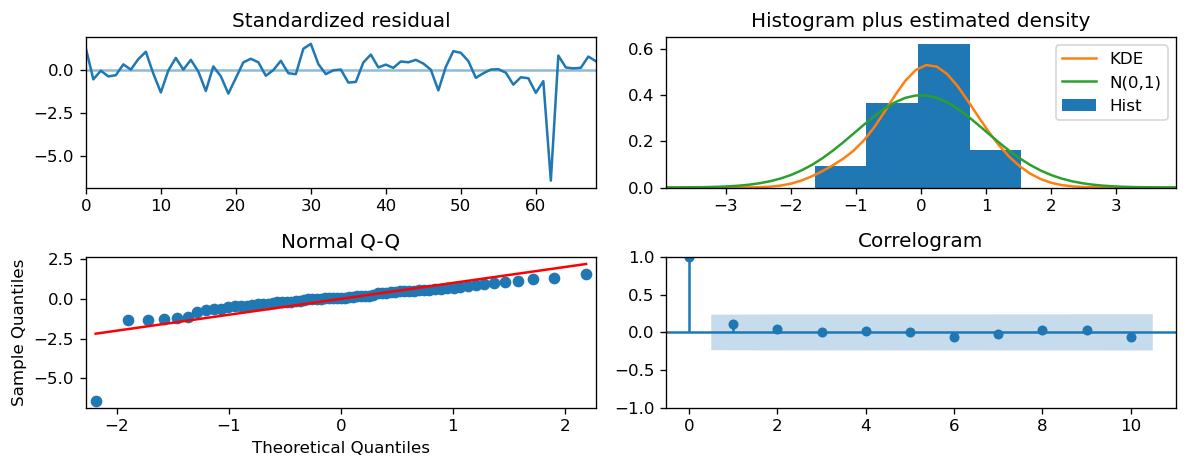

In [139]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Aparentemente está OK. No entanto, devemos nos lembrar que **este é um modelo sintético!**

Vamos aplicar algumas métricas quantitativas ao modelo:

In [140]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 1.297%
       RMSE: 3.414e+06
        MAE: 2.467e+06


## Modelo final - autorregressivo integrado de médias móveis - Dados pós-pandemia

In [141]:
analise_produto = 'transporte'
fat = tswide[analise_produto].dropna()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

Inicialmente é necessário construir a série "simulada" (detalhes em [`4-produto_transporte.ipynb`](../notebooks-exploration/4-produto_transporte.ipynb))

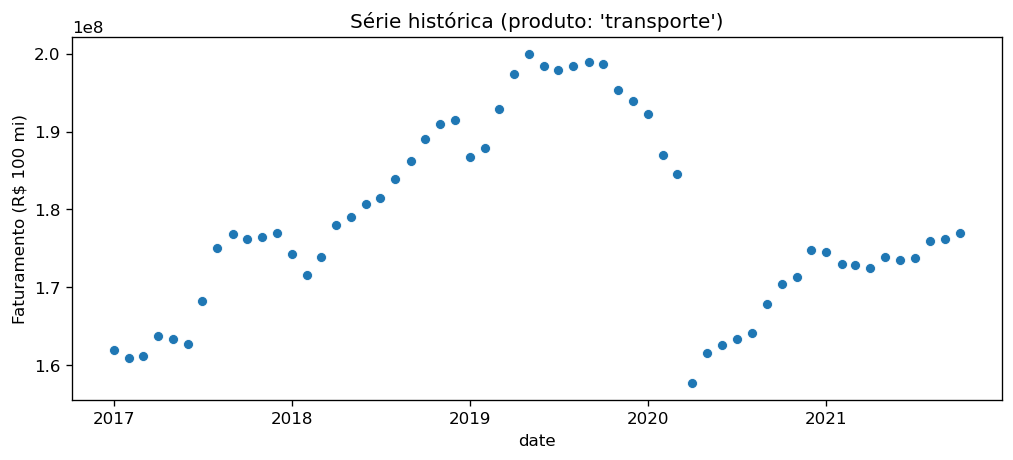

In [142]:
inicio = '2017-01'
inicio_pos_pandemia = '2020-05'

fat_replicar = fat[inicio:]
sns.scatterplot(data = fat_replicar)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

In [145]:
fat_pp = fat['2020-04':]

train_test_split_idx = int(fat_pp.shape[0] * 0.6 + 1)
fat_train = fat_pp[:train_test_split_idx]
fat_test = fat_pp[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

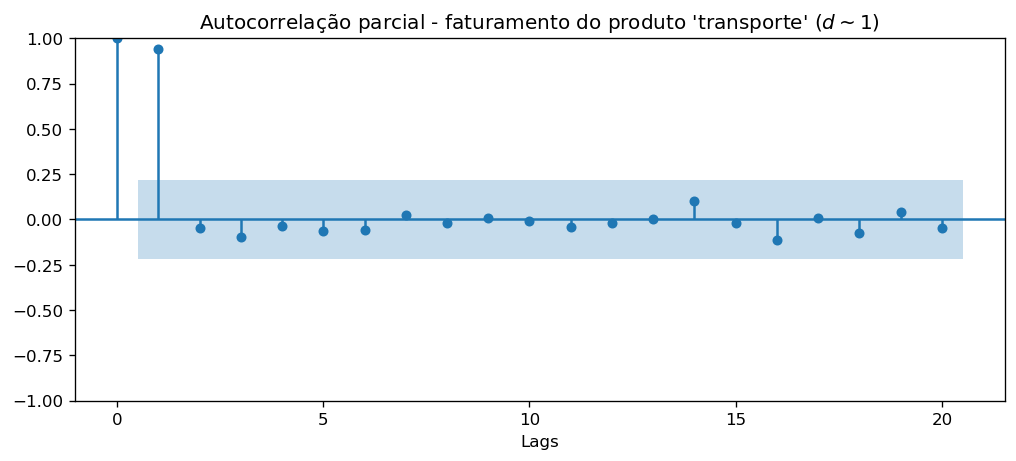

In [146]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

In [11]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [147]:
modelo = ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [148]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -173.463
Date:                Tue, 23 Nov 2021   AIC                            350.925
Time:                        11:56:02   BIC                            351.721
Sample:                             0   HQIC                           350.423
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.381e+06   5.15e+05      2.679      0.007    3.71e+05    2.39e+06
sigma2      2.915e+12   1.79e+12      1.630      0.103   -5.89e+11    6.42e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.49   Prob(JB):                         0.78
Heteroskedasticity (H):               2.53   Skew:                             0.05
Prob(H) (two-sided):                  0.39   Kurtosis:                         1.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

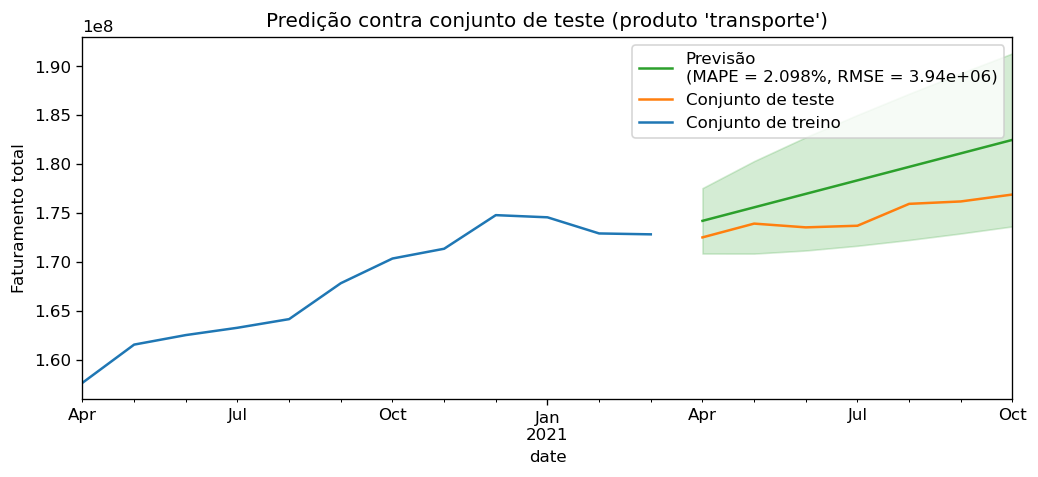

In [149]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

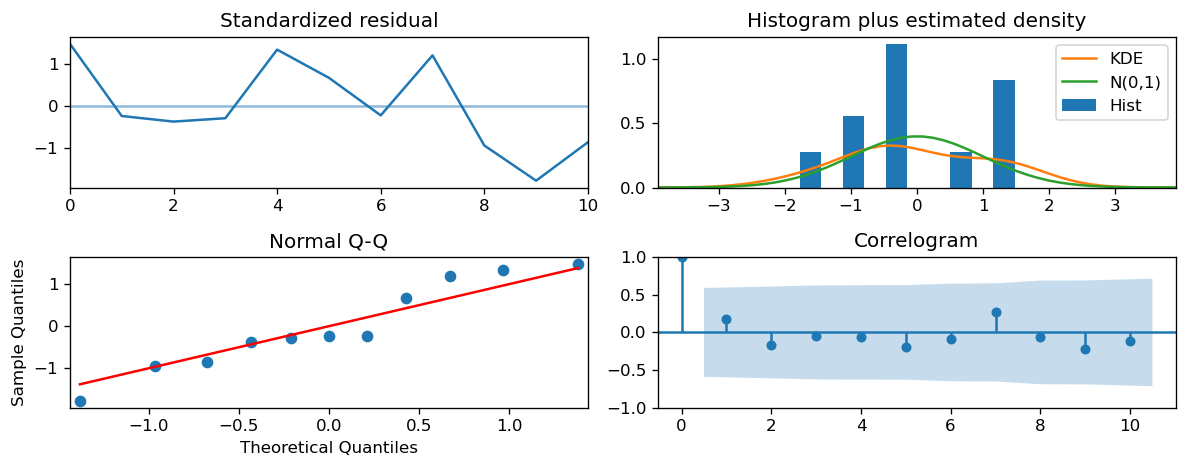

In [150]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [151]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 2.098%
       RMSE: 3.941e+06
        MAE: 3.674e+06


Vamos salvar o modelo atual para o faturamento do produto `transporte`.

In [152]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)

with open(r'produto_transporte.model', 'wb') as arq_modelo_transporte:
    pickler = pickle.Pickler(file = arq_modelo_transporte)
    pickler.dump(modelo_dict)


# 5 - Análise de Séries Temporais - Faturamento do produto `saude`

## Importação dos dados

In [154]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'saude'
fat = tswide[analise_produto].dropna()

In [155]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ 10 mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [156]:
fat.describe()

count    6.000000e+01
mean     2.089162e+07
std      5.826385e+06
min      0.000000e+00
25%      1.868296e+07
50%      2.275080e+07
75%      2.502346e+07
max      2.800000e+07
Name: saude, dtype: float64

In [157]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 10 mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

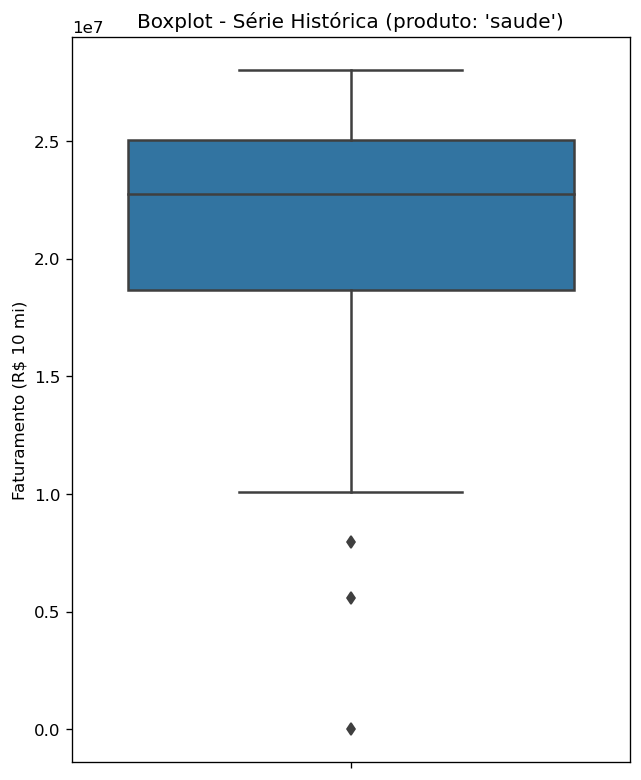

In [158]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ 10 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Os *outliers* da série histórica indicados no *boxplot* acima são provavelmente os valores baixo durante o *ramp-up* do produto.

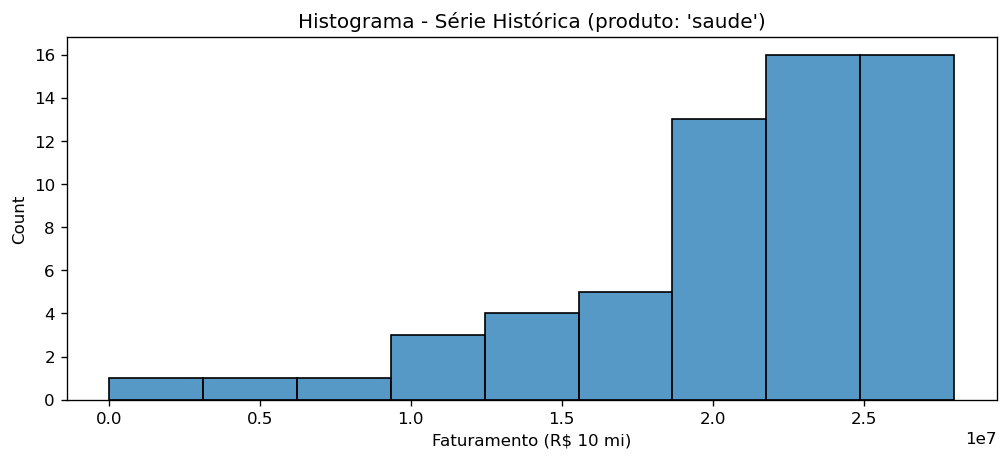

In [159]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ 10 mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [9]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     2.367604e+07
std      2.413237e+06
min      1.883889e+07
25%      2.152374e+07
50%      2.404184e+07
75%      2.530390e+07
max      2.800000e+07
Name: saude, dtype: float64

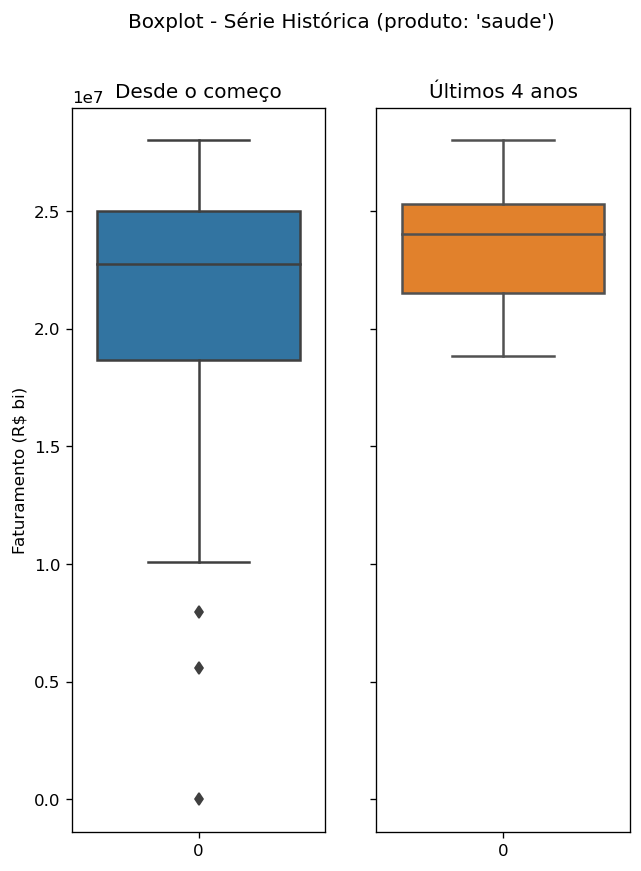

In [10]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Aparentemente estávamos corretos ao afirmar que os *outliers* da série completa eram devidos ao *ramp-up* do produto; nos último quatro anos não há mais indicação de valores extremos.

In [160]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

In [161]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

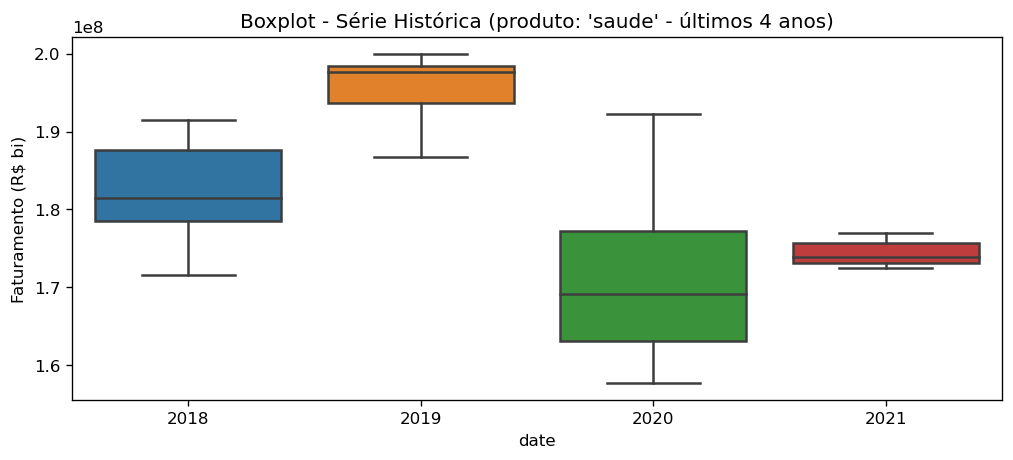

In [162]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [163]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [164]:
testedf = adfuller(fat['2017-07':])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 1.572% < 5%
    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.


Confirmamos que a série é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

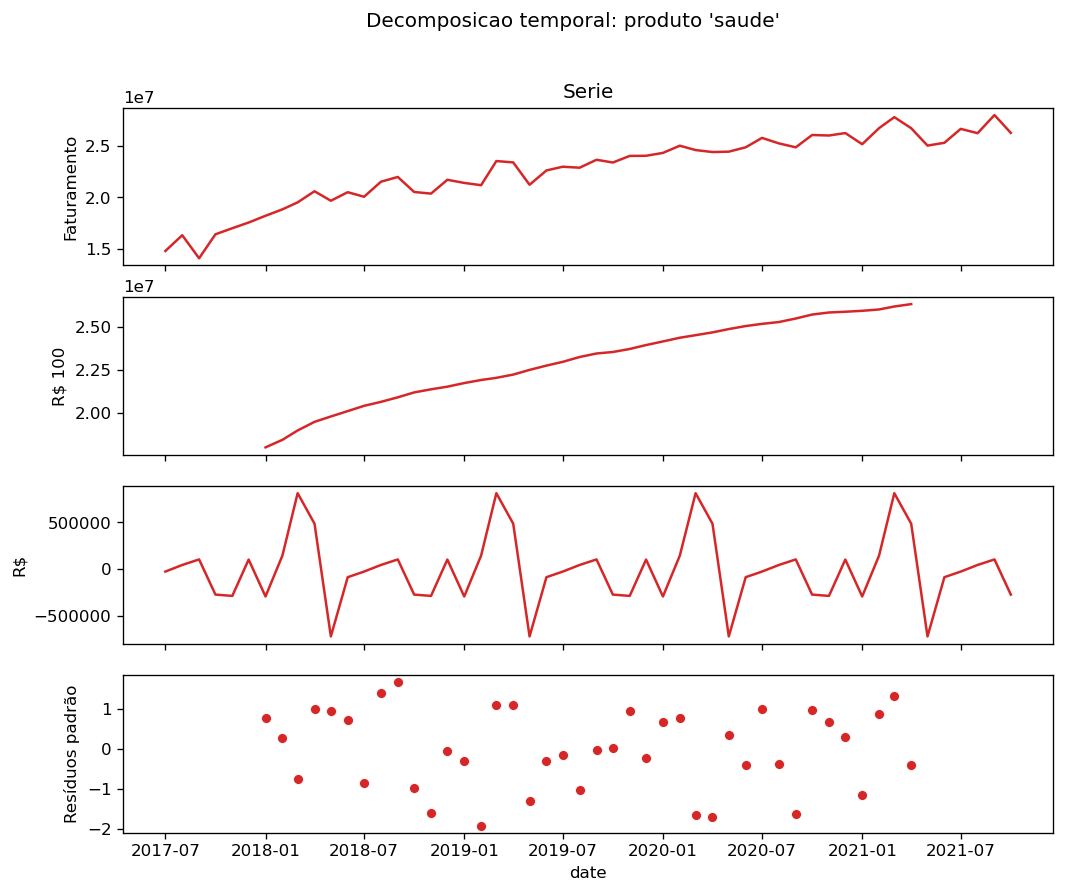

In [165]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat['2017-07':], produto = analise_produto, c = c)

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

É o que ocorre aqui. Os resíduos estão distribuídos aparentemene aleatoriamente.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

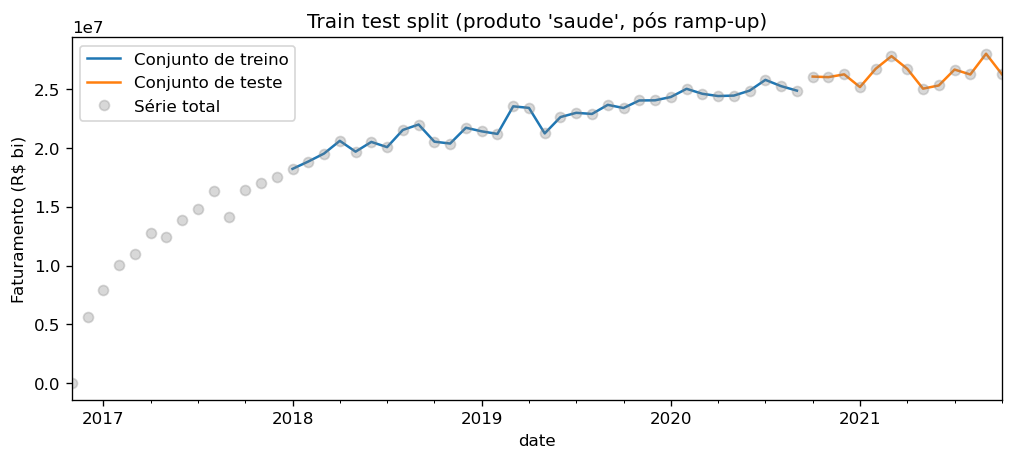

In [166]:
# após ramp-up
fat_modelo = fat['2018':]

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
fat.plot(label = 'Série total', marker = 'o', linestyle = '', alpha = 0.3, color = 'gray')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

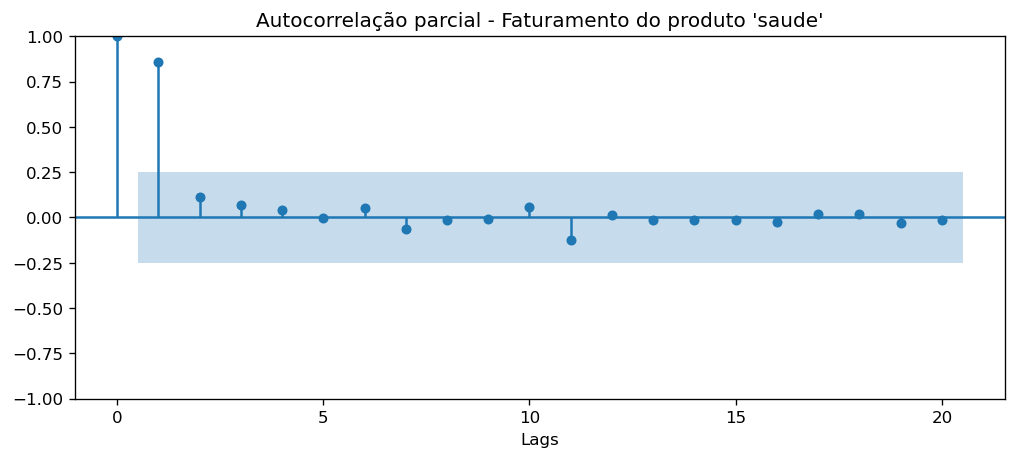

In [167]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

In [168]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = False,
    trace = True,
    n_fits = 500,
)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=970.347, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=972.209, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=974.209, Time=0.06 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=976.209, Time=0.20 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=972.213, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=974.204, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=976.204, Time=0.13 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=978.204, Time=0.34 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=974.213, Time=0.07 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=976.204, Time=0.17 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=978.204, Time=0.20 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=980.204, Time=0.40 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=976.205, Time=0.26 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=978.204, Time=0.33 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=980.204, Time=0.45 sec
 ARIMA(0,1

In [20]:
modelos_aceitaveis = [
    ARIMA(order = (1, 0, 0), seasonal_order=(0, 0, 0, 12), with_intercept = True).fit(y = fat_train),
    ARIMA(order = (0, 1, 0), seasonal_order=(0, 0, 0, 12), with_intercept = True).fit(y = fat_train)
]

In [169]:
modelo = ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [170]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -483.173
Date:                Tue, 23 Nov 2021   AIC                            970.347
Time:                        12:01:23   BIC                            973.278
Sample:                             0   HQIC                           971.318
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.078e+05   1.56e+05      1.335      0.182   -9.73e+04    5.13e+05
sigma2      7.629e+11   1.63e+11      4.679      0.000    4.43e+11    1.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.10   Prob(JB):                         0.59
Heteroskedasticity (H):               0.28   Skew:                            -0.21
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

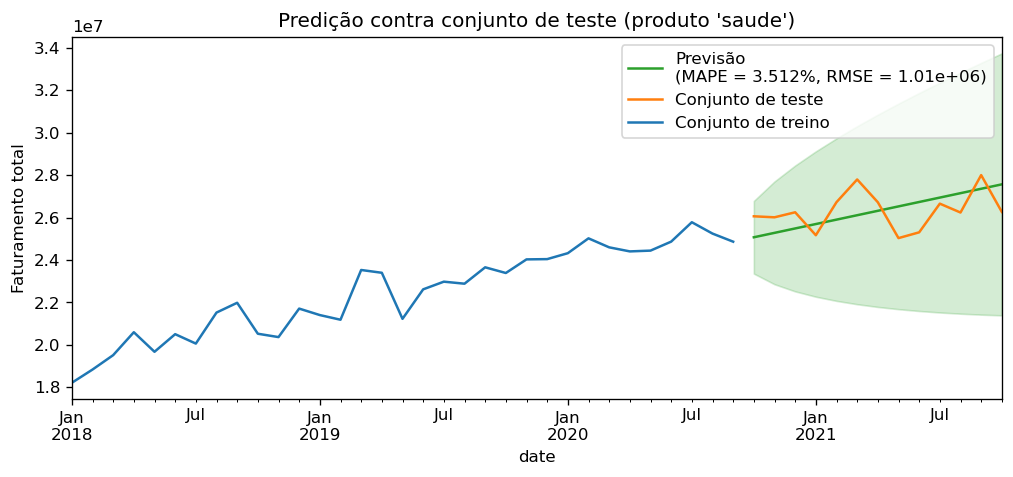

In [171]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

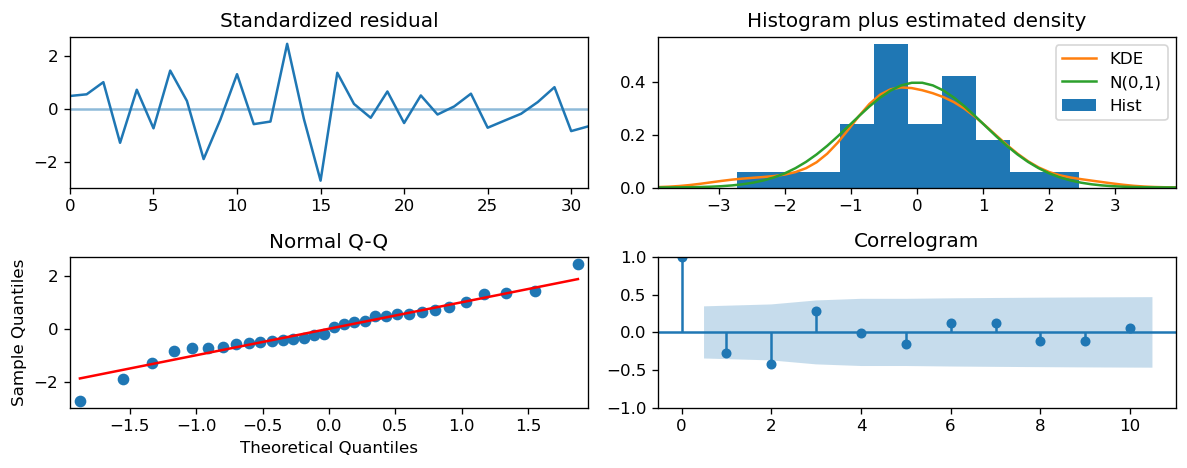

In [172]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [173]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 3.512%
       RMSE: 1.013e+06
        MAE: 9.217e+05


## Modelo final

In [174]:
analise_produto = 'saude'
fat = tswide[analise_produto].dropna()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

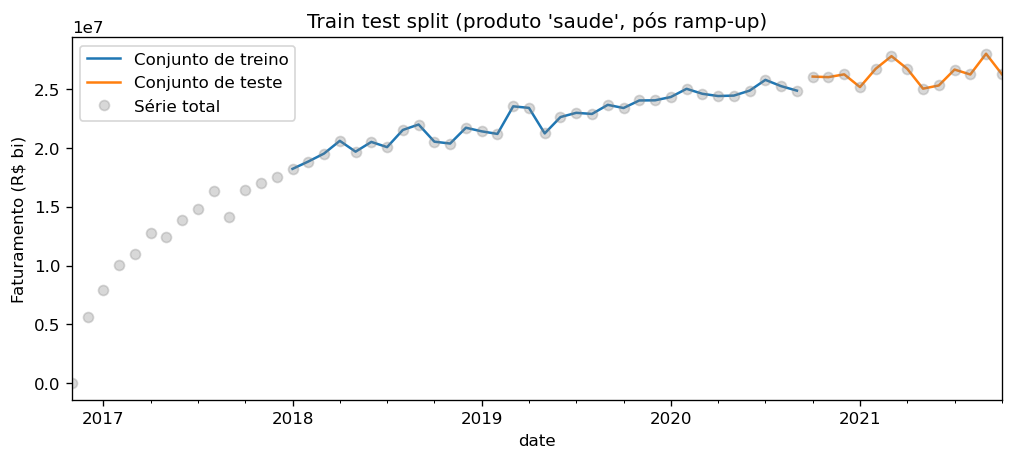

In [176]:
# após ramp-up
fat_modelo = fat['2018':]

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
fat.plot(label = 'Série total', marker = 'o', linestyle = '', alpha = 0.3, color = 'gray')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

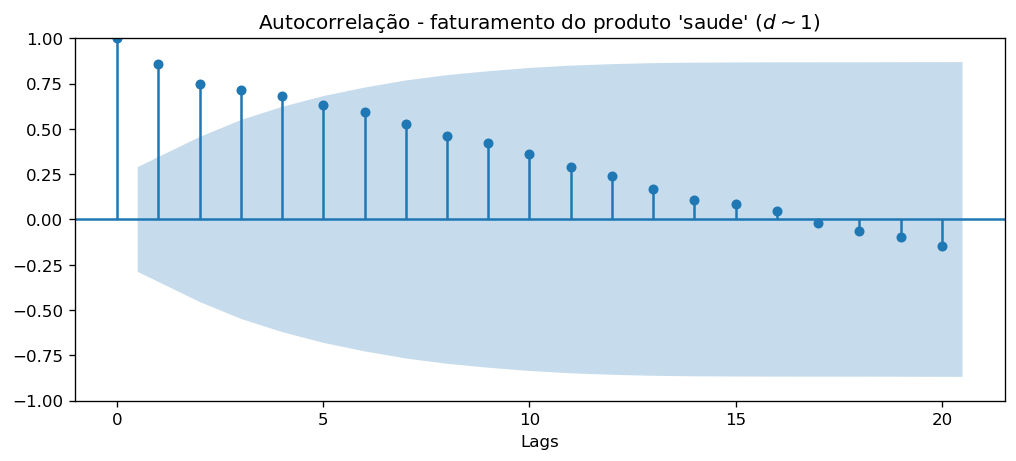

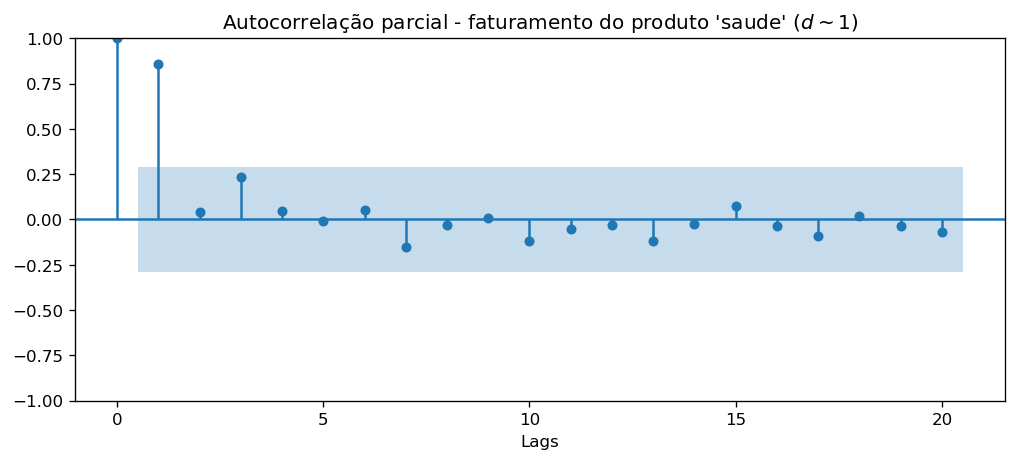

In [177]:
fig = plt.figure()
ax = fig.gca()
plot_acf(fat_modelo, lags = 20, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d \sim 1$)")
plt.show()

In [7]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [178]:
modelo = ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [179]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -483.173
Date:                Tue, 23 Nov 2021   AIC                            970.347
Time:                        12:02:33   BIC                            973.278
Sample:                             0   HQIC                           971.318
                                 - 33                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.078e+05   1.56e+05      1.335      0.182   -9.73e+04    5.13e+05
sigma2      7.629e+11   1.63e+11      4.679      0.000    4.43e+11    1.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.10   Prob(JB):                         0.59
Heteroskedasticity (H):               0.28   Skew:                            -0.21
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

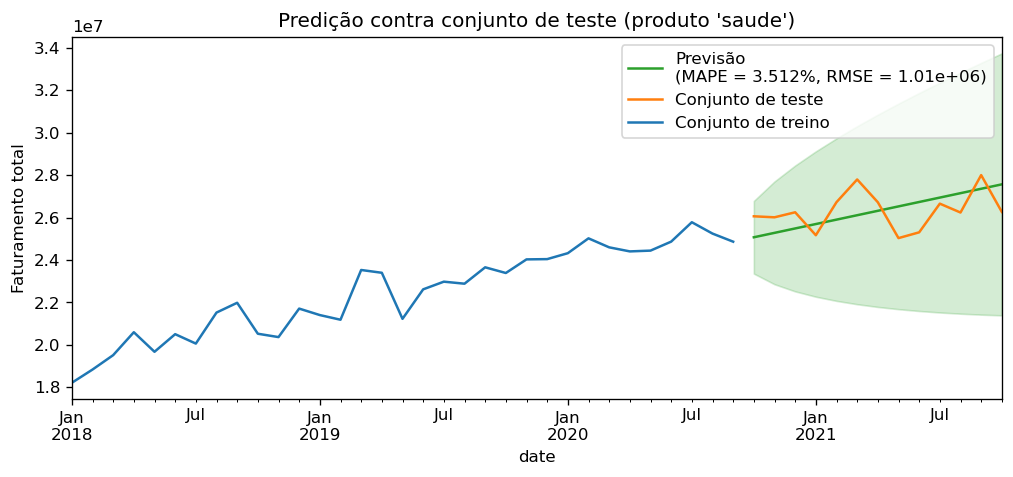

In [180]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

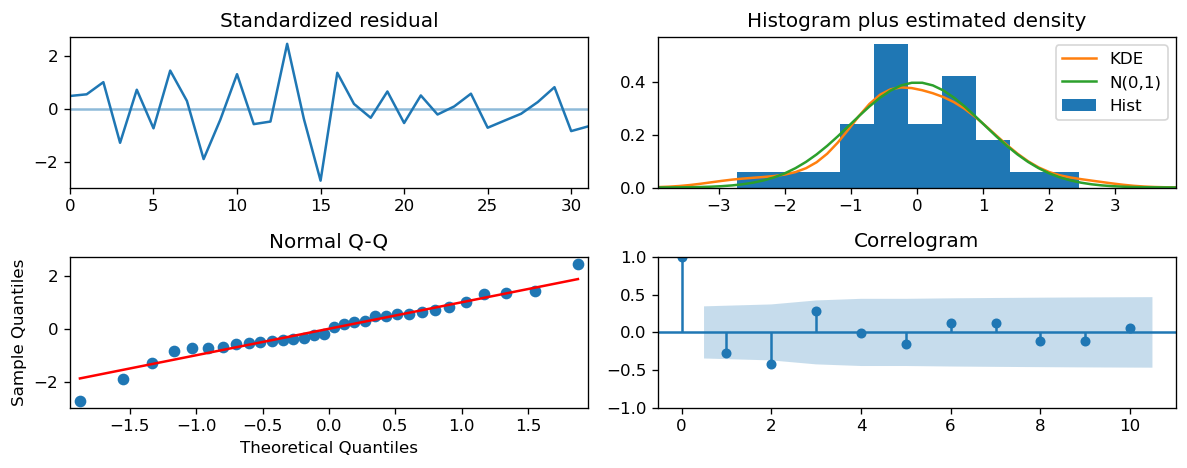

In [181]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [182]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds,
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 3.512%
       RMSE: 1.013e+06
        MAE: 9.217e+05


Vamos salvar o modelo atual para o faturamento do produto `saude`.

In [183]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)

with open(r'produto_saude.model', 'wb') as arq_modelo_saude:
    pickler = pickle.Pickler(file = arq_modelo_saude)
    pickler.dump(modelo_dict)


# 6 - Análise de Séries Temporais - Faturamento do produto `auxilio_final_de_ano`

## Importação dos dados

In [186]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'auxilio_final_de_ano'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

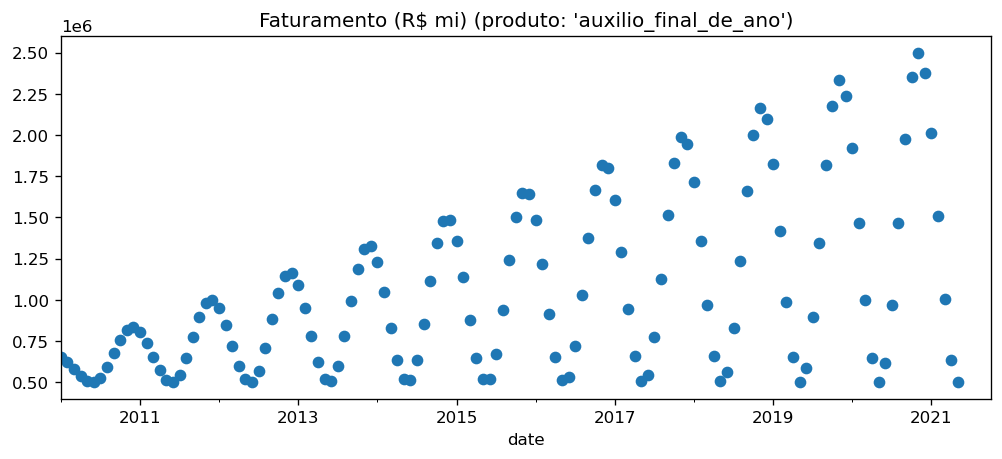

In [187]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [188]:
fat.describe()

count    1.370000e+02
mean     1.061174e+06
std      5.249966e+05
min      5.000000e+05
25%      6.331345e+05
50%      9.129011e+05
75%      1.375567e+06
max      2.500000e+06
Name: auxilio_final_de_ano, dtype: float64

In [189]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

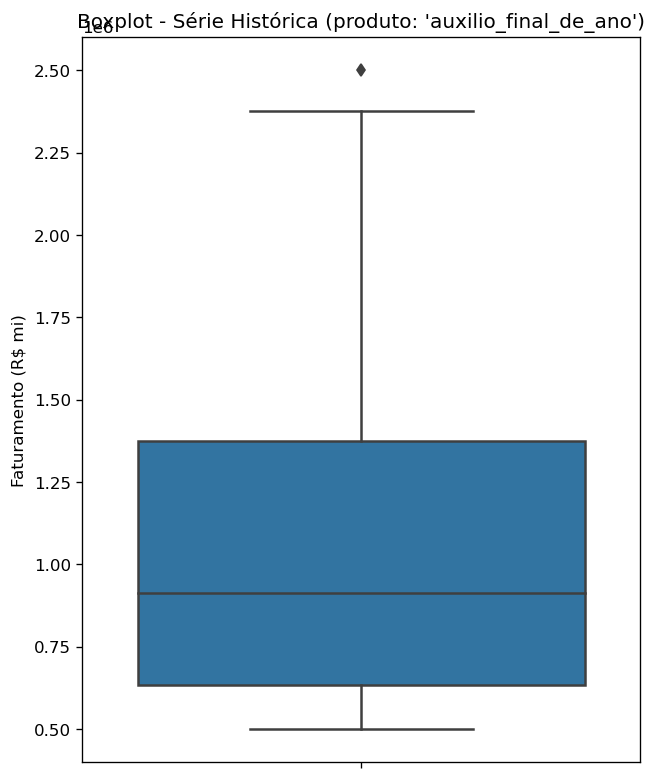

In [190]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

Os *outliers* da série histórica indicados no *boxplot* acima são provavelmente decorrentes do comportamento oscilatório dos faturamentos se tornarem mais acentuados conforme o tempo passa.

In [191]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [193]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.000000e+01
mean     1.356653e+06
std      6.591265e+05
min      5.000000e+05
25%      6.560182e+05
50%      1.351597e+06
75%      1.981791e+06
max      2.500000e+06
Name: auxilio_final_de_ano, dtype: float64

In [194]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

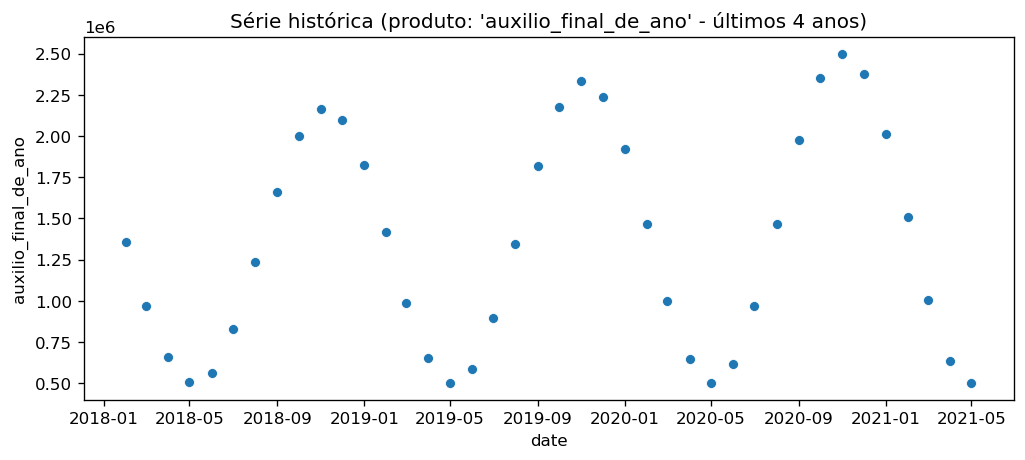

In [195]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

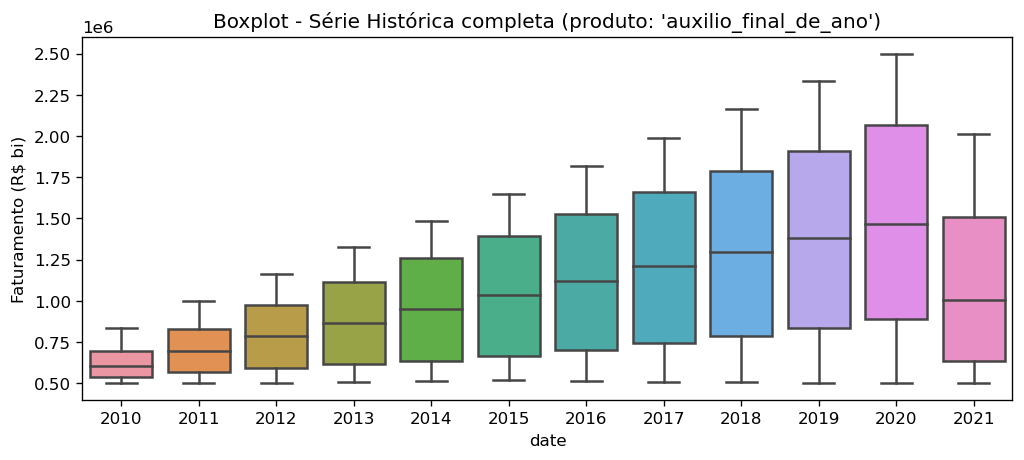

In [196]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

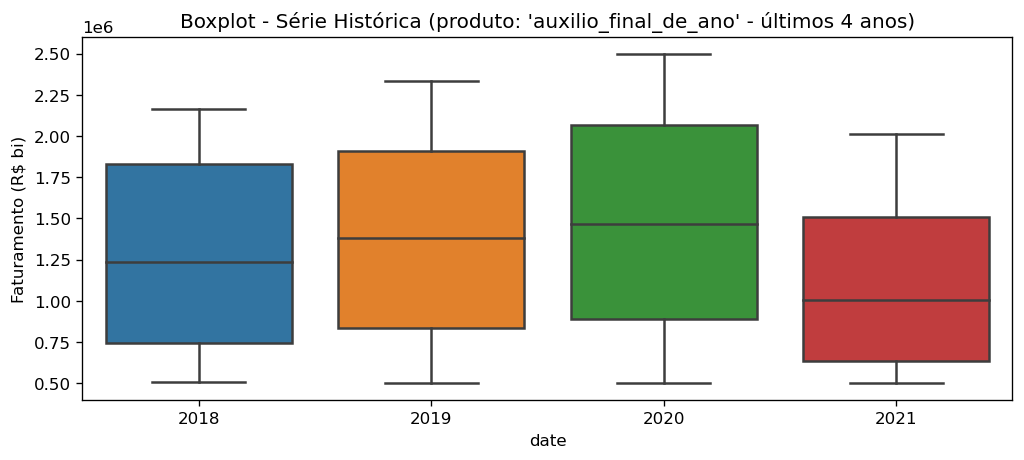

In [197]:
sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ bi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [198]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [199]:
testedf = adfuller(fat.dropna())
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 92.419% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

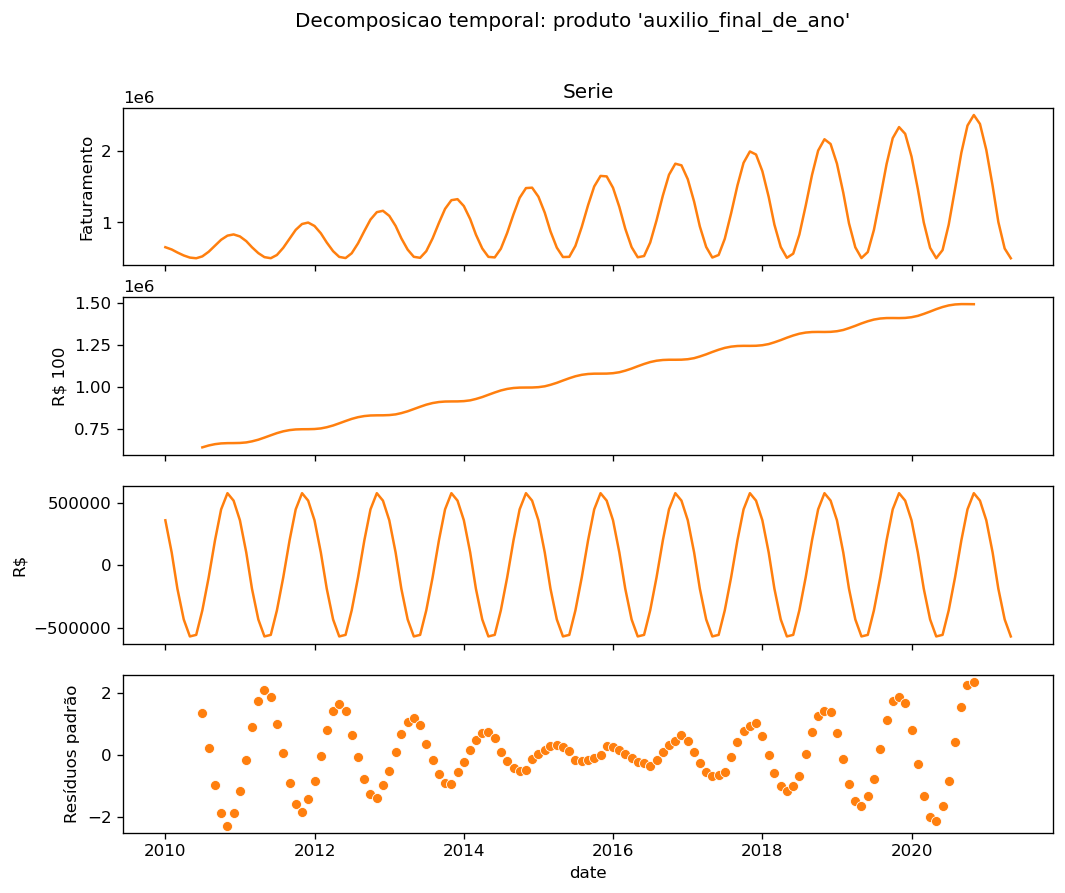

In [200]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat.dropna(), produto = analise_produto, c = c)

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos claramente seguem um padrão oscilatório.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

In [201]:
fat_modelo = fat

train_test_split_idx = int(fat_modelo.dropna().shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ mi)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

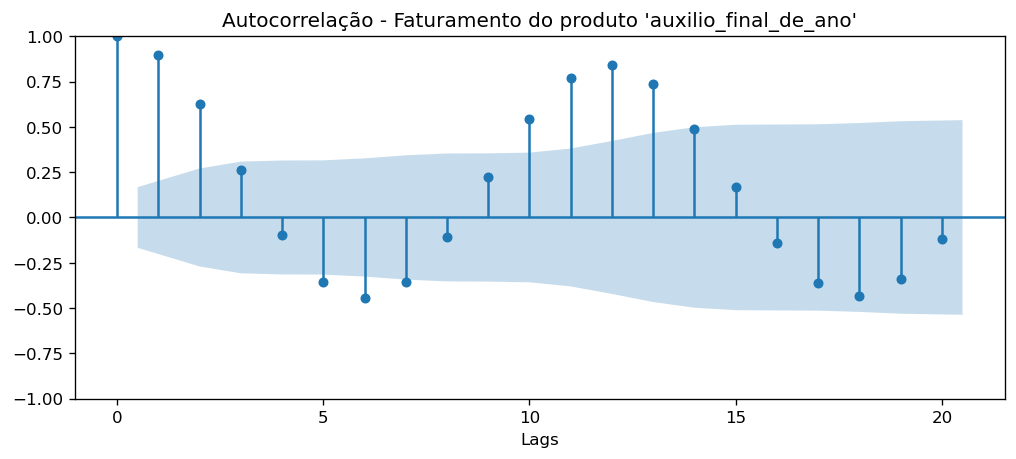

In [202]:
fig = plt.figure()
ax = fig.gca()
plot_acf(fat_modelo.dropna(), lags = 20, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação - Faturamento do produto '{analise_produto}'")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo.dropna(), lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d, D \sim 6$.

In [203]:
nsdiffs(x = fat_train, m = 12, max_D = 20)

6

In [204]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 5,
    d = None, max_d = 7,
    start_q = 1, max_q = 5,
    start_P = 1, max_P = 5,
    D = None, max_D = 7,
    start_Q = 1, max_Q = 5,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
    error_action = 'ignore',
    suppress_warnings= True,
)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,6,1)[12]             : AIC=-81.615, Time=8.89 sec
 ARIMA(0,0,0)(0,6,0)[12]             : AIC=-40.024, Time=0.46 sec
 ARIMA(1,0,0)(1,6,0)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(0,0,1)(0,6,1)[12]             : AIC=-36.040, Time=4.13 sec
 ARIMA(1,0,1)(0,6,1)[12]             : AIC=-83.610, Time=4.94 sec
 ARIMA(1,0,1)(0,6,0)[12]             : AIC=-85.579, Time=2.54 sec
 ARIMA(1,0,1)(1,6,0)[12]             : AIC=-124.362, Time=8.14 sec
 ARIMA(1,0,1)(2,6,0)[12]             : AIC=-81.659, Time=8.75 sec
 ARIMA(1,0,1)(2,6,1)[12]             : AIC=-79.662, Time=15.46 sec
 ARIMA(0,0,1)(1,6,0)[12]             : AIC=-72.019, Time=5.62 sec
 ARIMA(2,0,1)(1,6,0)[12]             : AIC=-201.737, Time=3.35 sec
 ARIMA(2,0,1)(0,6,0)[12]             : AIC=-177.875, Time=1.97 sec
 ARIMA(2,0,1)(2,6,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,0,1)(1,6,1)[12]             : AIC=-172.111, Time=15.72 sec
 ARIMA(2,0,1)(0,6,1)[12]            

In [19]:
# modelos_aceitaveis = [
#     ARIMA(order = (0, 0, 1), seasonal_order=(1, 4, 1, 12), with_intercept = True).fit(y = fat_train),
#     ARIMA(order = (3, 0, 2), seasonal_order=(1, 6, 0, 12), with_intercept = False).fit(y = fat_train)
# ]

In [205]:
modelo = ARIMA(order = (3, 0, 2), seasonal_order=(1, 6, 0, 12), with_intercept = False).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [206]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(3, 0, 2)x(1, 6, [], 12)   Log Likelihood                 118.711
Date:                             Tue, 23 Nov 2021   AIC                           -223.423
Time:                                     12:22:59   BIC                           -215.176
Sample:                                          0   HQIC                          -221.235
                                              - 96                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8561      0.004    229.051      0.000       0.849       0.863
ar.L2          0.5056      0.001    443.974      0.000       0.503       0.508
ar.L3         -0.8709   8.58e-07  -1.01e+06      0.000      -0.871      -0.871
ma.L1         -0.1401      0.004    -38.889      0.000      -0.147      -0.133
ma.L2         -0.7826   5.04e-05  -1.55e+04      0.000      -0.783      -0.782
ar.S.L12       0.9993      0.001   1210.912      0.000       0.998       1.001
sigma2      4.233e-09   1.62e-09      2.607      0.009    1.05e-09    7.42e-09
===================================================================================
Ljung-Box (L1) (Q):                  12.27   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.95   Skew:                            -0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+20. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

In [207]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

In [208]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Os resíduos apresentam padrões claramente visíveis. No entanto, não conseguiremos eliminar estes padrões, vistos que os dados são oscilatórios.

Vamos aplicar algumas métricas quantitativas ao modelo:

In [49]:
kwargs_total = dict(
    y_true = fat_test.dropna(),
    y_pred = preds.loc[fat_test.dropna().index],
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 0.000%
       RMSE: 4.697e-02
        MAE: 2.702e-02


## Modelo final - modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`)

In [209]:
analise_produto = 'auxilio_final_de_ano'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

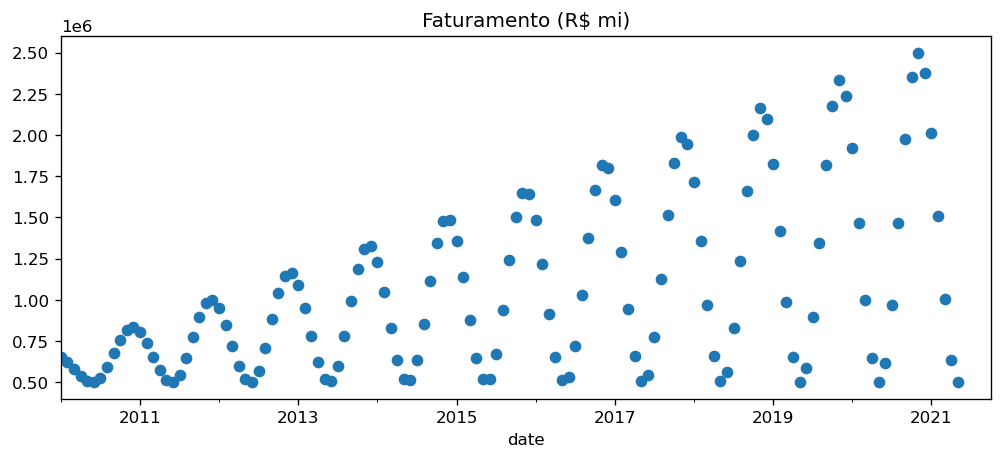

In [210]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ mi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

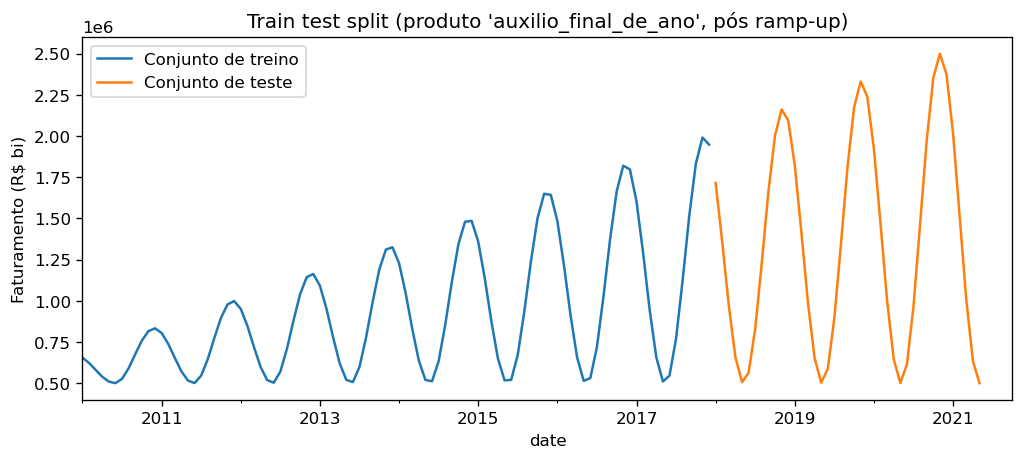

In [211]:
fat_modelo = fat.copy()

train_test_split_idx = int(fat_modelo.dropna().shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

In [212]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo.dropna(), lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d, D \sim 4$)")
plt.show()

In [7]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 5,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 5,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
#     enforce_stationarity = True,
# )

In [213]:
modelo = ARIMA(order = (3, 0, 2), seasonal_order=(1, 6, 0, 12), with_intercept = False).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [214]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(3, 0, 2)x(1, 6, [], 12)   Log Likelihood                 118.711
Date:                             Tue, 23 Nov 2021   AIC                           -223.423
Time:                                     12:25:41   BIC                           -215.176
Sample:                                          0   HQIC                          -221.235
                                              - 96                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8561      0.004    229.051      0.000       0.849       0.863
ar.L2          0.5056      0.001    443.974      0.000       0.503       0.508
ar.L3         -0.8709   8.58e-07  -1.01e+06      0.000      -0.871      -0.871
ma.L1         -0.1401      0.004    -38.889      0.000      -0.147      -0.133
ma.L2         -0.7826   5.04e-05  -1.55e+04      0.000      -0.783      -0.782
ar.S.L12       0.9993      0.001   1210.912      0.000       0.998       1.001
sigma2      4.233e-09   1.62e-09      2.607      0.009    1.05e-09    7.42e-09
===================================================================================
Ljung-Box (L1) (Q):                  12.27   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.95   Skew:                            -0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+20. Standard errors may be unstable.
"""

In [215]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

In [216]:
modelo.plot_diagnostics(figsize = (10,8))
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [217]:
kwargs_ajuste = dict(
    y_true = fat_test.dropna(),
    y_pred = preds[fat_test.dropna().index],
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.000%
       RMSE: 4.697e-02
        MAE: 2.702e-02


Vamos salvar o modelo atual para o faturamento do produto `auxilio_final_de_ano`.

In [218]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)

with open(r'produto_auxilio.model', 'wb') as arq_modelo_auxilio:
    pickler = pickle.Pickler(file = arq_modelo_auxilio)
    pickler.dump(modelo_dict)


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 7 - Análise de Séries Temporais - Faturamento do produto `bonificacao`

## Importação dos dados

In [220]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'bonificacao'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].dropna().index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

In [221]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [222]:
fat.describe()

count        86.000000
mean     146876.014620
std       28749.544736
min       89211.183185
25%      126109.507134
50%      145913.341145
75%      168398.936689
max      201331.273286
Name: bonificacao, dtype: float64

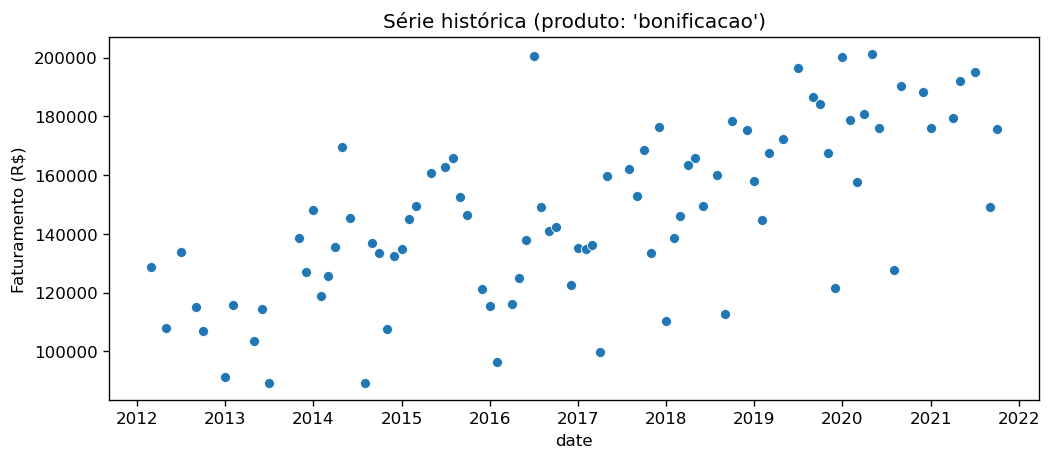

In [223]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

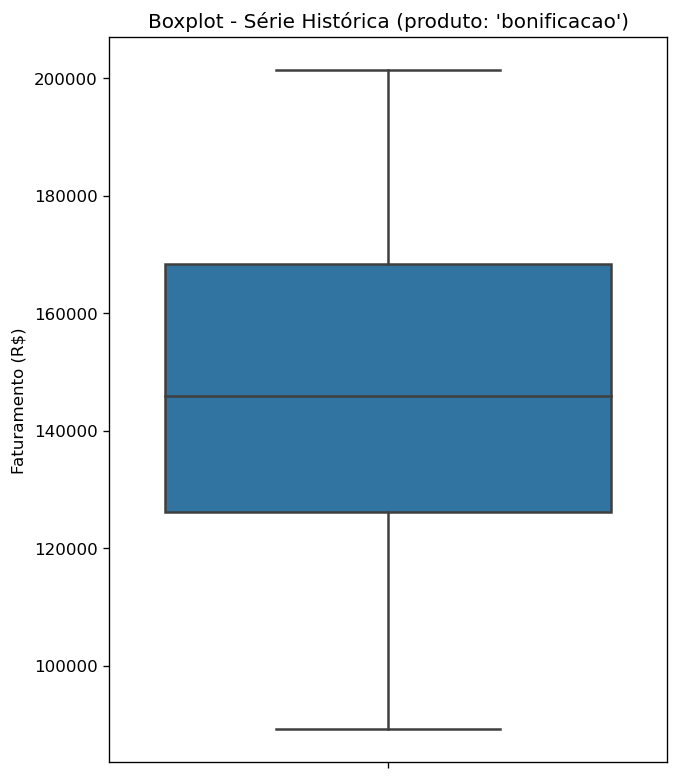

In [224]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

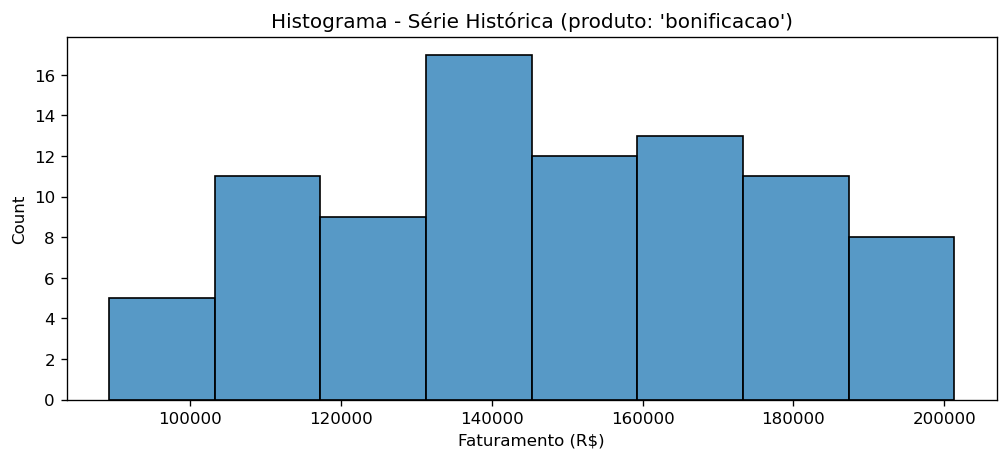

In [225]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa parece bastante comportado. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [226]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count        33.000000
mean     168434.648490
std       22530.819106
min      112903.036433
25%      157559.908526
50%      175503.635972
75%      184069.308917
max      201331.273286
Name: bonificacao, dtype: float64

In [227]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

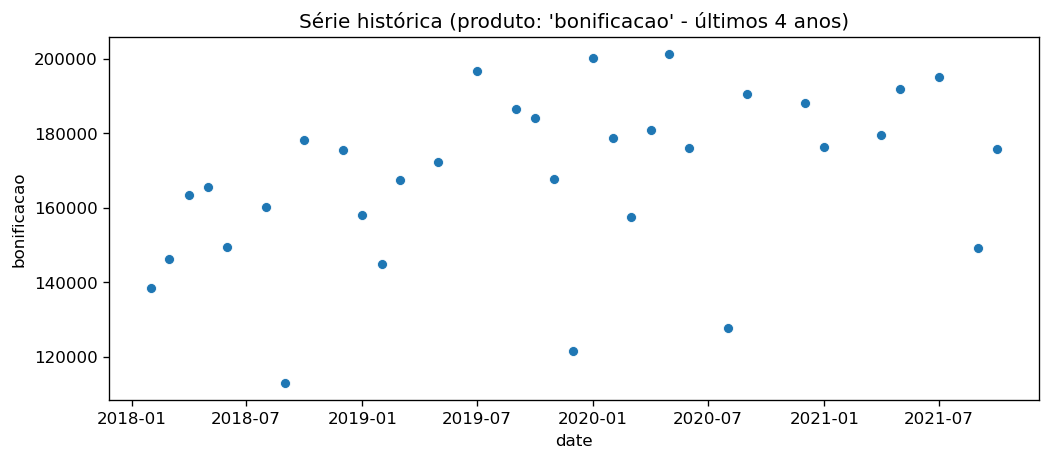

In [228]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

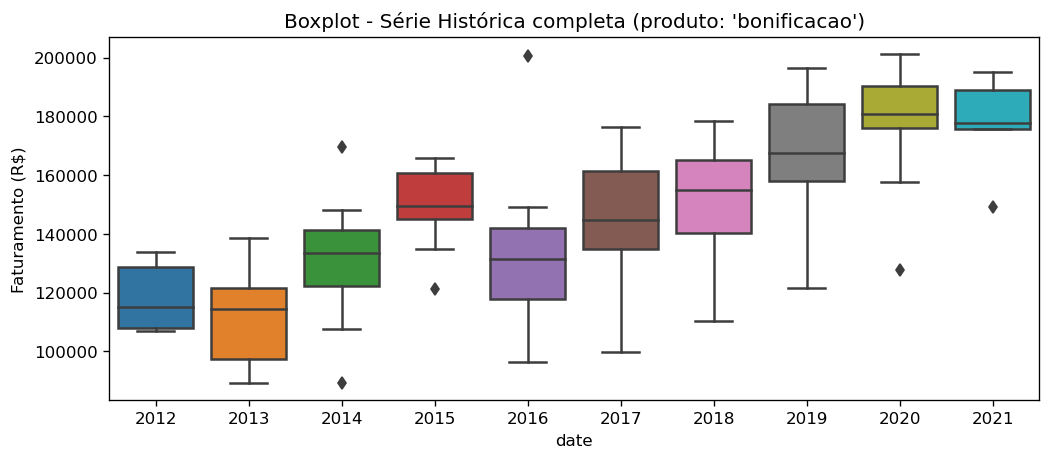

In [229]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

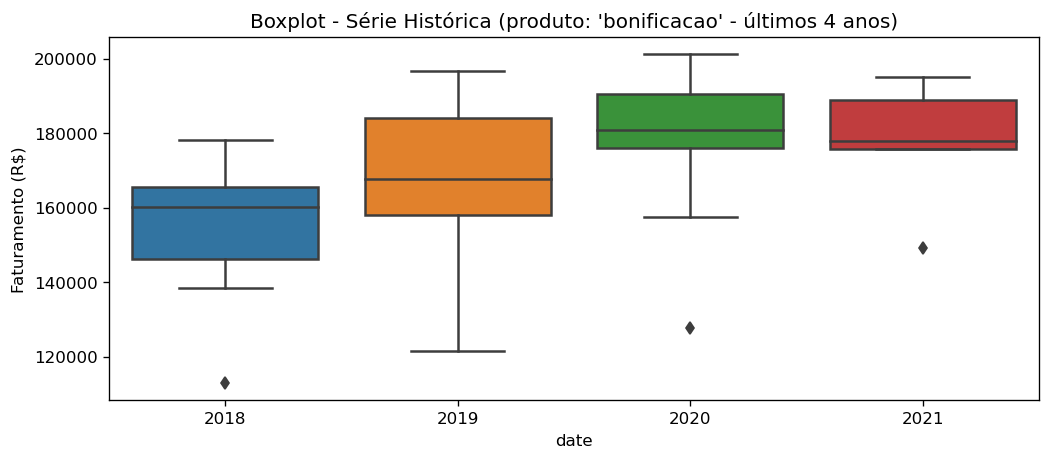

In [14]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [230]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

Nota-se que a série atingiu uma certa estabilidade por volta de meados de 2017:

In [231]:
testedf = adfuller(fat.dropna())
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 72.132% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

In [233]:
i = i_palette[analise_produto]
c = seaborn_palette[i]

decomp = py_scripts.plots.decomp_fourier(serie_fat = fat, produto = analise_produto, c = c)

# ERRO. Série não pode conter valores faltando.

ValueError: This function does not handle missing values

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos claramente seguem um padrão oscilatório.

Vamos ver o que ocorre quanto tentamos projetar essa série para o futuro.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

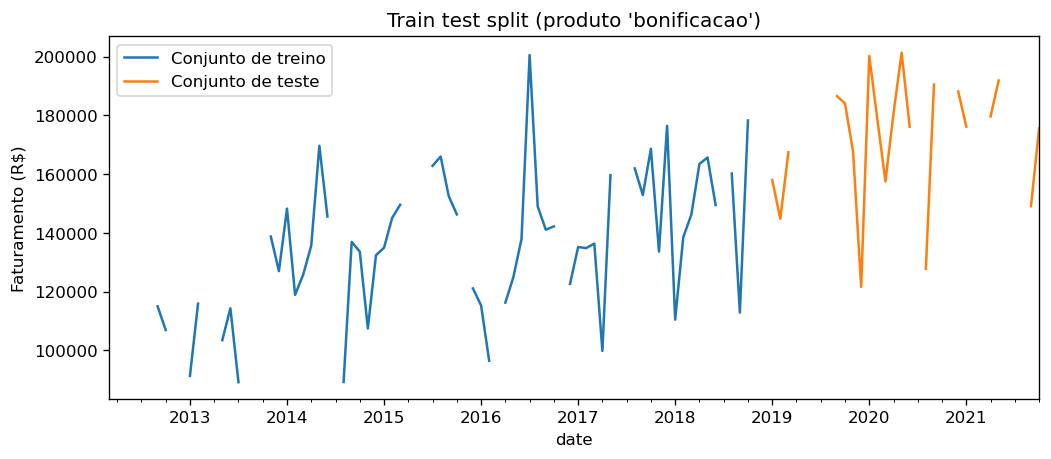

In [234]:
fat_modelo = fat

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$)')
plt.legend()
plt.show()

De cara já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) pode ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

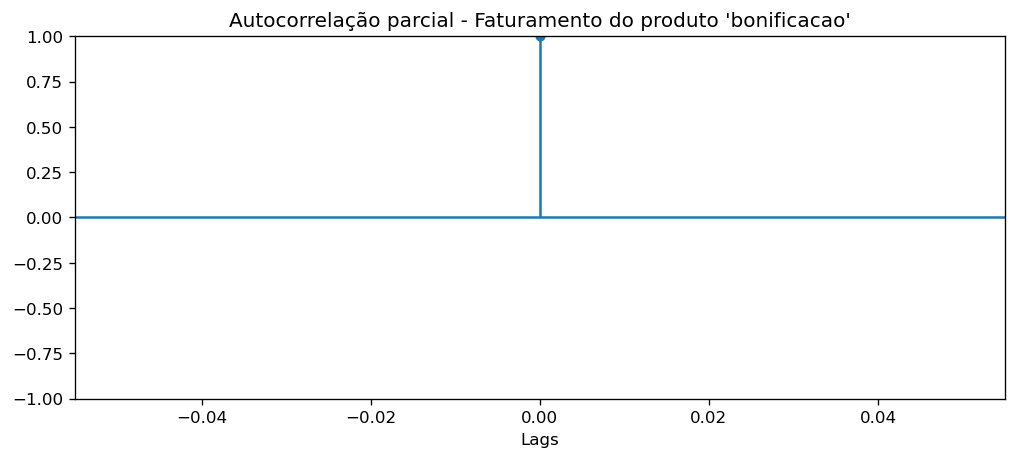

In [235]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

A função de autocorrelação não se comporta bem quando há muitos falorae faltantes na série.

Como não há nenhuma indicação acerca da ordem do modelo autorregressivo, não resta opção a não ser testar todas as combinações razoáveis:

In [236]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500,
)

# ERRO: auto_arima não aceita valores faltantes. Temos que fazer manualmente


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [242]:
# total de combinações: 2048
# tempo aproximado de término da simulação: ~ 9 minutos em computador com processador Intel i7-4910MQ 2.9 GHz, 32 GB de memória RAM, rodando Windows 10

ip = pd.Series(range(0, 4), name = 'p')
id = pd.Series(range(0, 2), name = 'd')
iq = pd.Series(range(0, 4), name = 'q')

iP = pd.Series(range(0, 4), name = 'P')
iD = pd.Series(range(0, 2), name = 'D')
iQ = pd.Series(range(0, 4), name = 'Q')
iS = pd.Series([12], name = 'S')

iIntercept = pd.Series([True, False], name = 'Intercept')

aic_idx = pd.MultiIndex.from_product([ip, id, iq, iP, iD, iQ, iS, iIntercept])

aicdf = pd.DataFrame(
    [], 
    columns = ['aic', 'bic'],
    index = aic_idx
)

aic_min = np.inf

for (p, d, q, P, D, Q, S, intercept) in tqdm(aic_idx, desc = '# de combinações de ordens testadas'):

    if p + q > 3 or P + Q > 3:
        continue
    
    try:
        m = ARIMA(order = (p, d, q), seasonal_order = (P, D, Q, S), with_intercept = intercept, suppress_warnings=True).fit(y = fat_train)
    except:
        continue

    aic = m.aic()
    bic = m.bic()

    if aic < aic_min:
        aic_min = aic
        modelo = m

    aicdf.loc[(p, d, q, P, D, Q, S, intercept)] = (aic, bic)

aicdf.sort_values(by = 'aic', inplace = True)


# de combinações de ordens testadas: 100%|██████████| 2048/2048 [07:50<00:00,  4.35it/s]


In [243]:
aicdf.head(10)

aic          bic
p d q P D Q S  Intercept                          
1 0 2 0 1 1 12 False      1287.946027  1299.188503
    1 0 1 1 12 False      1288.419037  1297.413018
2 0 1 0 1 1 12 False      1288.843956  1300.086432
1 0 2 1 1 1 12 False      1289.807691  1303.298662
      0 1 2 12 False      1289.837533  1303.328505
    1 1 1 1 12 False      1290.166642  1301.409119
      0 1 2 12 False      1290.206356  1301.448832
2 0 1 1 1 1 12 False      1290.723191  1304.214163
      0 1 2 12 False      1290.749987  1304.240959
1 0 2 2 1 1 12 False      1291.613978  1307.353445

In [244]:
modelo = ARIMA(
    order = (1, 0, 2), 
    seasonal_order = (0, 1, 1, 12), 
    with_intercept = False
).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [245]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -638.973
Date:                              Tue, 23 Nov 2021   AIC                           1287.946
Time:                                      12:39:35   BIC                           1299.189
Sample:                                           0   HQIC                          1292.412
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9847      0.020     49.177      0.000       0.945       1.024
ma.L1         -0.7132      0.250     -2.851      0.004      -1.203      -0.223
ma.L2         -0.1321      0.279     -0.474      0.635      -0.678       0.414
ma.S.L12      -0.6815      0.300     -2.268      0.023      -1.270      -0.092
sigma2      8.117e+08   8.28e-11    9.8e+18      0.000    8.12e+08    8.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.95   Prob(JB):                         0.76
Heteroskedasticity (H):               0.97   Skew:                             0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+36. Standard errors may be unstable.
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

In [246]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

Vamos aplicar alguns diagnósticos aos resíduos do modelo:

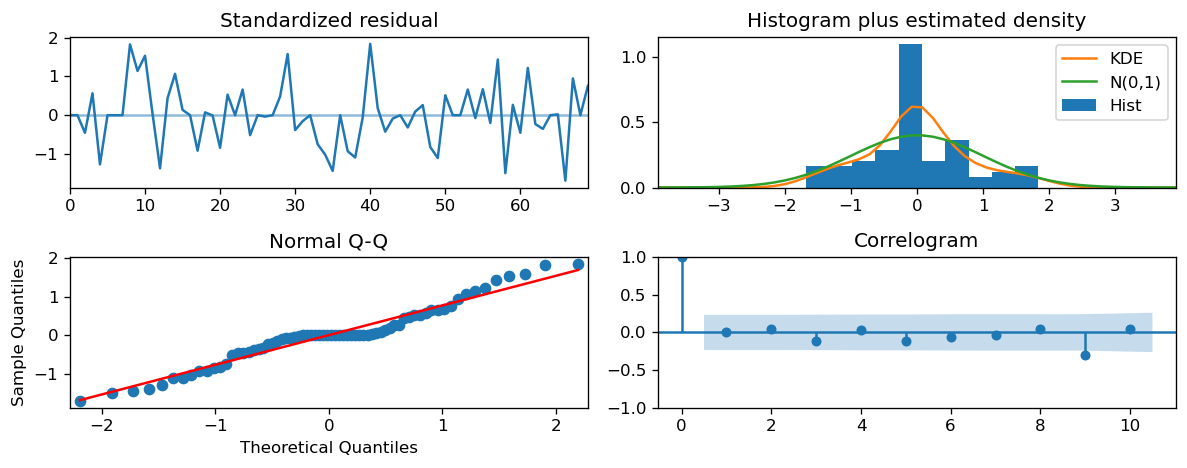

In [247]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas quantitativas ao modelo:

In [248]:
kwargs_total = dict(
    y_true = fat_test.dropna(),
    y_pred = preds.loc[fat_test.dropna().index],
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 11.617%
       RMSE: 2.444e+04
        MAE: 1.949e+04


## Modelo autorregressivo com probabilidade de zero

Até o momento, desenvolvemos o raciocínio assumindo que os dados faltantes (os meses em que o faturamento do produto `bonificacao` não está disponível) eram simples erros de registro.

Um outra interpretação é possível: os valores faltantes representam meses em que não houve faturamento para esse produto. Neste caso, os valores faltantes devem ser equivalentes a zero.

Vejamos como isso muda nossa modelagem.

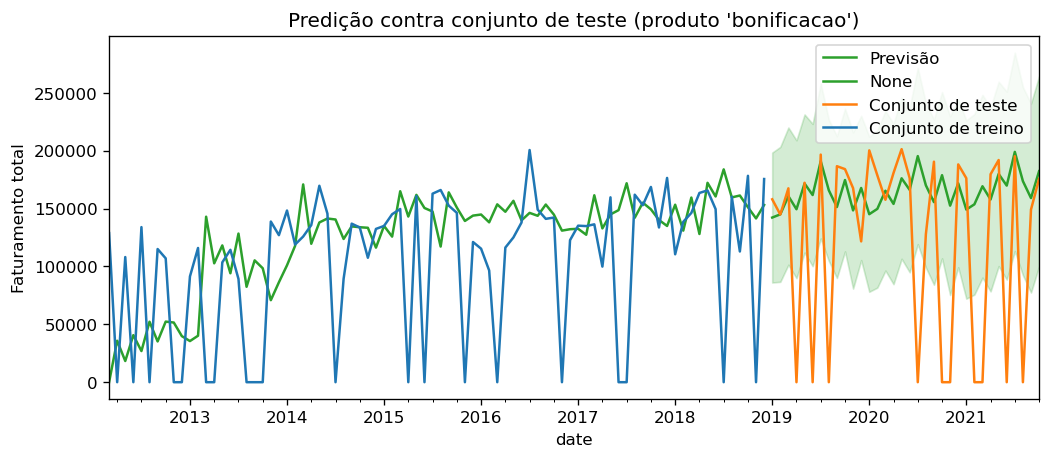

In [249]:
fat0 = fat.fillna(0)
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train.fillna(0),
    serie_teste = fat_test.fillna(0),
    ci = True,
    in_sample = True,
    preds_metrics = False
)

### EDA

Vamos investigar se há algum padrão segundo o qual os zeros estão distribuídos.

#### Por ano

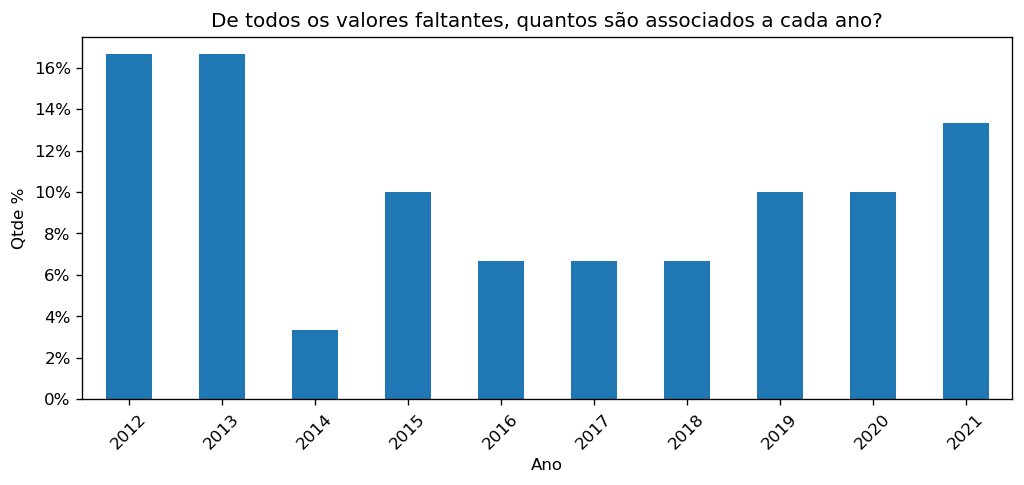

In [250]:
fat0_ano = fat0[fat0 == 0].index.year.value_counts(normalize = True).sort_index()

fig = plt.figure()
ax = fig.gca()

fat0_ano.plot(kind = 'bar', ax = ax)

ax.set_title('De todos os valores faltantes, quantos são associados a cada ano?')

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('Qtde %')

ax.set_xlabel('Ano')
ax.xaxis.set_tick_params(rotation=45)

plt.show()

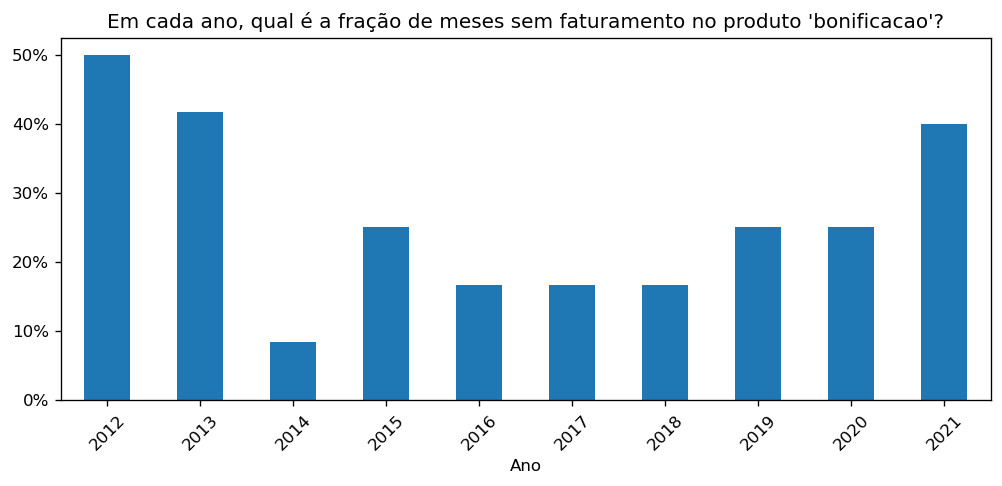

In [251]:
fat0_pctano = fat0[fat0 == 0].index.year.value_counts() / fat0.index.year.value_counts()

fig = plt.figure()
ax = fig.gca()

fat0_pctano.plot(kind = 'bar', ax = ax)

ax.set_title("Em cada ano, qual é a fração de meses sem faturamento no produto 'bonificacao'?")

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')

ax.set_xlabel('Ano')
ax.xaxis.set_tick_params(rotation = 45)

plt.show()

#### Por mês do ano

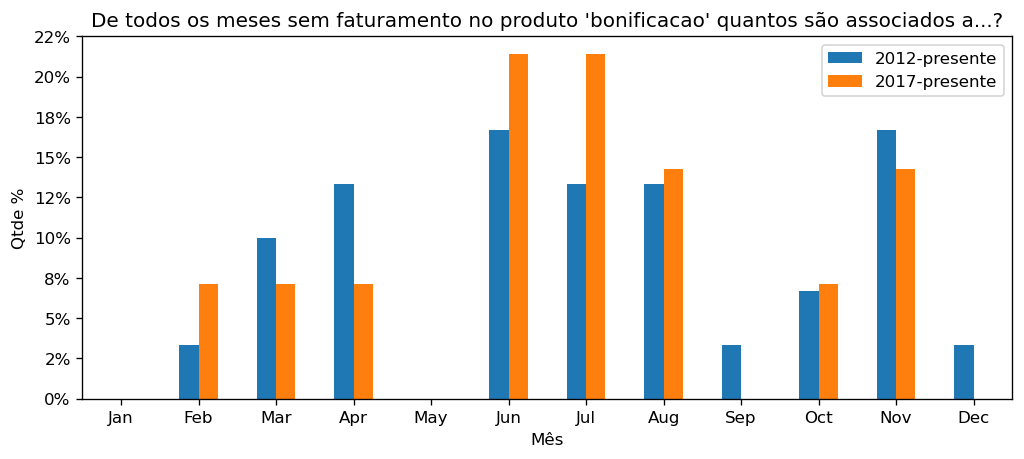

In [252]:
fig = plt.figure()
ax = fig.gca()

fat_mes = fat0[fat0 == 0].index.month.value_counts(normalize = True).sort_index()
fat_mes_recente = fat0[(fat0 == 0) & (fat0.index >= '2017')].index.month.value_counts(normalize = True).sort_index()

fat_mes = fat_mes.reindex(range(1, 13))
fat_mes.index = np.vectorize(lambda m: dt.date.strftime(dt.date(year = 1970, month = m, day = 1), format = '%b'))(fat_mes.index)

fat_mes_recente = fat_mes_recente.reindex(range(1, 13))
fat_mes_recente.index = fat_mes.index

df_fat_mes = pd.DataFrame({
    '2012-presente': fat_mes,
    '2017-presente': fat_mes_recente
})

palette = sns.color_palette(None, 2)
df_fat_mes.plot(label = '2012-presente', kind = 'bar', ax = ax)

ax.set_title("De todos os meses sem faturamento no produto 'bonificacao' quantos são associados a...?")

ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('Qtde %')

ax.set_xlabel('Mês')
ax.xaxis.set_tick_params(rotation=0)
plt.legend()
plt.show()

Destes gráficos, concluímos que há a possibilidade de construirmos um modelo do tipo Bernoulli, com uma probabilidade `p` a ser determinada, para predizermos se em determinado mês o faturamento do produto `bonificacao` será zero ou não. Caso não seja, então aplicamos o modelo `SARIMA` que desenvolvemos na seção anterior.

### Análise de série temporal com modelo logístico

No entanto, o problema com análise de séries temporais é que os valores frequentemente são autocorrelacionados, *i.e.* o valor do faturamento em um mês tem correlação com os meses anteriores.

No caso em tela, precisamos prever se o faturamento em um mês $t$ será 0 ou não. Podemos usar um modelo de regressão logística caso a série binária (em cada mês, True se o faturamento for zero, e False caso contrário) não for autocorrelacionada:

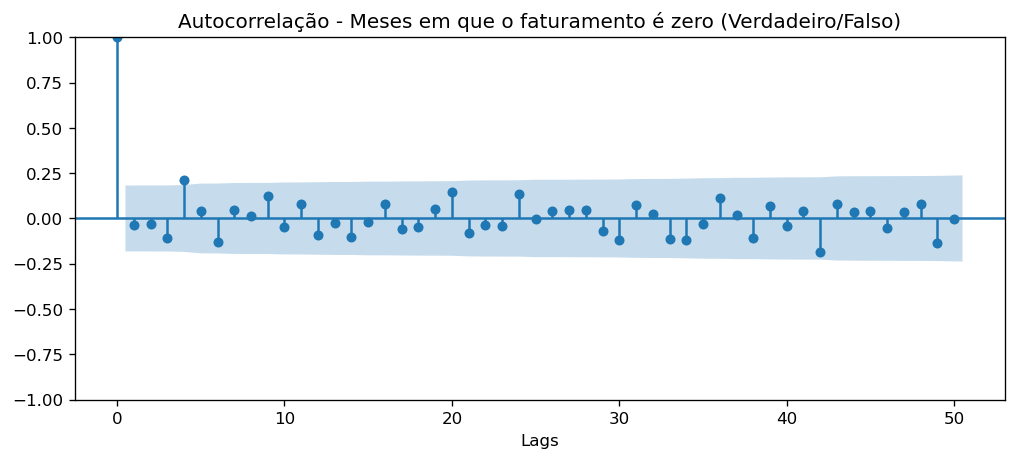

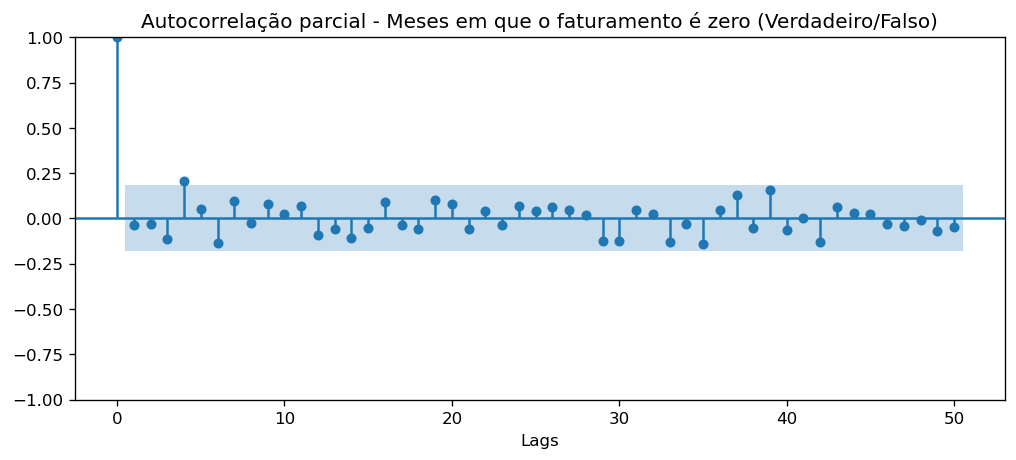

In [253]:
fat_is0 = fat0 == 0

fig = plt.figure()
ax = fig.gca()
plot_acf(fat_is0, lags = 50, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação - Meses em que o faturamento é zero (Verdadeiro/Falso)")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_is0, lags = 50, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Meses em que o faturamento é zero (Verdadeiro/Falso)")
plt.show()

De fato, a série binária que descrevemos não é autocorrelacionada, o que facilita sobremaneira a análise.

### Regressão logística

Vamos aplicar uma simples regressão logística, onde a variável independente é o número de meses desde janeiro de 2017, e a variável dependente é se o faturamento é zero ou não.

In [254]:
series_begin = '2017'

fat0_logreg = fat0[series_begin:]

X = fat0_logreg.reset_index().index.values.reshape(-1, 1)
y = (fat0_logreg == 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# sc = StandardScaler()

# X_train = sc.fit_transform(X_train_unscaled)
# X_test = sc.transform(X_test_unscaled)
# X_train = X_train_unscaled
# X_test = X_test_unscaled

bonusreg = LogisticRegression()
bonusreg.fit(X_train, y_train)

LogisticRegression()

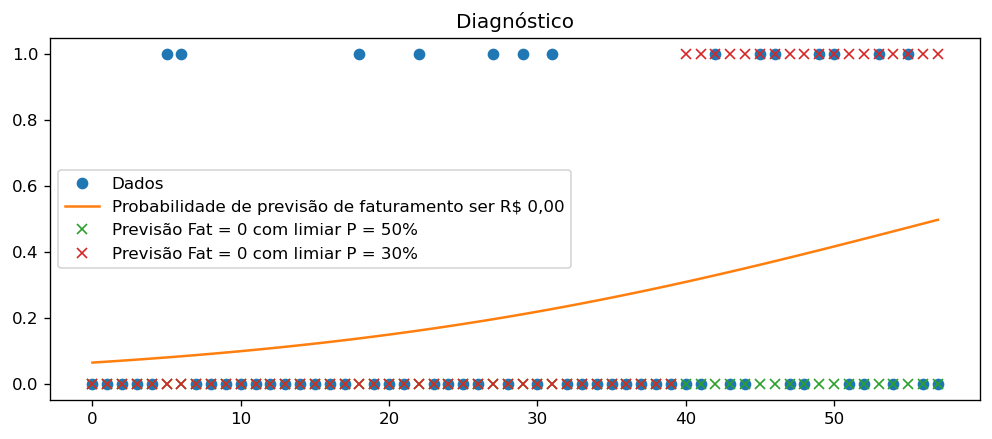

In [255]:
classification_threshold = 0.3

y_probs_full = bonusreg.predict_proba(X)
y_probs = y_probs_full[:, 1]

y_pred_all = bonusreg.predict(X)

plt.plot(X, y, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(X, y_probs, label = 'Probabilidade de previsão de faturamento ser R$ 0,00')
plt.plot(X, y_pred_all, marker = 'x', linestyle = '', label = 'Previsão Fat = 0 com limiar P = 50%')
plt.plot(X, y_probs > 0.30, marker = 'x', linestyle = '', label = f'Previsão Fat = 0 com limiar P = {classification_threshold:.0%}')

plt.legend()
plt.title('Diagnóstico')
plt.show()

Estamos interessados no valor da probabilidade de o modelo prever que o faturamento será de R$ 0,00 no mês em questão.

In [256]:
p_fat0 = spst.bernoulli(p = y_probs)

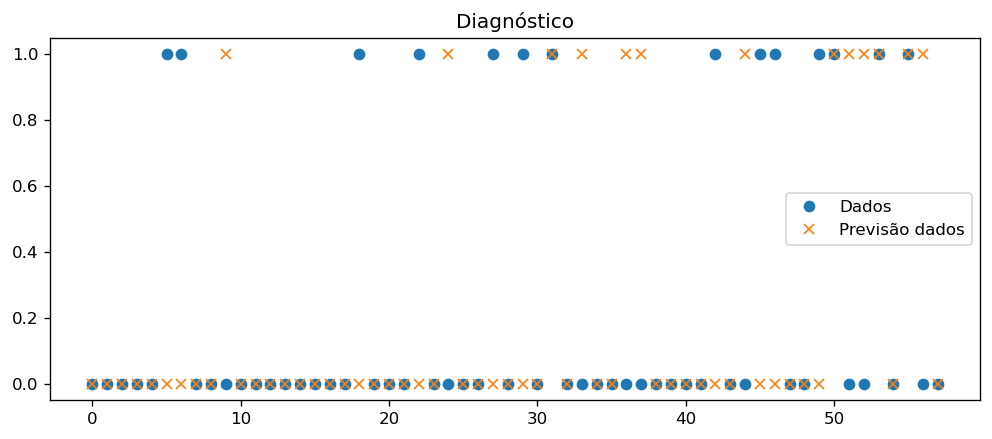

In [257]:
y_preds_pred = p_fat0.rvs(size = y_probs.shape)

fig = plt.figure()
ax = fig.gca()

plt.plot(X, y, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(X, y_preds_pred, marker = 'x', linestyle = '', label = 'Previsão dados')

plt.legend()
plt.title('Diagnóstico')
plt.show()

Visualmente, parece que o modelo preve razoavelmente a quantidade de meses em que o faturamento é zero.

### Modelo

Vamos construir uma classe cuja API é igual ao da classe `ARIMA` (que usamos até o momento para construir os outros modelos).

In [258]:
class ARIMA_zeros(ARIMA):

    def __init__(self, series_begin = '2017', *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.fat0_model_series_begin = series_begin
    
    def fit(self, *args, **kwargs):
        super().fit(*args, **kwargs)

        try:
            fat0 = args[0]
        except IndexError:
            fat0 = kwargs['y']

        fat0 = fat0.fillna(0)[self.fat0_model_series_begin:]
        
        # lembrando que o fit já é no conjunto de treino. Não é necessário fazer o train-test-split novamente
        X_train = fat0.reset_index().index.values.reshape(-1, 1)
        y_train = (fat0 == 0).values

        # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

        # sc = StandardScaler()

        # X_train = sc.fit_transform(X_train_unscaled)
        # X_test = sc.transform(X_test_unscaled)
        # X_train = X_train_unscaled
        # X_test = X_test_unscaled

        bonusreg = LogisticRegression()
        bonusreg.fit(X_train, y_train)

        self.fat0_model = bonusreg
        self.fat0_model_endog = fat0
        self.fat0_model_series_begin_idx = self.arima_res_.data.endog.shape[0] - fat0.shape[0]

        return self
    
    def predict(self, *args, **kwargs):
        y = super().predict(*args, **kwargs)

        try:
            n_periods = args[0]
        except IndexError:
            n_periods = kwargs['n_periods']
    
        endog = self.fat0_model_endog
        predict_first = len(endog) + 1
        predict_last = predict_first + n_periods
        X = np.arange(predict_first, predict_last).reshape(-1, 1)
        y_probs_full = self.fat0_model.predict_proba(X)
        y_probs = y_probs_full[:, 0]

        p_fat0 = spst.bernoulli(p = y_probs)
        y_preds_pred = p_fat0.rvs(size = y_probs.shape)

        y0 = y * y_preds_pred

        return y0
    
    def predict_proba(self, *args, **kwargs):
        return self.fat0_model.predict_proba(*args, **kwargs)
    
    def predict_in_sample(self, *args, **kwargs):
        y = super().predict_in_sample(*args, **kwargs)
        fat0_endog = self.fat0_model_endog

        X = np.arange(-self.fat0_model_series_begin_idx, fat0_endog.shape[0]).reshape(-1, 1)
        
        y_probs_full = self.fat0_model.predict_proba(X)
        y_probs = y_probs_full[:, 0]

        p_fat0 = spst.bernoulli(p = y_probs)
        y_preds_pred = p_fat0.rvs(size = y_probs.shape)

        y0 = y * y_preds_pred

        return y0


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


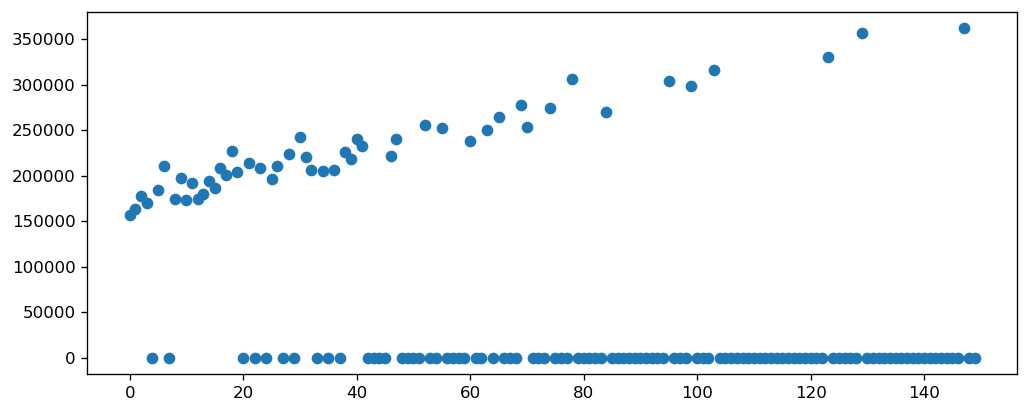

In [259]:
modelo0 = ARIMA_zeros(
    order = (1, 0, 2), 
    seasonal_order = (0, 1, 1, 12), 
    with_intercept = True,
    series_begin = '2017'
).fit(y = fat_train)

n_periods = 150
x = np.arange(0, n_periods)
y = modelo0.predict(n_periods)
plt.plot(x, y, marker = 'o', linestyle = '')
plt.show()

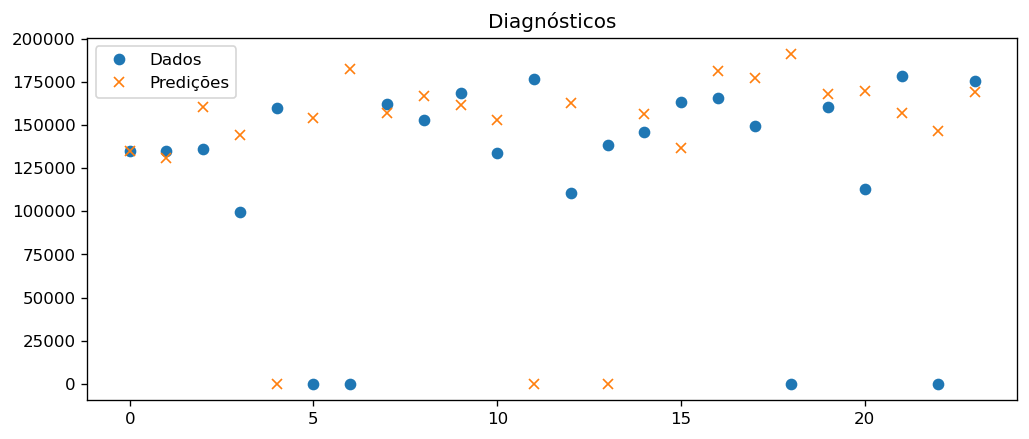

In [261]:
n_periods = modelo0.fat0_model_endog.shape[0]

fat0_series_begin_idx = modelo0.fat0_model_series_begin_idx

x = np.arange(0, n_periods)
y0 = modelo0.predict_in_sample(n_periods)[fat0_series_begin_idx:]
y1 = fat_train.fillna(0).iloc[fat0_series_begin_idx:].values

plt.plot(x, y1, marker = 'o', linestyle = '', label = 'Dados')
plt.plot(x, y0, marker = 'x', linestyle = '', label = 'Predições')

plt.legend()
plt.title('Diagnósticos')
plt.show()

Novamente, parece que o modelo prevÊ adequadamente o faturamento e a frequência de meses em que o faturamento é 0.

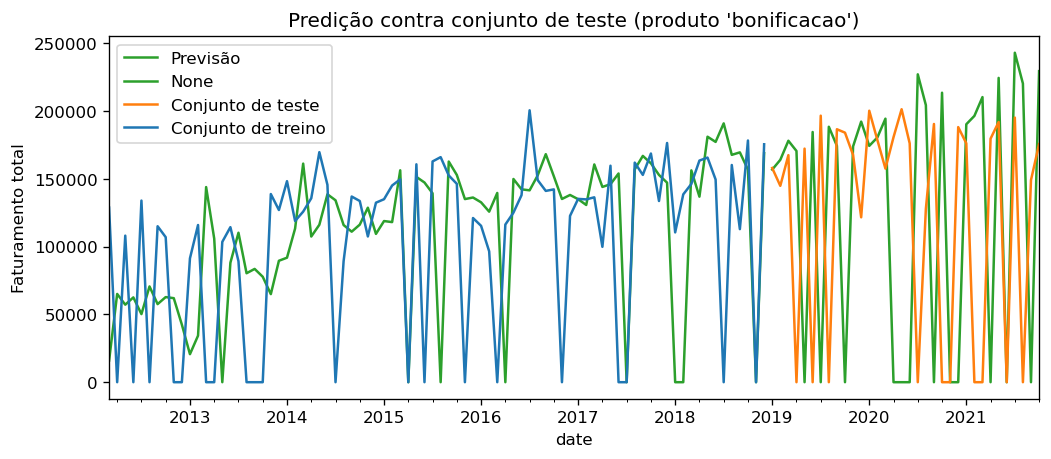

In [262]:
fat0 = fat.fillna(0)
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo0, 
    produto = analise_produto,
    serie_treino = fat_train.fillna(0),
    serie_teste = fat_test.fillna(0),
    in_sample = True,
    preds_metrics = False
)

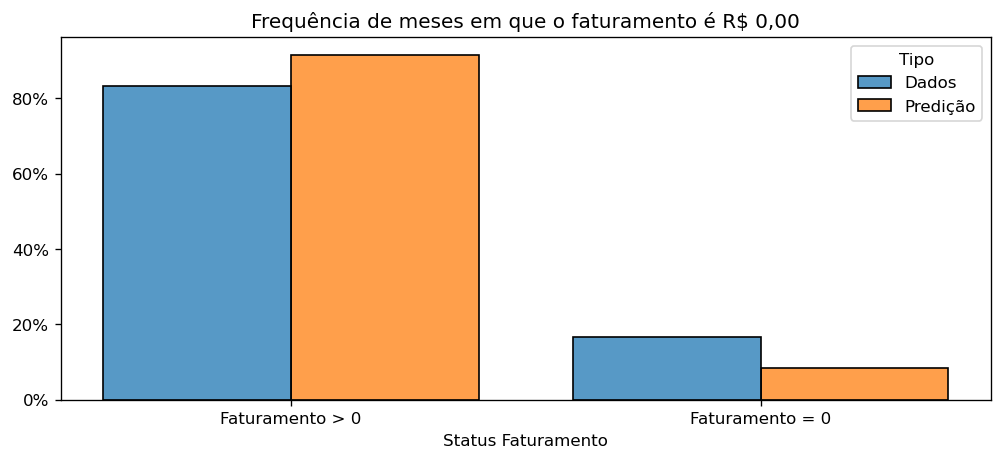

In [263]:
n_periods = modelo0.fat0_model_endog.shape[0]

fat0_series_begin_idx = modelo0.fat0_model_series_begin_idx

x = np.arange(0, n_periods)
y0 = modelo0.predict_in_sample(n_periods)[fat0_series_begin_idx:] == 0
y1 = fat_train.fillna(0).iloc[fat0_series_begin_idx:].values == 0

dfcount_wide = pd.DataFrame(
    {'Dados': y1,
    'Predição': y0},
    index = x
).reset_index()

dfcount = pd.melt(dfcount_wide, id_vars = 'index', var_name = 'Tipo', value_name = 'fat0')
dfcount['Status Faturamento'] = dfcount['fat0'].map({True: 'Faturamento = 0', False: 'Faturamento > 0'})
dfcount.rename(columns = {'index': 'meses_apos'}, inplace=True)

ax = sns.histplot(data = dfcount, x = 'Status Faturamento', hue = 'Tipo', multiple = 'dodge', shrink = 0.8, stat = 'density', common_norm = False)
ax.yaxis.set_major_formatter(lambda y, pos: f'{y:.0%}')
ax.set_ylabel('')

plt.title('Frequência de meses em que o faturamento é R$ 0,00')
plt.show()

Parece que o modelo da frequência de meses em que o faturamento é zero se ajusta bem aos dados.

## Modelo final - Modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`)

In [264]:
analise_produto = 'bonificacao'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].dropna().index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

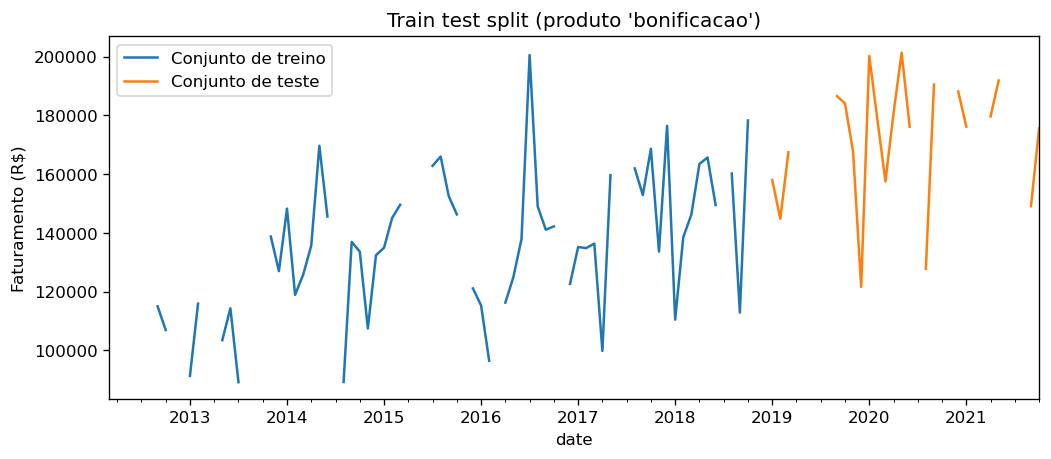

In [271]:
fat_modelo = fat.copy()

train_test_split_idx = int(fat_modelo.shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$)')
plt.legend()
plt.show()

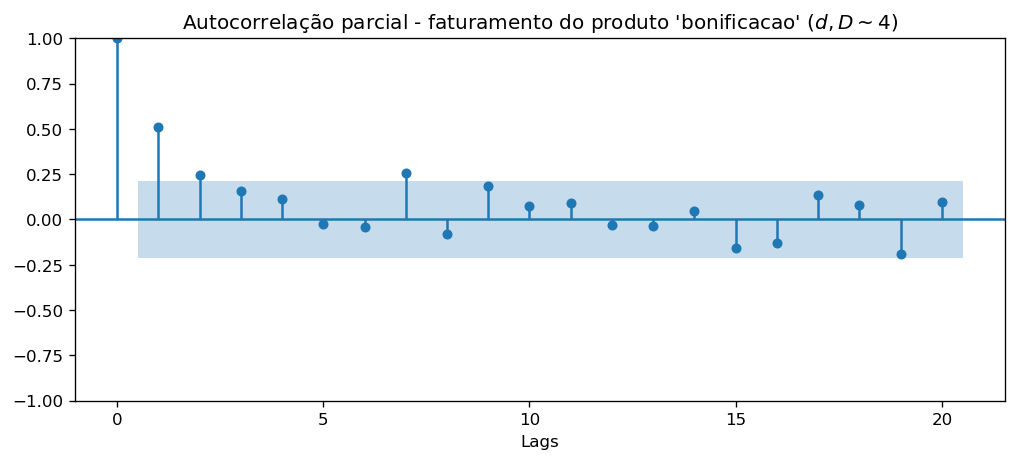

In [272]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo.dropna(), lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d, D \sim 4$)")
plt.show()

In [34]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = 2, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
# )

In [273]:
modelo = ARIMA(
    order = (1, 0, 2), 
    seasonal_order = (0, 1, 1, 12), 
    with_intercept = False
).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [274]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -638.973
Date:                              Tue, 23 Nov 2021   AIC                           1287.946
Time:                                      12:43:10   BIC                           1299.189
Sample:                                           0   HQIC                          1292.412
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9847      0.020     49.177      0.000       0.945       1.024
ma.L1         -0.7132      0.250     -2.851      0.004      -1.203      -0.223
ma.L2         -0.1321      0.279     -0.474      0.635      -0.678       0.414
ma.S.L12      -0.6815      0.300     -2.268      0.023      -1.270      -0.092
sigma2      8.117e+08   8.28e-11    9.8e+18      0.000    8.12e+08    8.12e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.95   Prob(JB):                         0.76
Heteroskedasticity (H):               0.97   Skew:                             0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+36. Standard errors may be unstable.
"""

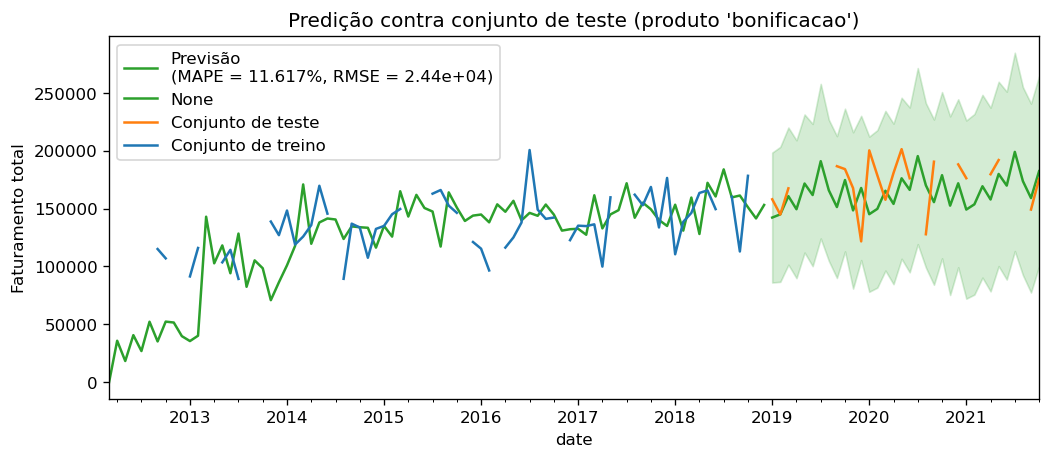

In [275]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

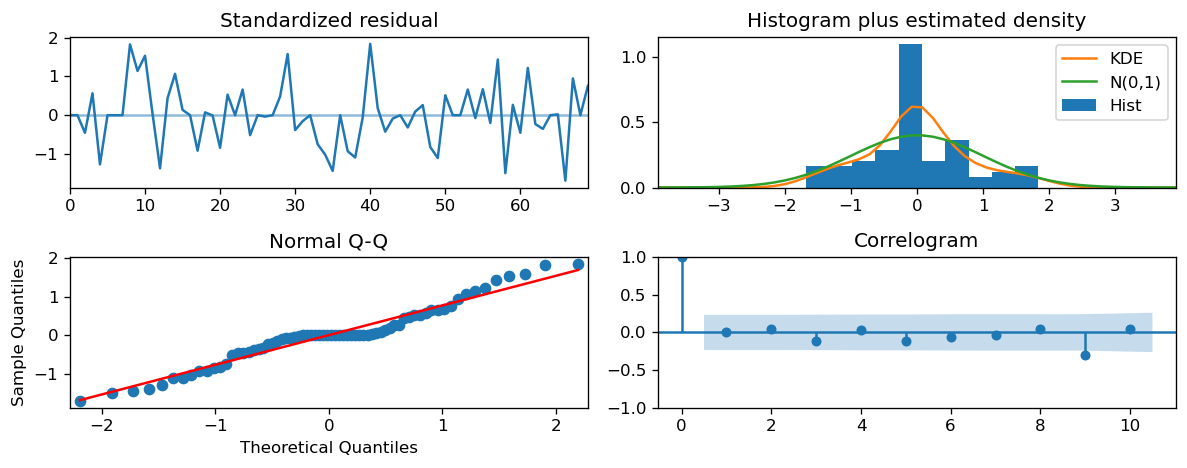

In [276]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [277]:
kwargs_ajuste = dict(
    y_true = fat_test.dropna(),
    y_pred = preds[fat_test.dropna().index],
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 11.617%
       RMSE: 2.444e+04
        MAE: 1.949e+04


Vamos salvar o modelo atual para o faturamento do produto `bonificacao`.

In [278]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)

with open(r'produto_bonificacao.model', 'wb') as arq_modelo_bonificacao:
    pickler = pickle.Pickler(file = arq_modelo_bonificacao)
    pickler.dump(modelo_dict)


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# Modelo total - Soma de previsões de produtos modelados individualmente

## Importação dos dados

In [279]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Importação de modelos

Inicialmente, vamos fazer uns set-ups:

In [280]:
modelo = {}
serie_treino = {}
metricas = {}

Para cada produto, vamos importar o modelo associado (da pasta [`models`](../models/)).

In [281]:
for produto in produtos:
    produto_  = produto.split('_')[0]
    with open(fr'produto_{produto_}.model', 'rb') as modelo_arq:
        unpickler = pickle.Unpickler(modelo_arq)
        modelo_dict = unpickler.load()
        modelo[produto] = modelo_dict['modelo']
        serie_treino[produto] = modelo_dict['serie_treino']


## Modelo total

### Separação entre dados de treino e de teste

Primeiramente, vamos extrair as somas de todos os faturamentos:

In [282]:
fat_total = tswide.sum(axis = 'columns')

Vamos fazer uma separação entre dados de treino e de teste para aferirmos a acurácia do modelo final.

Os modelos exportados dos notebooks individuais (arquivos `.pickle`) já estão previamente ajustados com dados de treino particulares.

**É necessário que o conjunto de teste para todos os produtos seja igual, de forma que possamos somá-los**. 

Dessa forma, o conjunto de teste de todos os modelos será composto dos faturamentos nos meses que não estão contidas em nenhum conjunto de treino.

Por exemplo: dentre todos os conjuntos de treino, o término mais próximo do presente é em dezembro de 2020. Logo, **o conjunto de teste (que será aplicado para todos os produtos) conterá os faturamentos de janeiro de 2021 para frente**.

Vamos ver como podemos implementar isso. Primeiramente, vamos gerar predições para todos os modelos.

In [283]:
# construimos um dataframe onde ficarão as predições individuais
preds = pd.DataFrame([], columns = produtos)

colsmult = pd.MultiIndex.from_product((produtos, ['lb', 'ub']))
preds_ci = pd.DataFrame([], columns = colsmult)

# maior data contida nos dados
max_date = fat_total.index[-1]

for produto in produtos:
    # maior data de cada conjunto de treino
    train_right_bound = serie_treino[produto].index[-1]

    # construimos o índice de datas do conjunto de teste de cada produto: 
    # range entre mês após o último contido no conjunto de treino e mês final
    idx_test = pd.date_range(start = train_right_bound + dt.timedelta(days = 1), end = max_date, freq = 'MS')

    # geramos a predição para cada produto. Essa predição vem em um np.array
    # como queremos o intervalo de confiança, o resultado da função é uma tupla com
    #    - o array da predição média
    #    - um array com duas colunas contendo o lower bound e o upper bound
    arr_pred_all = modelo[produto].predict(n_periods = idx_test.shape[0], return_conf_int = True)

    # primeiro trataremos das médias
    arr_pred = arr_pred_all[0]
    
    # convertemos o array para Series
    pred = pd.Series(arr_pred, index = idx_test)
    pred.name = 'predicted_mean'

    # adicionamos a Series ao DataFrame `preds`
    preds[produto] = pred

    # agora trabalharemos nos bounds
    arr_pred_ci = arr_pred_all[1]

    pred_ci = pd.DataFrame(
        arr_pred_ci, 
        columns = pd.MultiIndex.from_product(((produto, ), ('lb', 'ub'))), 
        index = idx_test
    )


    preds_ci[pred_ci.columns] = pred_ci

preds_ci

alimenticio               auxilio_final_de_ano                \
                      lb            ub                   lb            ub   
2019-07-01  1.644330e+09  1.647123e+09         8.959884e+05  8.959885e+05   
2019-08-01  1.665150e+09  1.671397e+09         1.346354e+06  1.346354e+06   
2019-09-01  1.728011e+09  1.738465e+09         1.815848e+06  1.815848e+06   
2019-10-01  1.742018e+09  1.757323e+09         2.176945e+06  2.176945e+06   
2019-11-01  1.769014e+09  1.789738e+09         2.331564e+06  2.331564e+06   
2019-12-01  1.804341e+09  1.831000e+09         2.237707e+06  2.237707e+06   
2020-01-01  1.769293e+09  1.802360e+09         1.920866e+06  1.920866e+06   
2020-02-01  1.773036e+09  1.812952e+09         1.467104e+06  1.467104e+06   
2020-03-01  1.751766e+09  1.798946e+09         9.996720e+05  9.996722e+05   
2020-04-01  1.766057e+09  1.820894e+09         6.455350e+05  6.455352e+05   
2020-05-01  1.754055e+09  1.816923e+09         5.008846e+05  5.008849e+05   
2020-06-01  1.731429e+09  1.802683e+09         6.145576e+05  6.145579e+05   
2020-07-01  1.713922e+09  1.796593e+09         9.686888e+05  9.686891e+05   
2020-08-01  1.730374e+09  1.827146e+09         1.467169e+06  1.467169e+06   
2020-09-01  1.793213e+09  1.906392e+09         1.974599e+06  1.974599e+06   
2020-10-01  1.800322e+09  1.931884e+09         2.353151e+06  2.353151e+06   
2020-11-01  1.825005e+09  1.976672e+09         2.500000e+06  2.500000e+06   
2020-12-01  1.856769e+09  2.030070e+09         2.375260e+06  2.375260e+06   
2021-01-01  1.809619e+09  2.005935e+09         2.012812e+06  2.012813e+06   
2021-02-01  1.804413e+09  2.025011e+09         1.511106e+06  1.511107e+06   
2021-03-01  1.773198e+09  2.019257e+09         1.006416e+06  1.006417e+06   
2021-04-01  1.781283e+09  2.053908e+09         6.358271e+05  6.358278e+05   
2021-05-01  1.759118e+09  2.059357e+09         4.999995e+05  5.000002e+05   
2021-06-01  1.725215e+09  2.054065e+09         6.471459e+05  6.471467e+05   
2021-07-01  1.694934e+09  2.056762e+09         1.048617e+06  1.048618e+06   
2021-08-01  1.701036e+09  2.099834e+09         1.595365e+06  1.595366e+06   
2021-09-01  1.757988e+09  2.197381e+09         2.138880e+06  2.138881e+06   
2021-10-01  1.752343e+09  2.235625e+09         2.531531e+06  2.531532e+06   

              bonificacao                        saude                \
                       lb             ub            lb            ub   
2019-07-01  124163.523941  257664.928098           NaN           NaN   
2019-08-01  104826.678073  226699.632879           NaN           NaN   
2019-09-01   90032.314279  212569.066876           NaN           NaN   
2019-10-01  112991.556297  236252.531187           NaN           NaN   
2019-11-01   80851.272568  215915.238520           NaN           NaN   
2019-12-01  105467.030613  230072.022530           NaN           NaN   
2020-01-01   78119.151699  212144.419433           NaN           NaN   
2020-02-01   81724.987091  217716.899596           NaN           NaN   
2020-03-01   96435.168206  234330.439080           NaN           NaN   
2020-04-01   84659.422950  223347.265870           NaN           NaN   
2020-05-01  106598.039684  245664.322505           NaN           NaN   
2020-06-01   94935.785684  237316.672793           NaN           NaN   
2020-07-01  119224.840936  271361.269633           NaN           NaN   
2020-08-01   99087.275938  241062.776126           NaN           NaN   
2020-09-01   84167.283231  226925.969410           NaN           NaN   
2020-10-01  107012.161766  250593.944058  2.335929e+07  2.678323e+07   
2020-11-01   75340.097321  229660.564605  2.285793e+07  2.770011e+07   
2020-12-01   99264.450403  244382.841359  2.252156e+07  2.845199e+07   
2021-01-01   72152.157958  226095.664956  2.227060e+07  2.911848e+07   
2021-02-01   75675.280057  231628.767514  2.207422e+07  2.973038e+07   
2021-03-01   90342.520835  248165.023385  2.191661e+07  3.030351e+07   
2021-04-01   78454.983113  237175.257094  2.17

In [284]:
idx = pd.IndexSlice
preds_ci.loc[:, idx[:, 'lb']]

alimenticio auxilio_final_de_ano    bonificacao         saude  \
                      lb                   lb             lb            lb   
2019-07-01  1.644330e+09         8.959884e+05  124163.523941           NaN   
2019-08-01  1.665150e+09         1.346354e+06  104826.678073           NaN   
2019-09-01  1.728011e+09         1.815848e+06   90032.314279           NaN   
2019-10-01  1.742018e+09         2.176945e+06  112991.556297           NaN   
2019-11-01  1.769014e+09         2.331564e+06   80851.272568           NaN   
2019-12-01  1.804341e+09         2.237707e+06  105467.030613           NaN   
2020-01-01  1.769293e+09         1.920866e+06   78119.151699           NaN   
2020-02-01  1.773036e+09         1.467104e+06   81724.987091           NaN   
2020-03-01  1.751766e+09         9.996720e+05   96435.168206           NaN   
2020-04-01  1.766057e+09         6.455350e+05   84659.422950           NaN   
2020-05-01  1.754055e+09         5.008846e+05  106598.039684           NaN   
2020-06-01  1.731429e+09         6.145576e+05   94935.785684           NaN   
2020-07-01  1.713922e+09         9.686888e+05  119224.840936           NaN   
2020-08-01  1.730374e+09         1.467169e+06   99087.275938           NaN   
2020-09-01  1.793213e+09         1.974599e+06   84167.283231           NaN   
2020-10-01  1.800322e+09         2.353151e+06  107012.161766  2.335929e+07   
2020-11-01  1.825005e+09         2.500000e+06   75340.097321  2.285793e+07   
2020-12-01  1.856769e+09         2.375260e+06   99264.450403  2.252156e+07   
2021-01-01  1.809619e+09         2.012812e+06   72152.157958  2.227060e+07   
2021-02-01  1.804413e+09         1.511106e+06   75675.280057  2.207422e+07   
2021-03-01  1.773198e+09         1.006416e+06   90342.520835  2.191661e+07   
2021-04-01  1.781283e+09         6.358271e+05   78454.983113  2.178838e+07   
2021-05-01  1.759118e+09         4.999995e+05  100254.685363  2.168341e+07   
2021-06-01  1.725215e+09         6.471459e+05   88662.165300  2.159744e+07   
2021-07-01  1.694934e+09         1.048617e+06  113266.975658  2.152739e+07   
2021-08-01  1.701036e+09         1.595365e+06   92485.065264  2.147091e+07   
2021-09-01  1.757988e+09         2.138880e+06   77472.140084  2.142619e+07   
2021-10-01  1.752343e+09         2.531531e+06  100232.002515  2.139180e+07   

              transporte  
                      lb  
2019-07-01           NaN  
2019-08-01           NaN  
2019-09-01           NaN  
2019-10-01           NaN  
2019-11-01           NaN  
2019-12-01           NaN  
2020-01-01           NaN  
2020-02-01           NaN  
2020-03-01           NaN  
2020-04-01           NaN  
2020-05-01           NaN  
2020-06-01           NaN  
2020-07-01           NaN  
2020-08-01           NaN  
2020-09-01           NaN  
2020-10-01           NaN  
2020-11-01           NaN  
2020-12-01           NaN  
2021-01-01           NaN  
2021-02-01           NaN  
2021-03-01           NaN  
2021-04-01  1.708596e+08  
2021-05-01  1.708543e+08  
2021-06-01  1.711715e+08  
2021-07-01  1.716556e+08  
2021-08-01  1.722463e+08  
2021-09-01  1.729129e+08  
2021-10-01  1.736369e+08

In [285]:
preds_ci.loc[:, idx[:, 'ub']]

alimenticio auxilio_final_de_ano    bonificacao         saude  \
                      ub                   ub             ub            ub   
2019-07-01  1.647123e+09         8.959885e+05  257664.928098           NaN   
2019-08-01  1.671397e+09         1.346354e+06  226699.632879           NaN   
2019-09-01  1.738465e+09         1.815848e+06  212569.066876           NaN   
2019-10-01  1.757323e+09         2.176945e+06  236252.531187           NaN   
2019-11-01  1.789738e+09         2.331564e+06  215915.238520           NaN   
2019-12-01  1.831000e+09         2.237707e+06  230072.022530           NaN   
2020-01-01  1.802360e+09         1.920866e+06  212144.419433           NaN   
2020-02-01  1.812952e+09         1.467104e+06  217716.899596           NaN   
2020-03-01  1.798946e+09         9.996722e+05  234330.439080           NaN   
2020-04-01  1.820894e+09         6.455352e+05  223347.265870           NaN   
2020-05-01  1.816923e+09         5.008849e+05  245664.322505           NaN   
2020-06-01  1.802683e+09         6.145579e+05  237316.672793           NaN   
2020-07-01  1.796593e+09         9.686891e+05  271361.269633           NaN   
2020-08-01  1.827146e+09         1.467169e+06  241062.776126           NaN   
2020-09-01  1.906392e+09         1.974599e+06  226925.969410           NaN   
2020-10-01  1.931884e+09         2.353151e+06  250593.944058  2.678323e+07   
2020-11-01  1.976672e+09         2.500000e+06  229660.564605  2.770011e+07   
2020-12-01  2.030070e+09         2.375260e+06  244382.841359  2.845199e+07   
2021-01-01  2.005935e+09         2.012813e+06  226095.664956  2.911848e+07   
2021-02-01  2.025011e+09         1.511107e+06  231628.767514  2.973038e+07   
2021-03-01  2.019257e+09         1.006417e+06  248165.023385  3.030351e+07   
2021-04-01  2.053908e+09         6.358278e+05  237175.257094  3.084726e+07   
2021-05-01  2.059357e+09         5.000002e+05  259514.652952  3.136776e+07   
2021-06-01  2.054065e+09         6.471467e+05  250982.476648  3.186925e+07   
2021-07-01  2.056762e+09         1.048618e+06  284598.281076  3.235482e+07   
2021-08-01  2.099834e+09         1.595366e+06  254832.824165  3.282682e+07   
2021-09-01  2.197381e+09         2.138881e+06  240679.343195  3.328706e+07   
2021-10-01  2.235625e+09         2.531532e+06  264324.403269  3.373697e+07   

              transporte  
                      ub  
2019-07-01           NaN  
2019-08-01           NaN  
2019-09-01           NaN  
2019-10-01           NaN  
2019-11-01           NaN  
2019-12-01           NaN  
2020-01-01           NaN  
2020-02-01           NaN  
2020-03-01           NaN  
2020-04-01           NaN  
2020-05-01           NaN  
2020-06-01           NaN  
2020-07-01           NaN  
2020-08-01           NaN  
2020-09-01           NaN  
2020-10-01           NaN  
2020-11-01           NaN  
2020-12-01           NaN  
2021-01-01           NaN  
2021-02-01           NaN  
2021-03-01           NaN  
2021-04-01  1.775518e+08  
2021-05-01  1.803185e+08  
2021-06-01  1.827627e+08  
2021-07-01  1.850400e+08  
2021-08-01  1.872106e+08  
2021-09-01  1.893054e+08  
2021-10-01  1.913428e+08

Pelo fato de os conjuntos de treinos terminarem em datas diferentes, os conjuntos de testes também começam em datas diferentes, e portanto há alguns `NaN`s nas predições.

Vamos agora pegar a interseção de todos esses conjuntos de teste.

In [286]:
fat_test = pd.DataFrame([])

fat_test['predicted_mean'] = preds.dropna().sum(axis = 'columns')

fat_test['lb'] = preds_ci.loc[:, (slice(None), 'lb')].dropna().sum(axis = 'columns')
fat_test['ub'] = preds_ci.loc[:, (slice(None), 'ub')].dropna().sum(axis = 'columns')

fat_test

predicted_mean            lb            ub
2021-04-01    2.118913e+09  1.974645e+09  2.263181e+09
2021-05-01    2.112029e+09  1.952256e+09  2.271803e+09
2021-06-01    2.094157e+09  1.918720e+09  2.269595e+09
2021-07-01    2.082384e+09  1.889279e+09  2.275490e+09
2021-08-01    2.109081e+09  1.896441e+09  2.321722e+09
2021-09-01    2.188448e+09  1.954543e+09  2.422353e+09
2021-10-01    2.206752e+09  1.950003e+09  2.463500e+09

## Comparação

Vamos comparar o modelo total com a série de faturamentos original.

In [290]:
# a classe py_scripts.models.modelo_produtos encapsula o que foi feito até esse ponto no notebook.
# é um jeito de externar uma API similar ao da classe ARIMA somente com o método .predict(n_periodos)

modelo_total = py_scripts.models.modelo_produtos(
    modelsdir = r'.', 
    dataset = r'data/sim_ts_limpo.csv'
)
print(modelo_total)

Modelos:
             alimenticio:  ARIMA(1,2,0)(0,2,0)[12]          
    auxilio_final_de_ano:  ARIMA(3,0,2)(1,6,0)[12]          
             bonificacao:  ARIMA(1,0,2)(0,1,1)[12]          
                   saude:  ARIMA(0,1,0)(0,0,0)[12] intercept
              transporte:  ARIMA(0,1,0)(0,0,0)[12] intercept


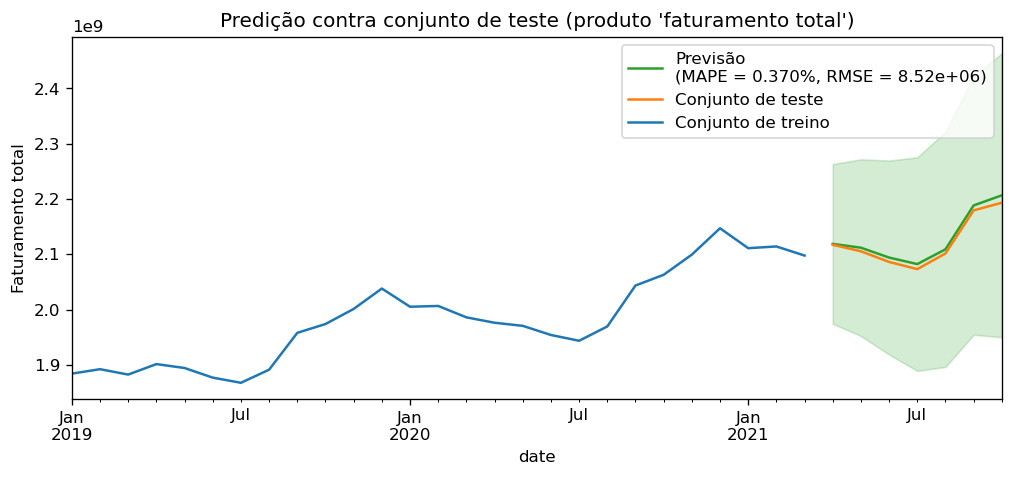

In [291]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_total, 
    produto = 'faturamento total',
    serie_treino = fat_total['2019':'2021-03'],
    serie_teste = fat_total['2021-04':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Por fim, calculamos as métricas associadas a esse conjunto de teste:

In [292]:
metricas = py_scripts.metrics.mostrar_metricas(
    y_true = fat_total[fat_test.index],
    y_pred = fat_test.predicted_mean
)

Métricas:
       MAPE: 0.370%
       RMSE: 8.519e+06
        MAE: 7.869e+06


# 8 - Análise Comparativa entre modelos de séries temporais

## Introdução

Esta seção é uma comparação entre modelos de séries temporais:

* **Modelo Total**: Modelo autorregressivo integrável de médias móveis com sazonalidade (`SARIMA`), treinado no faturamento total;
* **Modelo *Megazord***: Modelos treinados individualmente para cada produto, e somados para obter a previsão de faturamento total.

## Importação dos dados

Vamos importar os dados:

In [293]:
ts_raw = pd.read_csv(r'data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Importação dos modelos

Vamos agora importar os modelos para comparação. 


### Modelo com produtos individuais (modelo *Megazord*)

Primeiramente, importaremos o modelo *Megazord*:

In [294]:
modelo_megazord = py_scripts.models.modelo_produtos(
    modelsdir = r'.', 
    dataset = r'data/sim_ts_limpo.csv'
)
modelo, serie_treino = modelo_megazord.get_models()

print(modelo_megazord)

Modelos:
             alimenticio:  ARIMA(1,2,0)(0,2,0)[12]          
    auxilio_final_de_ano:  ARIMA(3,0,2)(1,6,0)[12]          
             bonificacao:  ARIMA(1,0,2)(0,1,1)[12]          
                   saude:  ARIMA(0,1,0)(0,0,0)[12] intercept
              transporte:  ARIMA(0,1,0)(0,0,0)[12] intercept


### Modelo do faturamento total (modelo Total)

Vamos agora importar o modelo treinado nos faturamentos totais:

In [295]:
with open(fr'total.model', 'rb') as modelo_arq:
    unpickler = pickle.Unpickler(modelo_arq)
    modelo_dict = unpickler.load()
    modelo['total'] = modelo_dict['modelo']
    serie_treino['total'] = modelo_dict['serie_treino']

In [296]:
print(f"Modelo total: {modelo['total']}")

Modelo total:  ARIMA(0,2,0)(1,1,1)[12] intercept


## Comparação

Estamos preparados para comparar os modelos

In [297]:
fat_total = tswide.sum(axis = 'columns')
series_begin = '2019-06'

### Análise gráfica

Plotamos o ajuste do modelo *Megazord*:

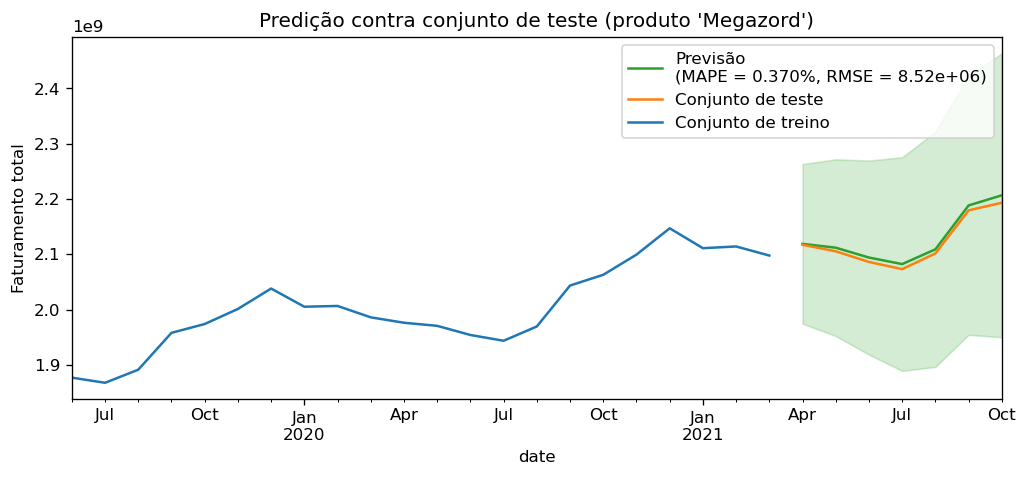

In [298]:
test_begin = modelo_megazord.get_all_test_begin()
fat_megazord_train = fat_total[series_begin: test_begin].iloc[:-1]
fat_megazord_test = fat_total[test_begin:]

preds_megazord = py_scripts.plots.ajuste_grafico(
    modelo = modelo_megazord, 
    produto = 'Megazord',
    serie_treino = fat_megazord_train,
    serie_teste = fat_megazord_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Plotamos agora o ajuste do modelo Total:

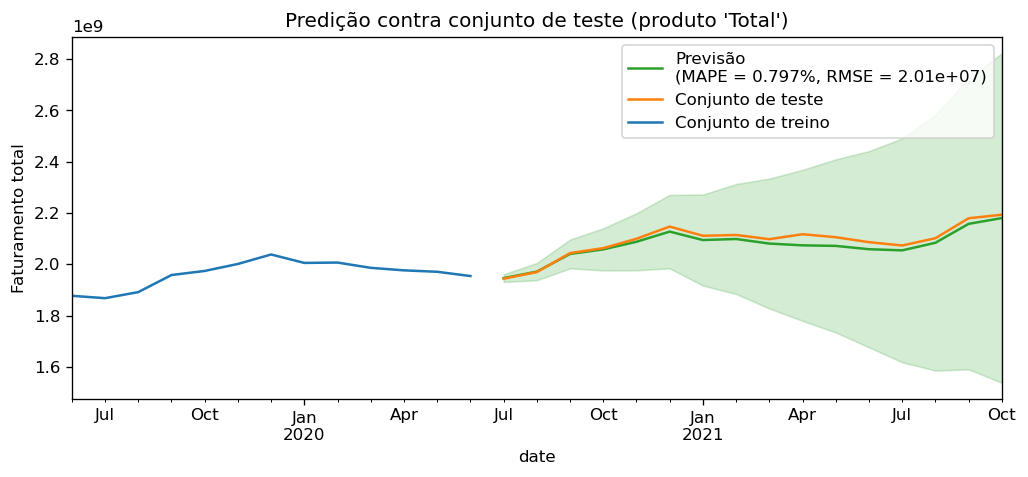

In [299]:
modelo_total = modelo['total']
fat_total_train = serie_treino['total'][series_begin:]
fat_total_test = fat_total[fat_total_train.index[-1]:].iloc[1:]

preds_total = py_scripts.plots.ajuste_grafico(
    modelo = modelo_total, 
    produto = 'Total',
    serie_treino = fat_total_train,
    serie_teste = fat_total_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Comparando os gráficos:

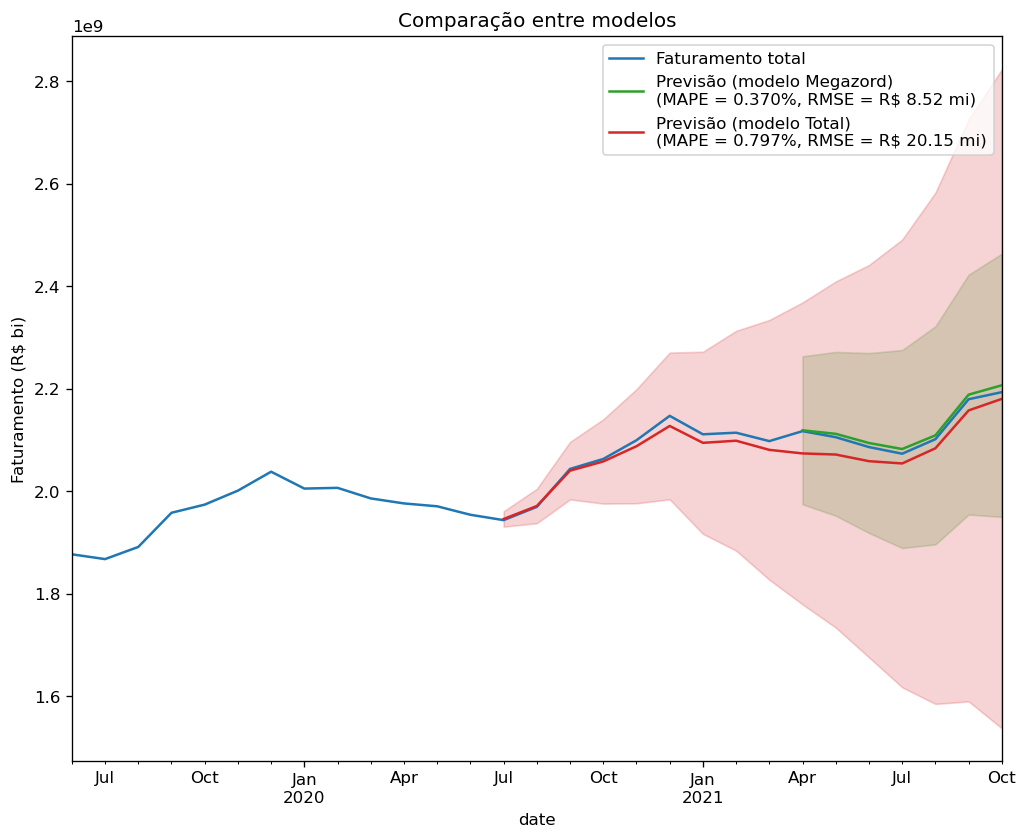

In [300]:
fig = plt.figure(figsize = (10,8))

palette = sns.color_palette(None, 5)

fat_total[series_begin:].plot(label = 'Faturamento total', color = palette[0])

# plotando a previsão do modelo megazord
idx_megazord = pd.date_range(
    start = modelo_megazord.get_all_test_begin(),
    end = fat_total.index[-1],
    freq = 'MS'
)

n_periodos_megazord = idx_megazord.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um dataframe
preds_megazord_ci = modelo_megazord.predict(
    n_periods = n_periodos_megazord,
    return_conf_int = True,
    predict_array = False,
)

# calculando métricas
metricas_preds_megazord = py_scripts.metrics.calc_metricas(
    y_true = fat_megazord_test,
    y_pred = preds_megazord
)
label_megazord = (
    'Previsão (modelo Megazord)'
    f"\n(MAPE = {metricas_preds_megazord['MAPE']:.3%}, "
    f"RMSE = R$ {metricas_preds_megazord['RMSE']/10**6:.2f} mi)"
)

# plotando
preds_megazord_ci['predicted_mean'].plot(label = label_megazord, color = palette[2])
plt.fill_between(idx_megazord, preds_megazord_ci['lb'], preds_megazord_ci['ub'], alpha = 0.2, color = palette[2])

# plotando a previsão do modelo Total
idx_total = pd.date_range(
    start = fat_total_test.index[0],
    end = fat_total.index[-1],
    freq = 'MS'
)

n_periodos_total = idx_total.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um array
preds_total_ci_arr = modelo_total.predict(
    n_periods = n_periodos_total,
    return_conf_int = True
)

# transformando o array em uma Series e um DataFrame
preds_total_ci_mean = pd.Series(preds_total_ci_arr[0], index = idx_total)

preds_total_ci_lbub = pd.DataFrame(preds_total_ci_arr[1], columns = ['lb', 'ub'], index = idx_total)

# calculando métricas
metricas_preds_total = py_scripts.metrics.calc_metricas(
    y_true = fat_total_test,
    y_pred = preds_total
)
label_total = (
    'Previsão (modelo Total)'
    f"\n(MAPE = {metricas_preds_total['MAPE']:.3%}, "
    f"RMSE = R$ {metricas_preds_total['RMSE']/10**6:.2f} mi)"
)

# plotando
preds_total_ci_mean.plot(label = label_total, color = palette[3])
plt.fill_between(idx_total, preds_total_ci_lbub['lb'], preds_total_ci_lbub['ub'], alpha = 0.2, color = palette[3])

plt.title('Comparação entre modelos')
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()


O modelo *Megazord* parece melhor ajustado que o modelo Total, embora o conjunto de teste daquele seja menor do que o deste.

Além de ser melhor ajustado, mesmo com conjunto de teste menor o modelo *Megazord* tem um intervalo de confiança menor.

### Métricas

Vamos agora calcular algumas métricas quantitativas.

Começamos pelo modelo *Megazord*:

In [301]:
metricas = {}

In [302]:
kwargs_ajuste = dict(
    y_true = fat_megazord_test,
    y_pred = preds_megazord,
)

metricas['megazord'] = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.370%
       RMSE: 8.519e+06
        MAE: 7.869e+06


Partimos para o cálculo das métricas do modelo Total:

In [303]:
kwargs_ajuste = dict(
    y_true = fat_total_test,
    y_pred = preds_total,
)

metricas['total'] = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.797%
       RMSE: 2.015e+07
        MAE: 1.683e+07


O modelo *Megazord* apresenta métricas melhores que o modelo Total:

| Métrica | modelo *Megazord* | modelo Total | Dif.        | % Dif. |
|---------|-------------------|--------------|-------------|--------|
| MAPE    | **0.370%**        | 0.797%       | 0.427 p.p.  | 53.6%  |
| RMSE    | **R$ 8.52 mi**    | R$ 20.2 mi   | R$ 11.63 mi | 57.7%  |
| MAE     | **R$ 7.87 mi**    | R$ 16.8 mi   | R$ 8.96 mi  | 53.3%  |

Além disso, conforme dissemos anteriormente, o modelo *Megazord* apresenta intervalos de confiança mais abertos:

In [304]:
amplitude_ci = pd.DataFrame(
    [], index = fat_total_test.index
)

amplitude_ci['megazord'] = preds_megazord_ci['ub'] - preds_megazord_ci['lb']
amplitude_ci['total'] = preds_total_ci_lbub['ub'] - preds_total_ci_lbub['lb']

# dropando qualquer linha em que um dos valores é NaN, já que não é possível uma comparação
amplitude_ci.dropna(inplace = True)

# calculando o melhor em cada mês
amplitude_ci['melhor'] = np.where(amplitude_ci['megazord'] <= amplitude_ci['total'], 'megazord', 'total')

print('Amplitude dos intervalos de confiança (menor é melhor):')
amplitude_ci

Amplitude dos intervalos de confiança (menor é melhor):


megazord         total    melhor
date                                            
2021-04-01  2.885355e+08  5.889511e+08  megazord
2021-05-01  3.195470e+08  6.751869e+08  megazord
2021-06-01  3.508749e+08  7.652533e+08  megazord
2021-07-01  3.862109e+08  8.733392e+08  megazord
2021-08-01  4.252806e+08  9.972770e+08  megazord
2021-09-01  4.678099e+08  1.135117e+09  megazord
2021-10-01  5.134972e+08  1.285250e+09  megazord

## Previsão até o fim de 2021

Vamos prever os faturamentos até o fim de 2021:

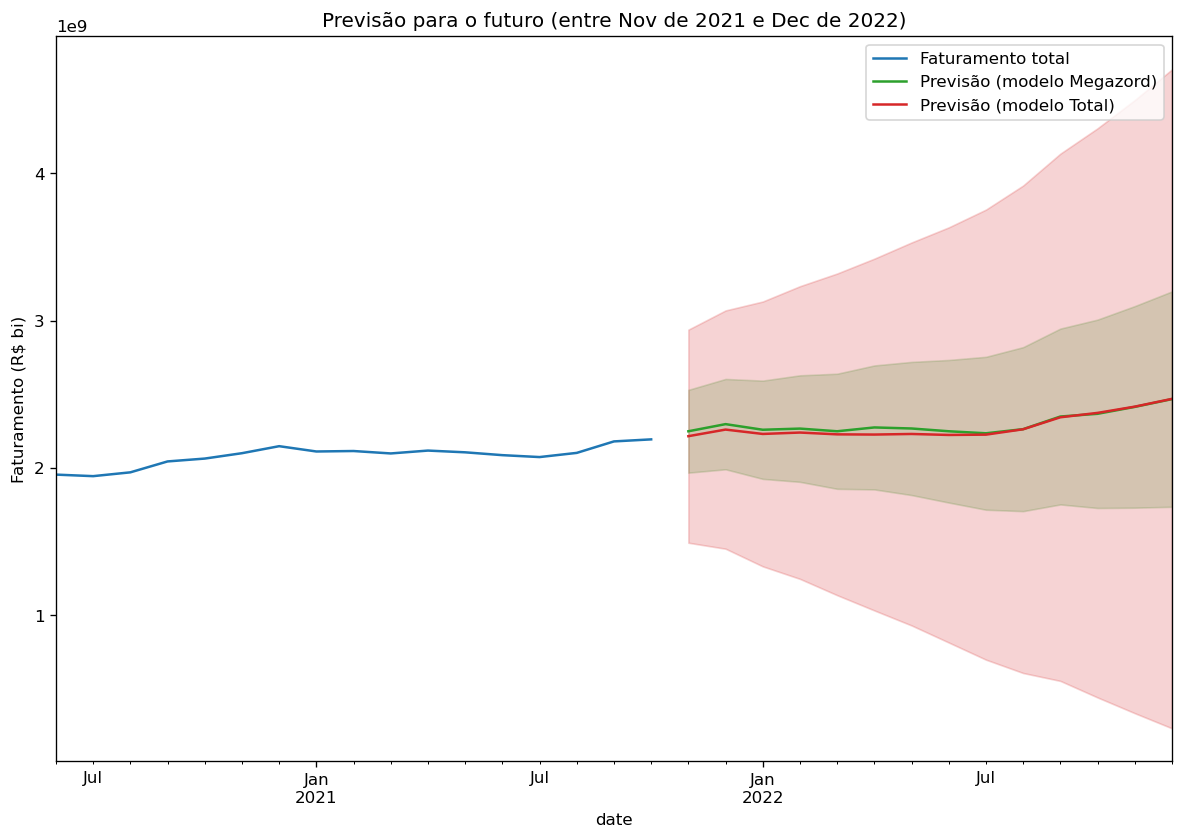

In [305]:
fat_total_begin = '2020-06'
previsao_desde = fat_total.index[-1] + pd.offsets.MonthBegin()
previsao_ate = '2022-12'

idx_previsao = pd.date_range(
    start = previsao_desde,
    end = previsao_ate,
    freq = 'MS'
)

fig = plt.figure(figsize = (12, 8))

palette = sns.color_palette(None, 5)

fat_total[fat_total_begin:].plot(label = 'Faturamento total', color = palette[0])

# plotando a previsão do modelo megazord
idx_megazord = pd.date_range(
    start = modelo_megazord.get_all_test_begin(),
    end = previsao_ate,
    freq = 'MS'
)

n_periodos_megazord = idx_megazord.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um dataframe
preds_megazord_ci = modelo_megazord.predict(
    n_periods = n_periodos_megazord,
    return_conf_int = True,
    predict_array = False,
)

preds_megazord_ci_previsao = preds_megazord_ci[previsao_desde:]

# plotando
preds_megazord_ci_previsao['predicted_mean'].plot(label = 'Previsão (modelo Megazord)', color = palette[2])
plt.fill_between(idx_previsao, preds_megazord_ci_previsao['lb'], preds_megazord_ci_previsao['ub'], alpha = 0.2, color = palette[2])

# plotando a previsão do modelo Total
idx_total = pd.date_range(
    start = fat_total_test.index[0],
    end = previsao_ate,
    freq = 'MS'
)

n_periodos_total = idx_total.shape[0]

# vamos calcular a previsão do modelo Megazord, incluindo o intervalo de confianca, retornando um array
preds_total_ci_arr = modelo_total.predict(
    n_periods = n_periodos_total,
    return_conf_int = True
)

# transformando o array em uma Series e um DataFrame
preds_total_ci_mean = pd.Series(preds_total_ci_arr[0], index = idx_total)

preds_total_ci_lbub = pd.DataFrame(preds_total_ci_arr[1], columns = ['lb', 'ub'], index = idx_total)

# a previsão deve partir do fim da série

preds_total_ci_mean = preds_total_ci_mean[previsao_desde:]
preds_total_ci_lbub = preds_total_ci_lbub.loc[previsao_desde:]

# plotando
preds_total_ci_mean.plot(label = 'Previsão (modelo Total)', color = palette[3])
plt.fill_between(idx_previsao, preds_total_ci_lbub['lb'], preds_total_ci_lbub['ub'], alpha = 0.2, color = palette[3])

# data da previsao
dtfmt = '%b de %Y'

previsao_de_dt = idx_previsao[0]
previsao_de_str = previsao_de_dt.strftime(format = dtfmt)

previsao_ate_dt = idx_previsao[-1]
previsao_ate_str = previsao_ate_dt.strftime(format = dtfmt)

plt.title(f'Previsão para o futuro (entre {previsao_de_str} e {previsao_ate_str})')
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

## Conclusão

Dada a análise anterior, **escolheria para uso em produção em minha empresa o modelo que considera a soma dos modelos de cada produto (batizado de modelo *Megazord*)**, dado que

* apresenta métricas (MAPE, RMSE e MAE) melhores. As métricas refletem diretamente o impacto para o negócio: qual é o erro médio ao se fazer uma previsão de faturamento em uma data qualquer; e
* apresenta intervalo de confiança mais estreito. Esse critério também se relaciona com a probabilidade de se fazer uma previsão errada.